In [1]:
import numpy as np
import pandas as pd
import ROOT
import matplotlib.pyplot as plt
#from scipy.integrate import simps
from numpy import trapz
from ROOT import TMath
from scipy.optimize import curve_fit
from scipy.stats import rayleigh
import uproot
import uproot3
from concurrent.futures import ThreadPoolExecutor
#import rootplot.root2matplotlib as r2m
from scipy.optimize import curve_fit
from scipy import integrate
import matplotlib.ticker as mtick
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
from scipy import integrate
#import imageio
import os
from scipy.interpolate import interp1d
from __future__ import division
import scipy.optimize as opt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm
import json
#import Mg25an
#import rootplot.root2matplotlib as r2m
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
#from scipy.integrate import simps

Welcome to JupyROOT 6.26/06


In [2]:
def gaussian1(x,  norm1,mean1,sigma1):
    return norm1*np.exp(-np.power(x - mean1, 2)/(2*np.power(sigma1, 2)))
def gaussian2(x,norm2,mean2,sigma2):
    return norm2*np.exp(-np.power(x - mean2, 2)/(2*np.power(sigma2, 2)))
def linear(x,slope,intercept):
    return slope*x + intercept
def fitFunc(x, norm1,mean1,sigma1,norm2,mean2,sigma2):
    return  gaussian1(x, norm1,mean1,sigma1) + gaussian2(x, norm2,mean2,sigma2)  
def psd_fitting(x,a,b,c):
    return a/(np.sqrt(x)) + b*x +c 

In [3]:
ion_energy = []
dEdx_elec = []
file_path = '/Users/shahinashahina/Documents/PhD/Experiments/25Mg(a,n)/CAMPAIGN_2018/25Mg_CAMPAIGN_2018/25Mg/gamma_ray_data/gamma_data_Nov/gamma_analysis_uproot/Helium in Magnesium.txt'
with open(file_path, 'r') as file:
    lines = file.readlines()
    for i, line in enumerate(lines[75:95]):  # Print first 10 lines for inspection
        parts = line.split()
        ion_energy.append(float(parts[0]))
        dEdx_elec.append(float(parts[2]))
        

In [4]:
"""
25Mg(4He,n1,n2,n3) Q-value: 2.65361 MeV
13C(4He,n1,n2,n3) Q-value: 2.21561 MeV
17O(4He,n1,n2,n3) Q-value: 0.586766 MeV
18O(4He,n1,n2,n3) Q-value: -0.697441 MeV
10B(4He,n1,n2,n3) Q-value: 1.05873 MeV
11B(4He,n1,n2,n3) Q-value: 0.15789 MeV

"""

'\n25Mg(4He,n1,n2,n3) Q-value: 2.65361 MeV\n13C(4He,n1,n2,n3) Q-value: 2.21561 MeV\n17O(4He,n1,n2,n3) Q-value: 0.586766 MeV\n18O(4He,n1,n2,n3) Q-value: -0.697441 MeV\n10B(4He,n1,n2,n3) Q-value: 1.05873 MeV\n11B(4He,n1,n2,n3) Q-value: 0.15789 MeV\n\n'

In [5]:


# Reaction class definition
class Reaction:
    def __init__(self, name, M1, M2, M3, M4, Q):
        self.name = name
        self.M1 = M1
        self.M2 = M2
        self.M3 = M3
        self.M4 = M4
        self.Q = Q

# Neutron Energy definitions 
reactions = [
    Reaction("25Mg(a,n0)", 4.002055, 25, 1, 28, 2.65361),
    Reaction("25Mg(a,n1)", 4.002055, 25, 1, 28, 2.65361-1.779),
    Reaction("25Mg(a,n2)", 4.002055, 25, 1, 28, 2.65361-4.61786),
    Reaction("13C(a,n0)", 4.002055, 13, 1, 16, 2.21561),
    Reaction("17O(a,n0)", 4.002055, 17, 1, 20, 0.58677),
    Reaction("17O(a,n1)", 4.002055, 17, 1, 20, 0.58677-1.633),
    Reaction("18O(a,n0)", 4.002055, 18, 1, 21, -0.69744),
    Reaction("18O(a,n1)", 4.002055, 18, 1, 21, -0.69744-0.3507),
    Reaction("10B(a,n0)", 4.002055, 10, 1, 13, 1.0587),
    Reaction("11B(a,n0)", 4.002055, 11, 1, 14, 0.15789),
]

theta = [125.0, 90.0, 90.0, 55.0, 125.0, 55.0, 0.0]

def Et(Ebeam, Q):
    return Ebeam + Q

def A(Ebeam, M1, M2, M3, M4, Q):
    return (M1 * M4 * (Ebeam / Et(Ebeam, Q))) / ((M1 + M2) * (M3 + M4))

def B(Ebeam, M1, M2, M3, M4, Q):
    return M1 * M3 * Ebeam / Et(Ebeam, Q) / ((M1 + M2) * (M3 + M4))

def C(Ebeam, M1, M2, M3, M4, Q):
    return M2 * M3 / ((M1 + M2) * (M3 + M4)) * (1 + M1 * Q / M2 / Et(Ebeam, Q))

def D(Ebeam, M1, M2, M3, M4, Q):
    return M2 * M4 / ((M1 + M2) * (M3 + M4)) * (1 + M1 * Q / M2 / Et(Ebeam, Q))

def En(Ebeam, theta, M1, M2, M3, M4, Q):
    theta_rad = (theta * np.pi) / 180  # theta is in degrees 
    return (B(Ebeam, M1, M2, M3, M4, Q) + D(Ebeam, M1, M2, M3, M4, Q) + 
            2 * np.sqrt(A(Ebeam, M1, M2, M3, M4, Q) * C(Ebeam, M1, M2, M3, M4, Q)) * np.cos(theta_rad)) * Et(Ebeam, Q)

# Assume Ebeam is provided
Ebeam = 2.497 # Example beam energy in MeV

for i, reaction in enumerate(reactions):
    for angle in theta:
        neutron_energy = En(Ebeam, angle, reaction.M1, reaction.M2, reaction.M3, reaction.M4, reaction.Q)
        #print(f"Reaction: {reaction.name}, Angle: {angle} degrees, Neutron Energy: {neutron_energy:.2f} MeV")


In [6]:
neutronDetectors = ["00", "04", "10", "12", "14"]

In [7]:
ROOT.gROOT.SetBatch(1)
datafile = np.loadtxt('/Users/shahinashahina/Documents/PhD/Experiments/25Mg(a,n)/CAMPAIGN_2018/25Mg_CAMPAIGN_2018/neutron_data/scripts_python2/data_new.txt')
run = datafile[:,0]
energy = datafile[:,1]

In [8]:
for i in range(len(run)):
    runNumber = int(run[i])
    beamEnergy = float((energy[i])/1000)

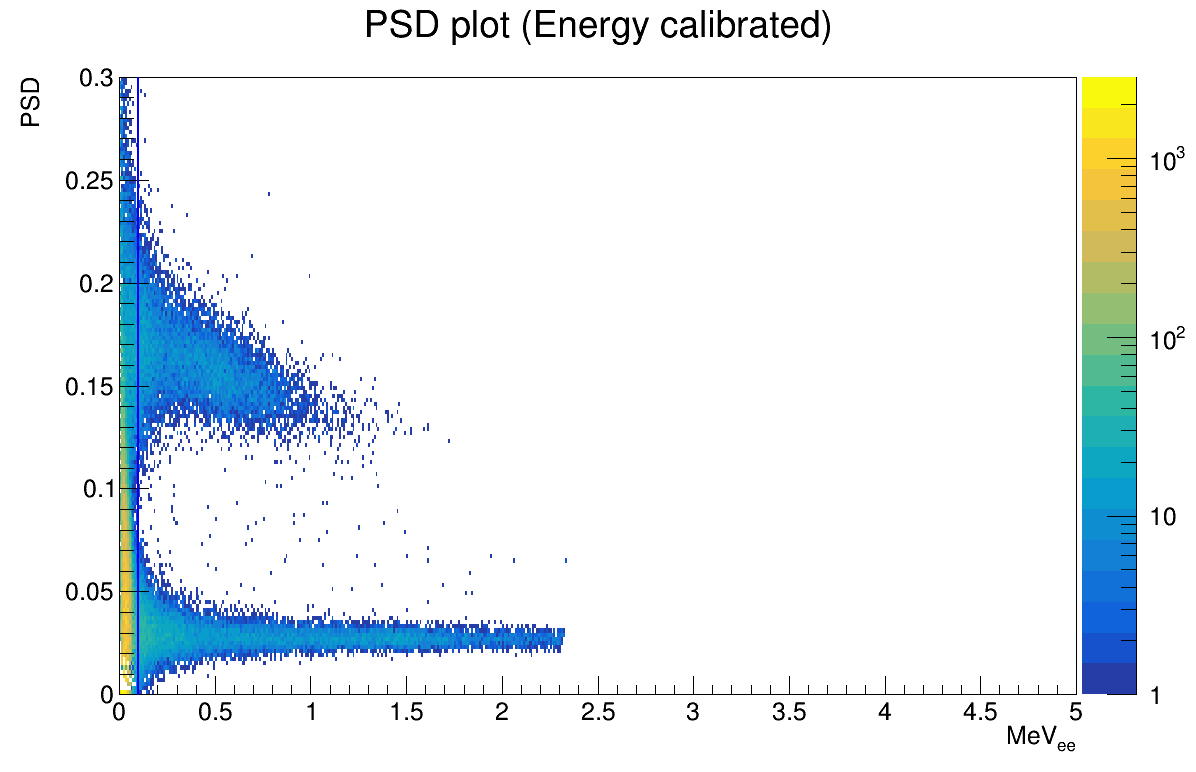

In [9]:
inFile_extracted = ROOT.TFile("/Users/shahinashahina/Documents/PhD/Experiments/25Mg(a,n)/CAMPAIGN_2018/25Mg_CAMPAIGN_2018/neutron_data/scripts_python2/ExtractNeutronSpectra_data/" + "run_0234.root")
# PSD plot
canvas = ROOT.TCanvas("canvas", "PSD Plot", 1200, 800)

hPSDee = inFile_extracted.Get("hPSDee_0-0")
hPSDee.SetTitle("PSD plot (Energy calibrated);MeV_{ee};PSD")
#cut  = inFile_extracted.Get("neutronCut_0-0")
#cut.SetLineColor(ROOT.kRed)
#cut.SetLineWidth(2)
        
hPSDee.Draw("colz")
hPSDee.SetStats(0)
#cut.Draw("same")
hPSDee.GetYaxis().SetRangeUser(0, 0.3)
hPSDee.GetXaxis().SetRangeUser(0, 5)


# Draw a straight line at x=100 keVee
line = ROOT.TLine(0.1, 0, 0.1, 0.3)  # Coordinates are in MeVee, so 100 keVee = 0.1 MeVee
line.SetLineColor(ROOT.kBlue)
line.SetLineWidth(2)
line.Draw()
canvas.SetLogz(1)
canvas.Draw()

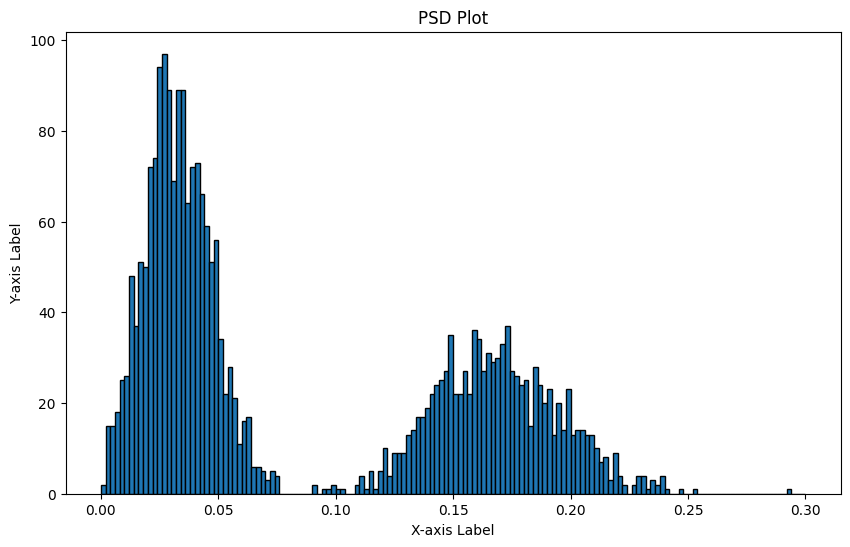

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


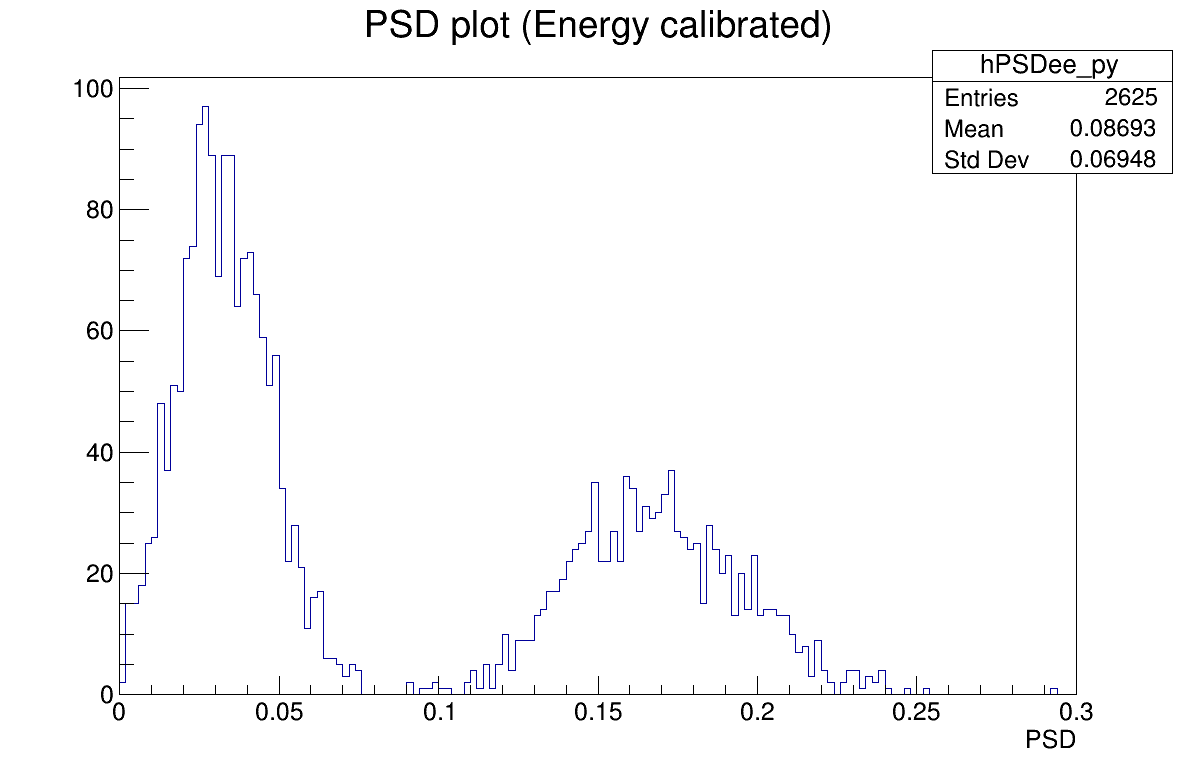

In [10]:
hPSDee_py = hPSDee.ProjectionY("hPSDee_py",11,12)
canvas = ROOT.TCanvas("canvas", "PSD Plot", 1200, 800)
hPSDee_py.Draw()
canvas.Draw()
#Get bin contents and edges from the histogram
bin_contents = [hPSDee_py.GetBinContent(i) for i in range(1, hPSDee_py.GetNbinsX() + 1)]
bin_edges = [hPSDee_py.GetBinLowEdge(i) for i in range(1, hPSDee_py.GetNbinsX() + 2)]

# Plotting histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], bin_contents, width=np.diff(bin_edges), align='edge', edgecolor='black')

# Labeling
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('PSD Plot')

# Show plot
#plt.grid(True)
plt.show()


In [11]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import json

# Assuming fitFunc, gaussian1, gaussian2, and hPSDee are defined elsewhere in your code

# Define the function that processes each detector
def process_detector(detector_id):
    neutron_upper_band = []
    neutron_lower_band = []
    gamma_upper_band = []
    gamma_lower_band = []

    # Define the bins
    bins = list(range(7, 88))

    # Loop over bins
    for i in range(len(bins) - 1):
        hPSDee = inFile_extracted.Get("hPSDee_%s" %(detector_id))
        hPSDee_py = hPSDee.ProjectionY("hPSDee_py", bins[i], bins[i + 1])
        
        # Get bin contents and edges from the histogram
        bin_contents = [hPSDee_py.GetBinContent(j) for j in range(1, hPSDee_py.GetNbinsX() + 1)]
        bin_centers = [hPSDee_py.GetBinCenter(j) for j in range(1, hPSDee_py.GetNbinsX() + 1)]
        bin_error = [hPSDee_py.GetBinError(j) for j in range(1, hPSDee_py.GetNbinsX() + 1)]
        bin_edges = [hPSDee_py.GetBinLowEdge(j) for j in range(1, hPSDee_py.GetNbinsX() + 2)]

        bin_centers = np.array(bin_centers)
        bin_contents = np.array(bin_contents)
        bin_error = np.array(bin_error)

        mask1 = bin_centers > 0.0
        bin_centers_masked1 = bin_centers[mask1]
        bin_contents_masked1 = bin_contents[mask1]
        bin_error_masked1 = bin_error[mask1]
        mask2 = bin_centers_masked1 < 0.3
        bin_centers_masked = bin_centers_masked1[mask2]
        bin_contents_masked = bin_contents_masked1[mask2]
        bin_error_masked = bin_error_masked1[mask2]
        mask3 = bin_contents_masked > 0
        bin_contents_masked_pos = bin_contents_masked[mask3]
        bin_centers_masked_pos = bin_centers_masked[mask3]
        bin_error_masked_pos = bin_error_masked[mask3]

        fsigma = 3
        binwidth = hPSDee_py.GetBinWidth(1)
        norm1_low = np.min(bin_contents_masked)
        norm2_low = np.min(bin_contents_masked)
        norm1_high = np.max(bin_contents_masked)
        norm2_high = np.max(bin_contents_masked)
        mean1_low = 0.02
        mean1_high = 0.05
        mean2_low = 0.15
        mean2_high = 0.2
        bounds = ([norm1_low, 0.01, 0.0001, norm2_low, 0.1, 0.0001], [norm1_high, 0.06, 0.2, norm2_high, 0.2, 0.5])
        popt, pcov = curve_fit(fitFunc, bin_centers_masked_pos, bin_contents_masked_pos, bounds=bounds, sigma=bin_error_masked_pos)

        x1 = np.linspace(popt[1] - fsigma * popt[2], popt[1] + fsigma * popt[2], 200)
        x2 = np.linspace(popt[4] - fsigma * popt[5], popt[4] + fsigma * popt[5], 200)
        x = np.linspace(popt[1] - fsigma * popt[2], popt[4] + fsigma * popt[5], 400)
        y = fitFunc(x, *popt)
        perr = np.sqrt(np.diag(pcov))
        y1 = gaussian1(x1, popt[0], popt[1], popt[2])
        y2 = gaussian2(x2, popt[3], popt[4], popt[5])

        gamma_high = popt[1] + fsigma * popt[2]
        gamma_upper_band.append(gamma_high)
        
        gamma_low = popt[1] - fsigma * popt[2]
        gamma_lower_band.append(gamma_low)
        
        neutron_low = popt[4] - fsigma * popt[5]
        neutron_lower_band.append(neutron_low)
        
        neutron_high = popt[4] + fsigma * popt[5]
        neutron_upper_band.append(neutron_high)

        plt.bar(bin_edges[:-1], bin_contents, width=np.diff(bin_edges), align='edge', edgecolor='black')
        plt.plot(x, y, label="Fit", linewidth=2)
        plt.plot(x1, y1, label="Gaussian1: Norm=%5.3f ± %5.3f, Mean=%5.3f ± %5.3f, sigma=%5.3f ± %5.3f" % (popt[0], perr[0], popt[1], perr[1], popt[2], perr[2]), linewidth=2, linestyle="--")
        plt.plot(x2, y2, label="Gaussian2: Norm=%5.3f ± %5.3f, Mean=%5.3f ± %5.3f, sigma=%5.3f ± %5.3f" % (popt[3], perr[3], popt[4], perr[4], popt[5], perr[5]), linewidth=2, linestyle="--")

        legend_properties = {'size': 20}
        leg = plt.legend(fontsize=10, bbox_to_anchor=(0.8, 1), loc="upper right")
        leg.get_frame().set_edgecolor('k')
        leg.get_frame().set_linewidth(2.0)

        plt.xlabel('X-axis Label')
        plt.ylabel('Y-axis Label')
        plt.title(f"Detector: {detector_id}, bin:{bins[i]} -> bin:{bins[i + 1]}")
        plt.legend()
        plt.show()

    # Save the bands to a file
    bands_data = {
        "neutron_upper_band": neutron_upper_band,
        "neutron_lower_band": neutron_lower_band,
        "gamma_upper_band": gamma_upper_band,
        "gamma_lower_band": gamma_lower_band
    }
    
    with open("bands_detector/bands_detector_%s.json" %(detector_id), "w") as outfile:
        json.dump(bands_data, outfile, indent=4)




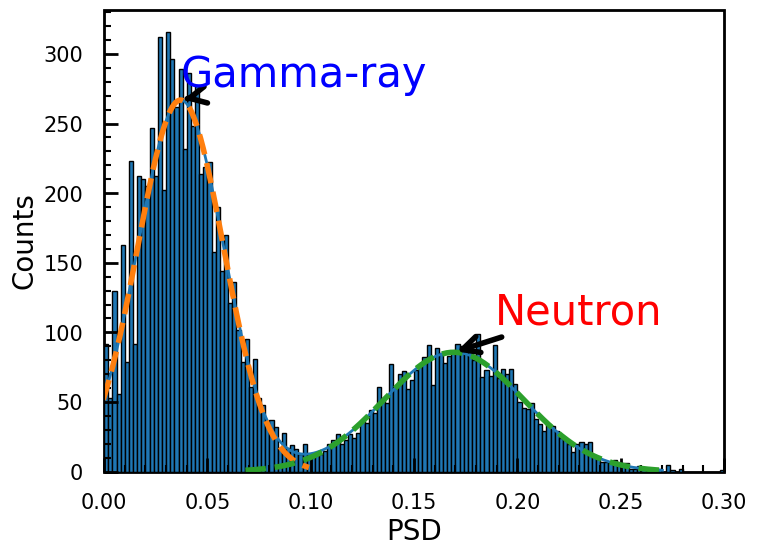

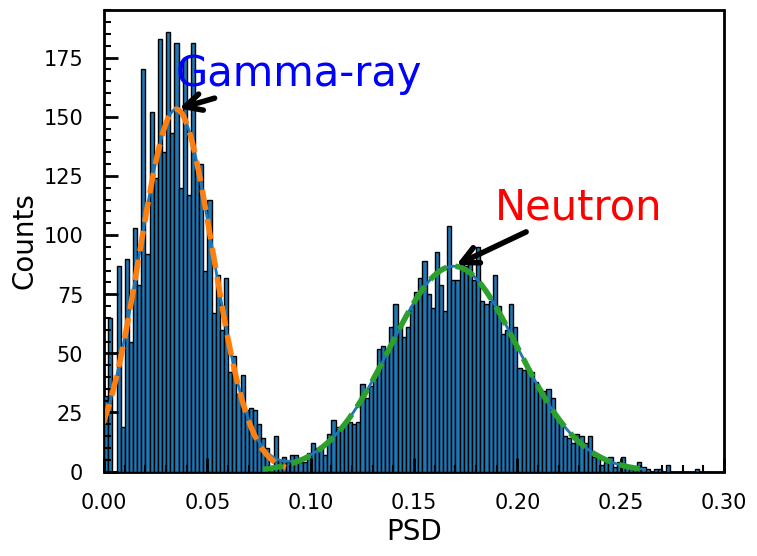

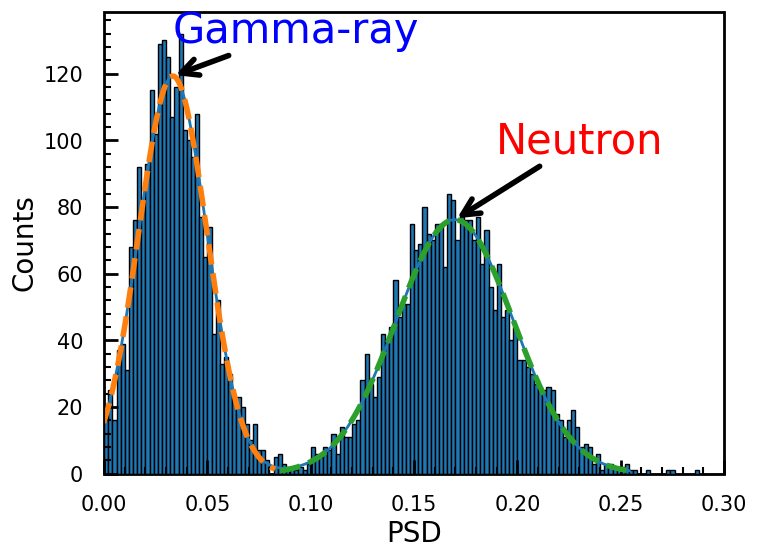

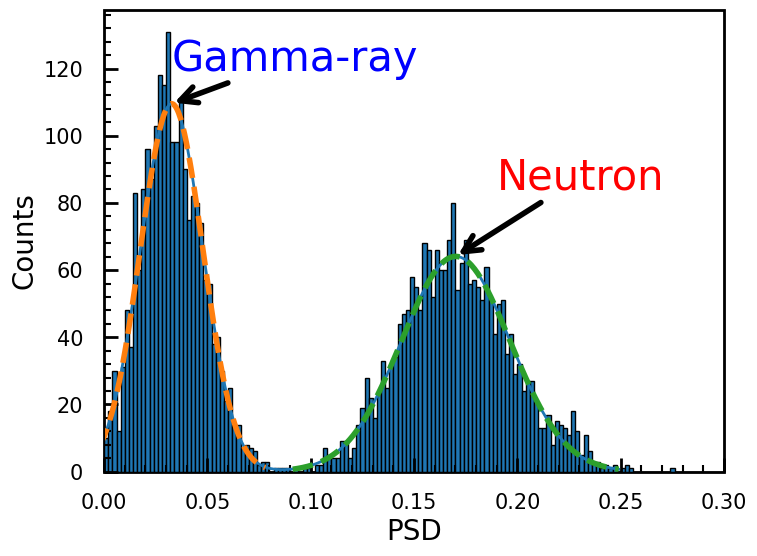

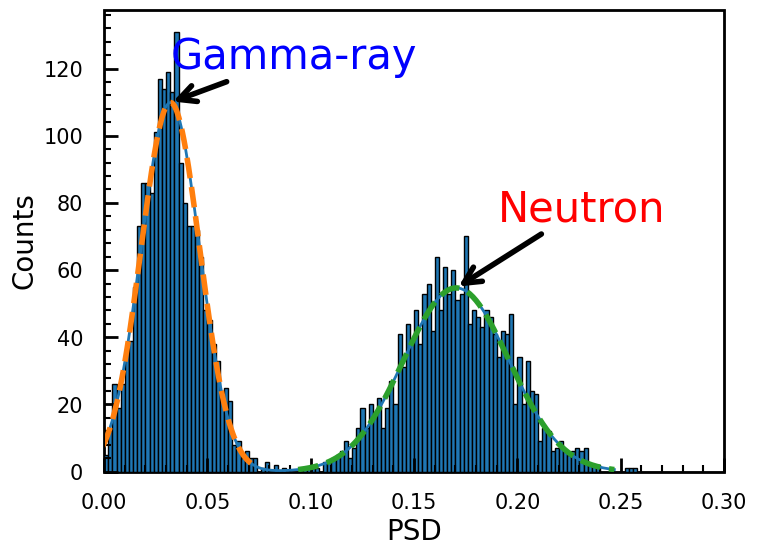

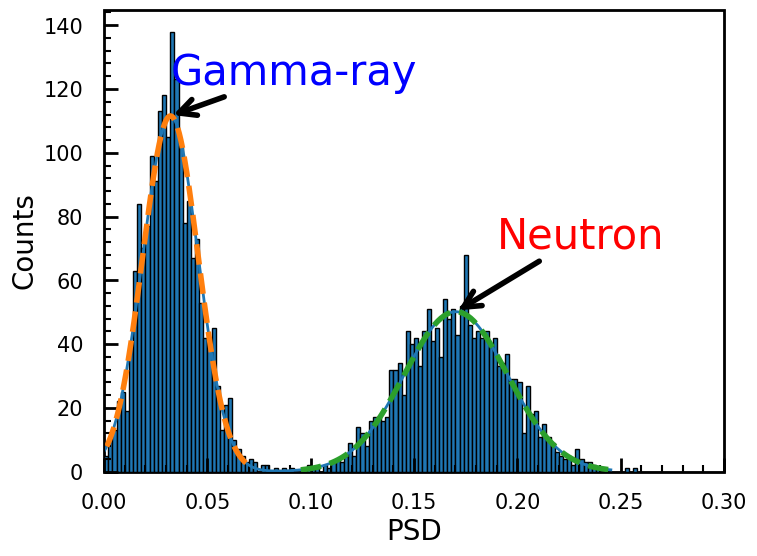

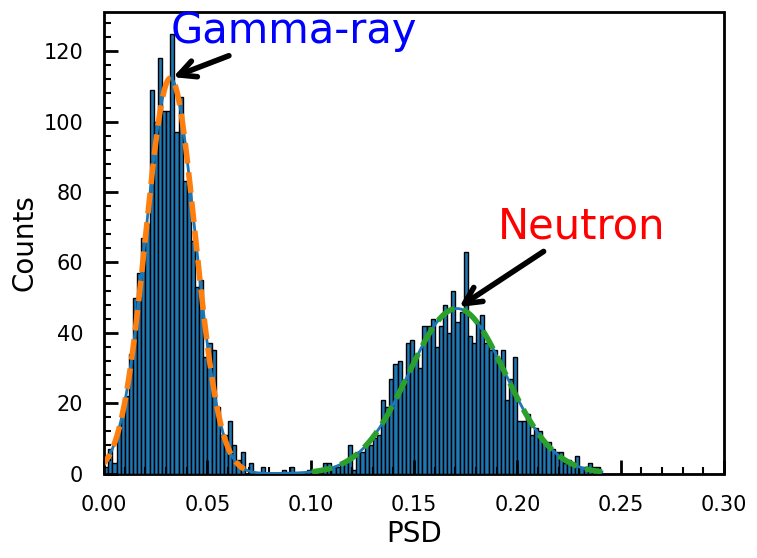

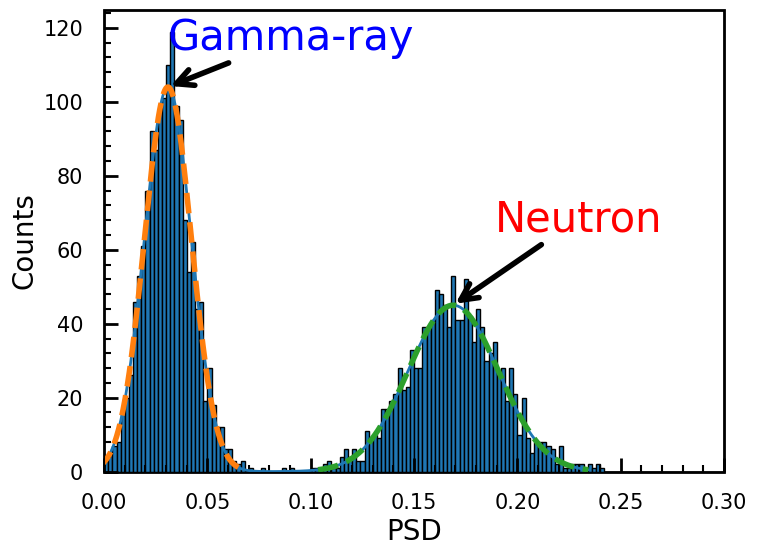

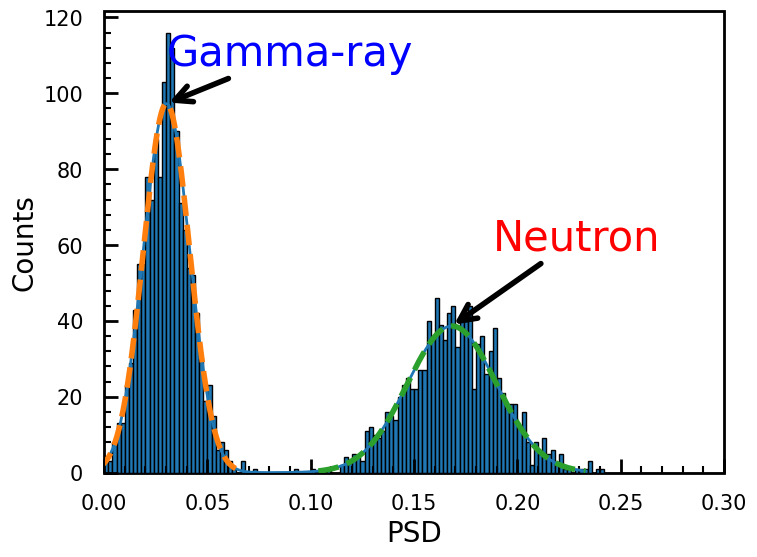

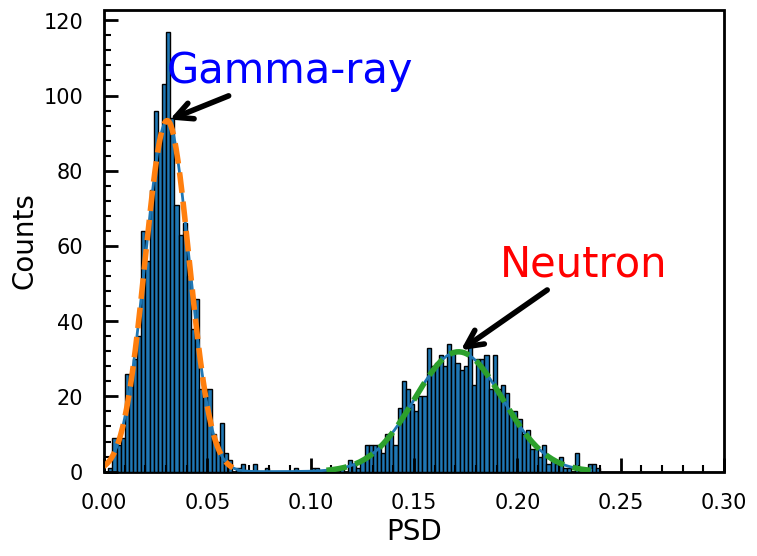

In [45]:
# Define the bins
bins = list(range(7, 18))

neutronDetectors = ["0-0", "0-4", "1-0", "1-2", "1-4"]
# Loop over bins
for i in range(len(bins) - 1):
    fig, ax = plt.subplots(figsize=(8, 8 * 0.75))

    #Axis ticks 
    ax.tick_params(which='major', direction='in', width=2, length=10, color='k', pad=15)
    ax.tick_params(which='minor', direction='in', width=1.5, length=5, color='k', pad=15)
    ax.xaxis.set_minor_locator(mtick.AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(mtick.AutoMinorLocator(5))
    ax.tick_params(labelsize=15)
    ax.patch.set_edgecolor('k')
    ax.patch.set_linewidth(2)
    hPSDee = inFile_extracted.Get("hPSDee_0-0")
    hPSDee_py = hPSDee.ProjectionY("hPSDee_py", bins[i], bins[i + 1])
        
    # Get bin contents and edges from the histogram
    bin_contents = [hPSDee_py.GetBinContent(j) for j in range(1, hPSDee_py.GetNbinsX() + 1)]
    bin_centers = [hPSDee_py.GetBinCenter(j) for j in range(1, hPSDee_py.GetNbinsX() + 1)]
    bin_error = [hPSDee_py.GetBinError(j) for j in range(1, hPSDee_py.GetNbinsX() + 1)]
    bin_edges = [hPSDee_py.GetBinLowEdge(j) for j in range(1, hPSDee_py.GetNbinsX() + 2)]

    bin_centers = np.array(bin_centers)
    bin_contents = np.array(bin_contents)
    bin_error = np.array(bin_error)

    mask1 = bin_centers > 0.0
    bin_centers_masked1 = bin_centers[mask1]
    bin_contents_masked1 = bin_contents[mask1]
    bin_error_masked1 = bin_error[mask1]
    mask2 = bin_centers_masked1 < 0.3
    bin_centers_masked = bin_centers_masked1[mask2]
    bin_contents_masked = bin_contents_masked1[mask2]
    bin_error_masked = bin_error_masked1[mask2]
    mask3 = bin_contents_masked > 0
    bin_contents_masked_pos = bin_contents_masked[mask3]
    bin_centers_masked_pos = bin_centers_masked[mask3]
    bin_error_masked_pos = bin_error_masked[mask3]

    fsigma = 3
    binwidth = hPSDee_py.GetBinWidth(1)
    norm1_low = np.min(bin_contents_masked)
    norm2_low = np.min(bin_contents_masked)
    norm1_high = np.max(bin_contents_masked)
    norm2_high = np.max(bin_contents_masked)
    mean1_low = 0.02
    mean1_high = 0.05
    mean2_low = 0.15
    mean2_high = 0.2
    bounds = ([norm1_low, 0.01, 0.0001, norm2_low, 0.1, 0.0001], [norm1_high, 0.06, 0.2, norm2_high, 0.2, 0.5])
    popt, pcov = curve_fit(fitFunc, bin_centers_masked_pos, bin_contents_masked_pos, bounds=bounds, sigma=bin_error_masked_pos)

    x1 = np.linspace(popt[1] - fsigma * popt[2], popt[1] + fsigma * popt[2], 200)
    x2 = np.linspace(popt[4] - fsigma * popt[5], popt[4] + fsigma * popt[5], 200)
    x = np.linspace(popt[1] - fsigma * popt[2], popt[4] + fsigma * popt[5], 400)
    y = fitFunc(x, *popt)
    perr = np.sqrt(np.diag(pcov))
    y1 = gaussian1(x1, popt[0], popt[1], popt[2])
    y2 = gaussian2(x2, popt[3], popt[4], popt[5])

    gamma_high = popt[1] + fsigma * popt[2]
    gamma_upper_band.append(gamma_high)
        
    gamma_low = popt[1] - fsigma * popt[2]
    gamma_lower_band.append(gamma_low)
        
    neutron_low = popt[4] - fsigma * popt[5]
    neutron_lower_band.append(neutron_low)
        
    neutron_high = popt[4] + fsigma * popt[5]
    neutron_upper_band.append(neutron_high)

    plt.bar(bin_edges[:-1], bin_contents, width=np.diff(bin_edges), align='edge', edgecolor='black')
    plt.plot(x, y, label="Fit", linewidth=2)
    plt.plot(x1, y1, label="Gaussian1: Norm=%5.3f ± %5.3f, Mean=%5.3f ± %5.3f, sigma=%5.3f ± %5.3f" % (popt[0], perr[0], popt[1], perr[1], popt[2], perr[2]), linewidth=4, linestyle="--")
    plt.plot(x2, y2, label="Gaussian2: Norm=%5.3f ± %5.3f, Mean=%5.3f ± %5.3f, sigma=%5.3f ± %5.3f" % (popt[3], perr[3], popt[4], perr[4], popt[5], perr[5]), linewidth=4, linestyle="--")

    #legend_properties = {'size': 20}
    #leg = plt.legend(fontsize=10, bbox_to_anchor=(0.8, 1), loc="upper right")
    #leg.get_frame().set_edgecolor('k')
    #leg.get_frame().set_linewidth(2.0)

    plt.ylabel('Counts',fontsize=20)
    plt.xlabel('PSD',fontsize=20)
    plt.xlim(0,0.3)
    # Annotate gamma-ray peak
    ax.annotate(
        "Gamma-ray", 
        xy=(popt[1], max(y1)), 
        xytext=(popt[1] - 0.0001, max(y1) + 10), 
        arrowprops=dict(facecolor='blue', arrowstyle='->',lw=4), 
        fontsize=30, color='blue'
    )
    

    # Annotate neutron peak
    ax.annotate(
        "Neutron", 
        xy=(popt[4], max(y2)), 
        xytext=(popt[4] + 0.02, max(y2) + 20), 
        arrowprops=dict(facecolor='red', arrowstyle='->',lw=4), 
        fontsize=30, color='red'
    )
    
    #plt.title(f"Detector: {detector_id}, bin:{bins[i]} -> bin:{bins[i + 1]}")
    #plt.legend()
    plt.savefig("psd_plots/y_projection_bin_%d.png" %(i), dpi=400, bbox_inches='tight')
    plt.show()

In [12]:
# Loop through all neutron detectors and process each one
#neutronDetectors = ["0-0"]
#for detector in neutronDetectors:
    #process_detector(detector)

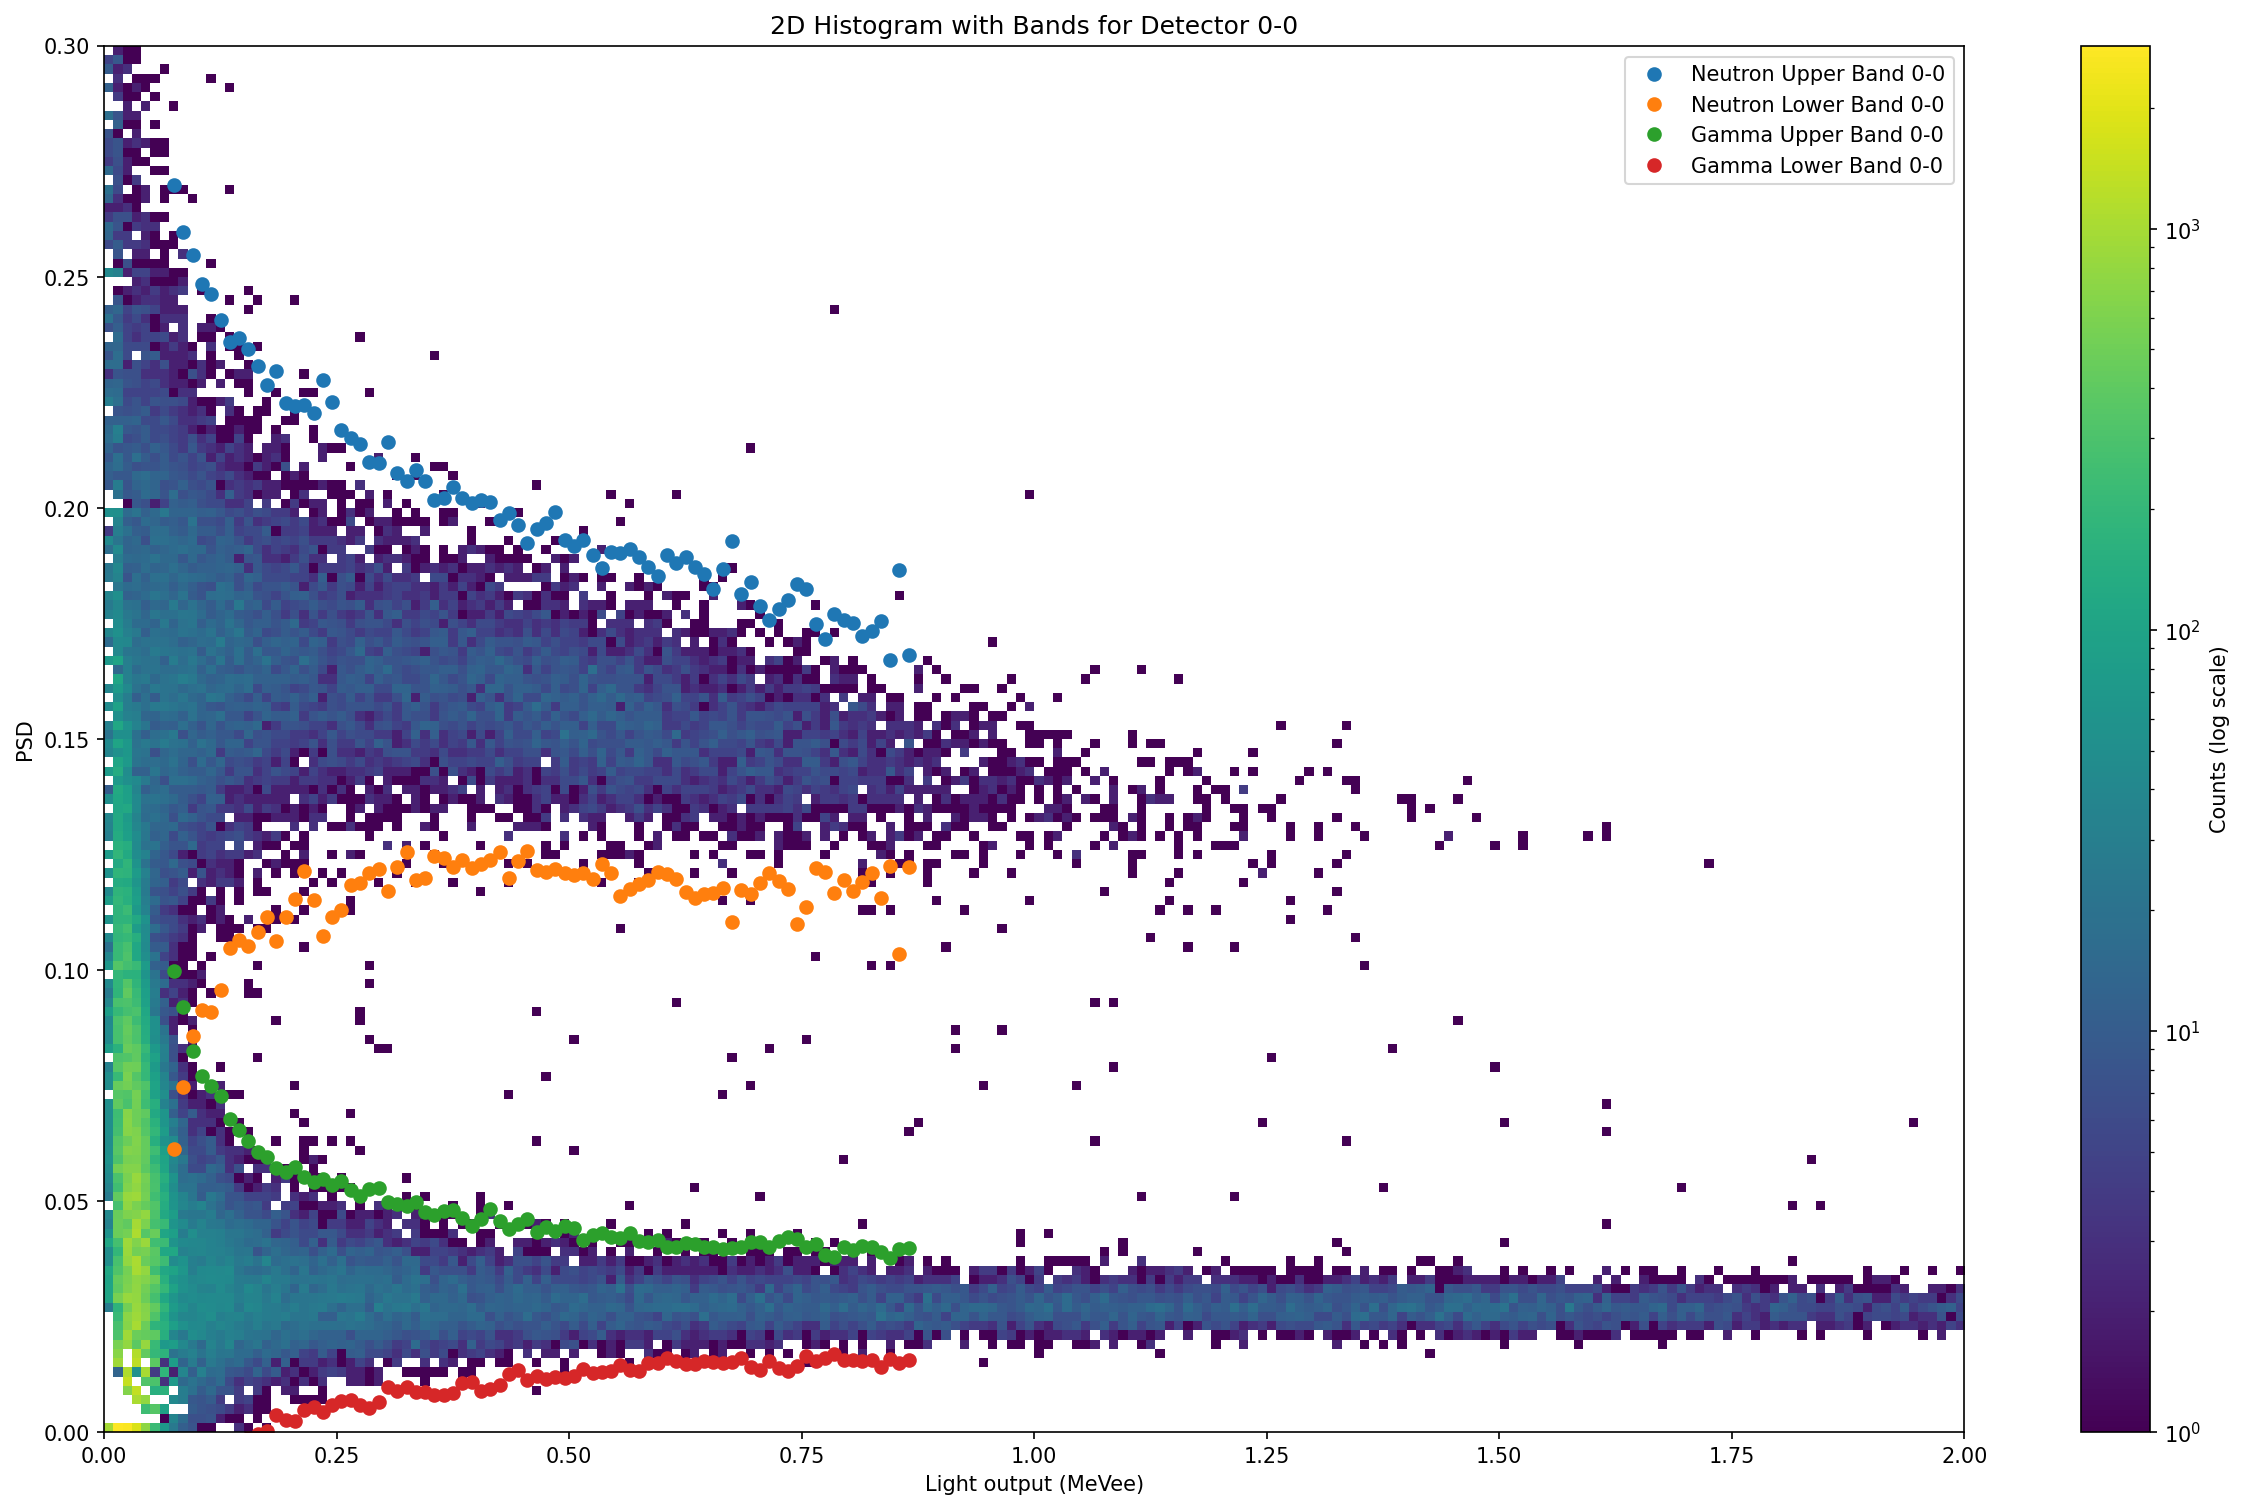

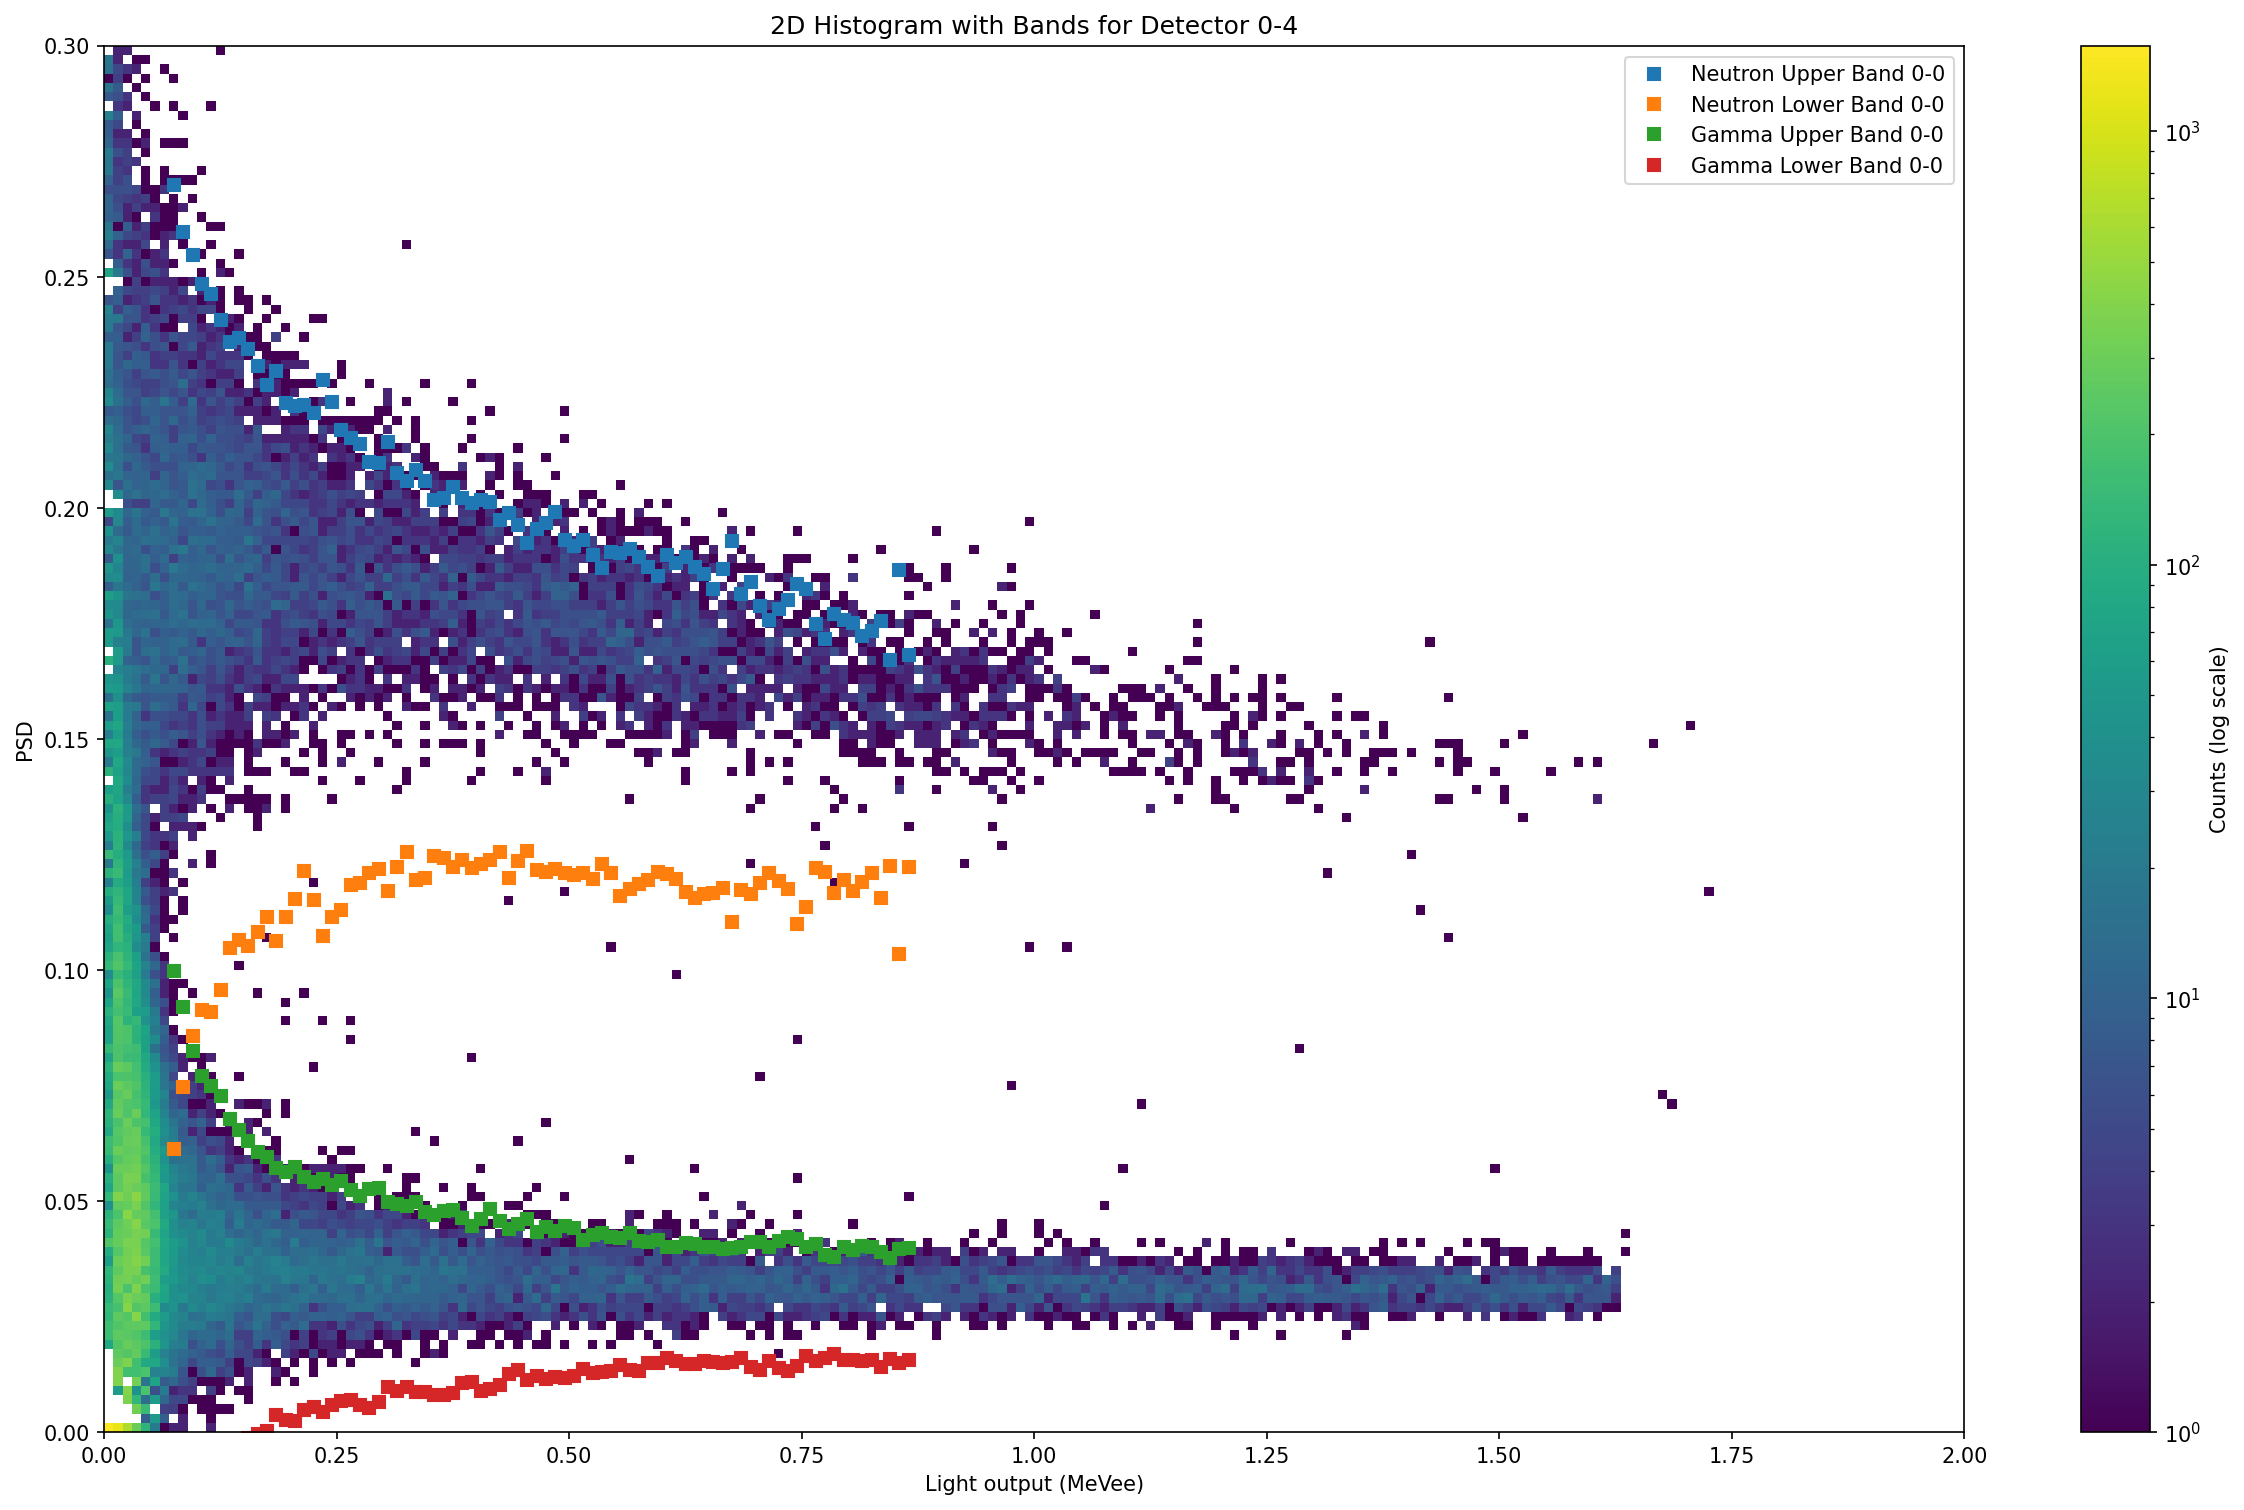

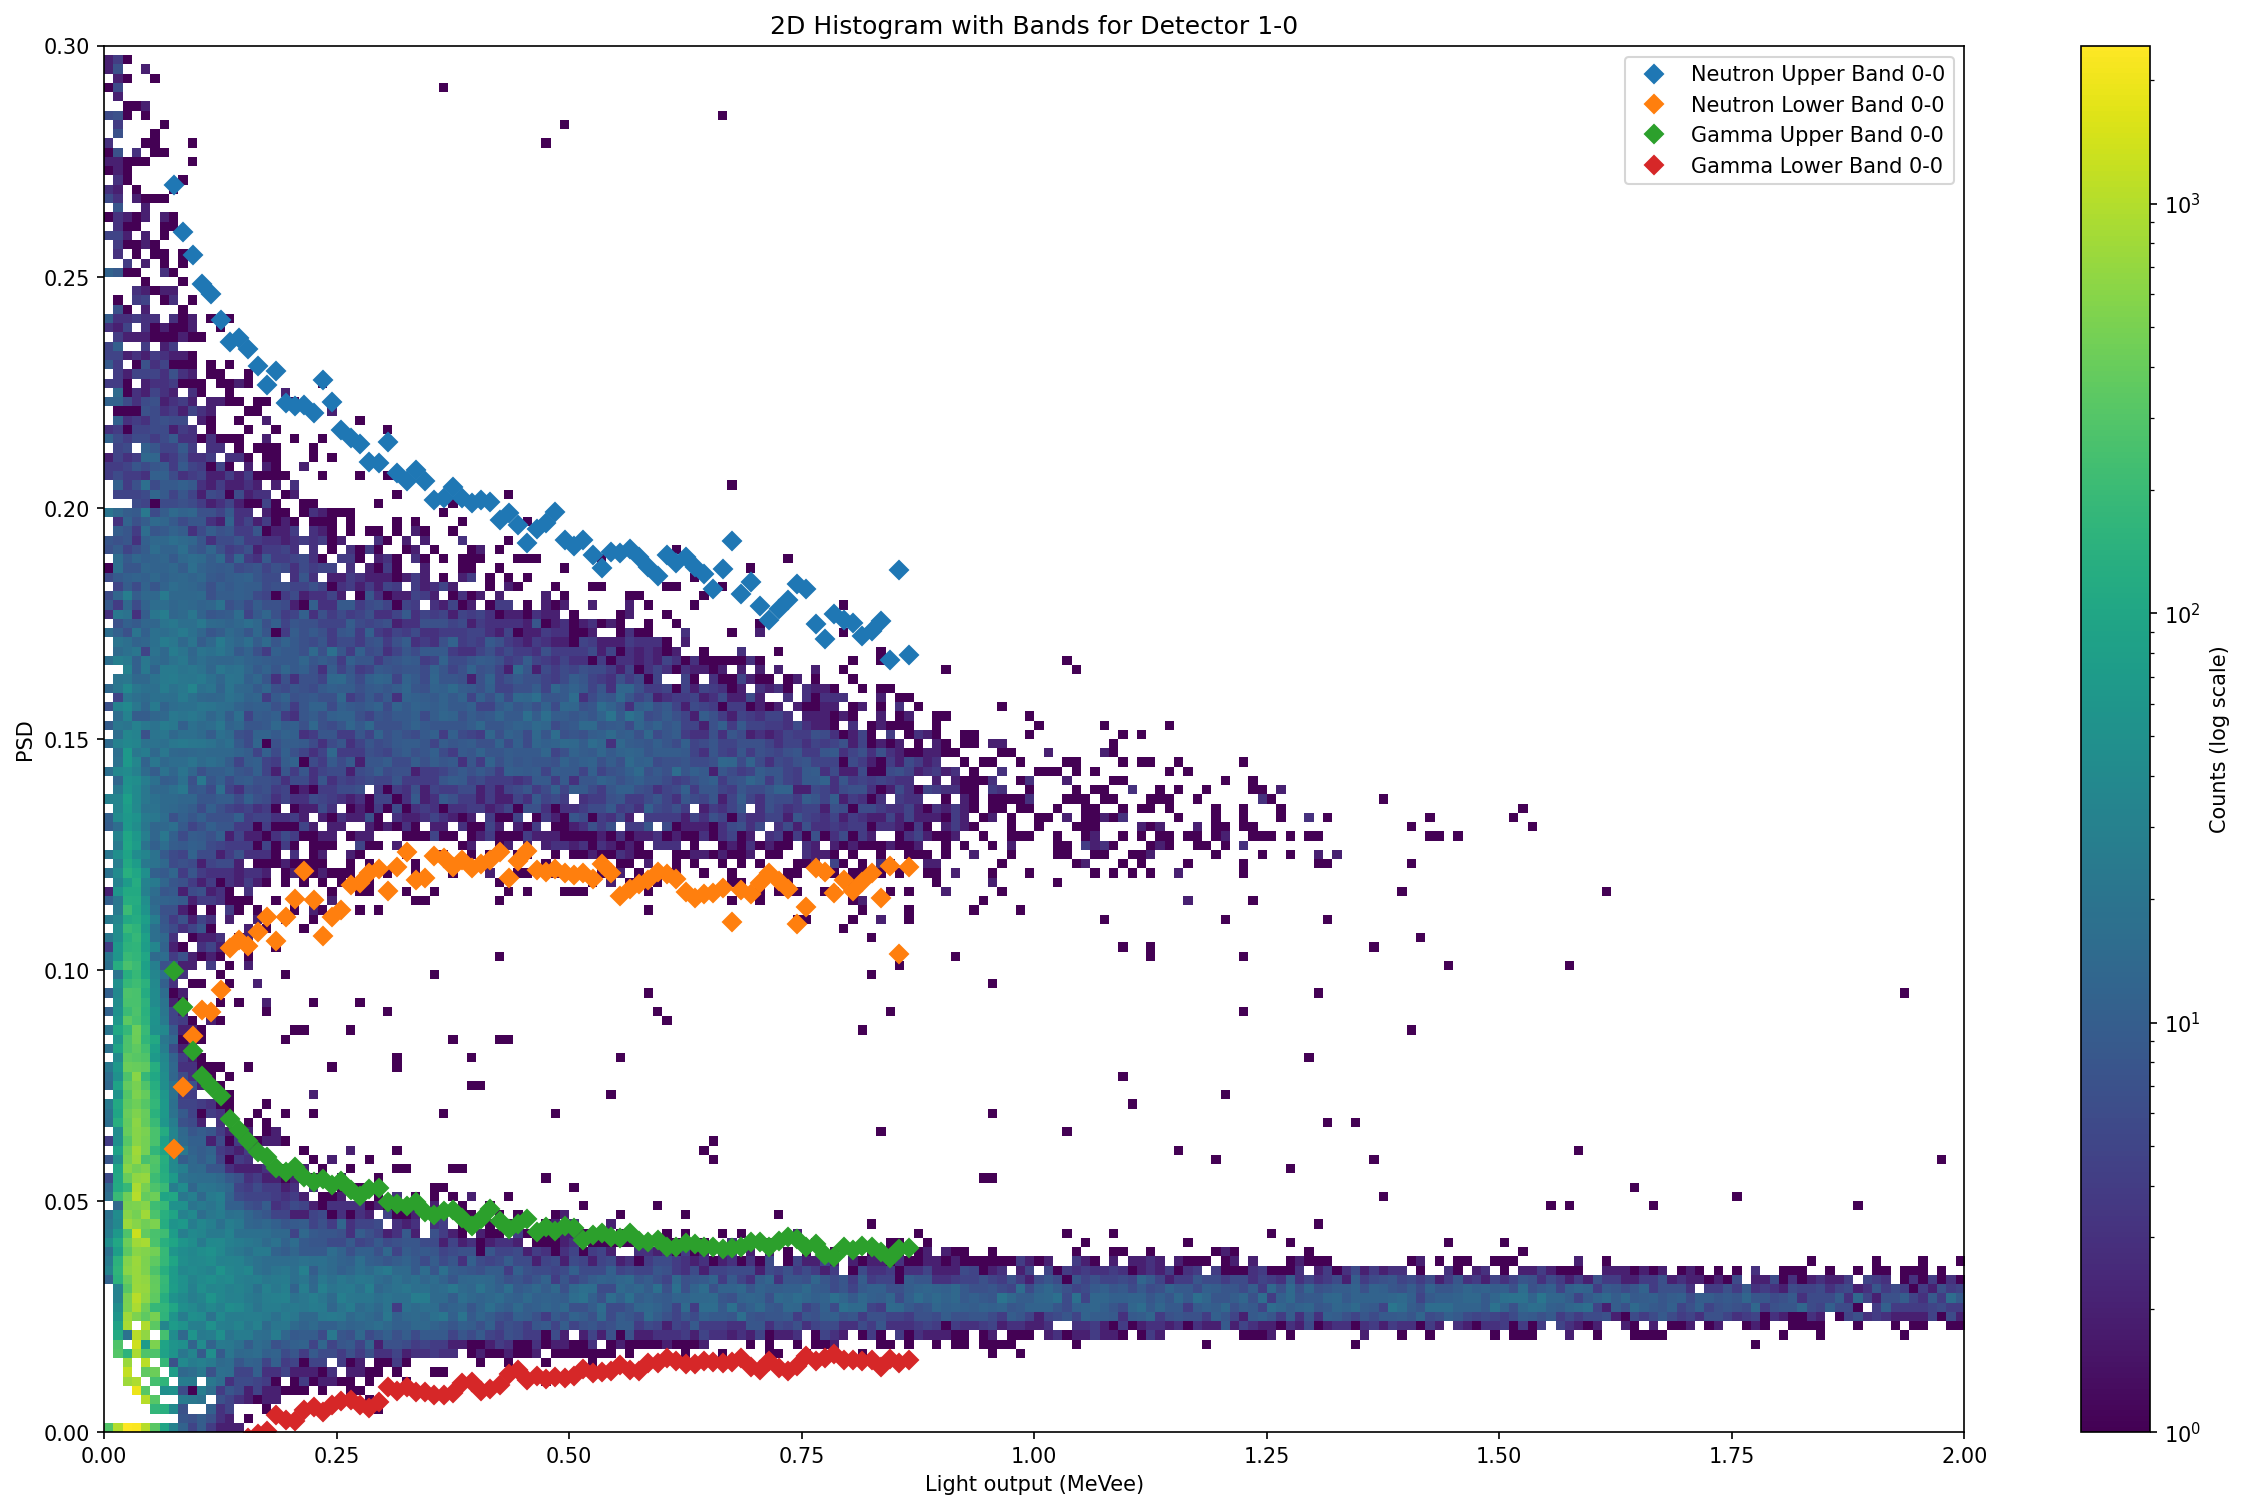

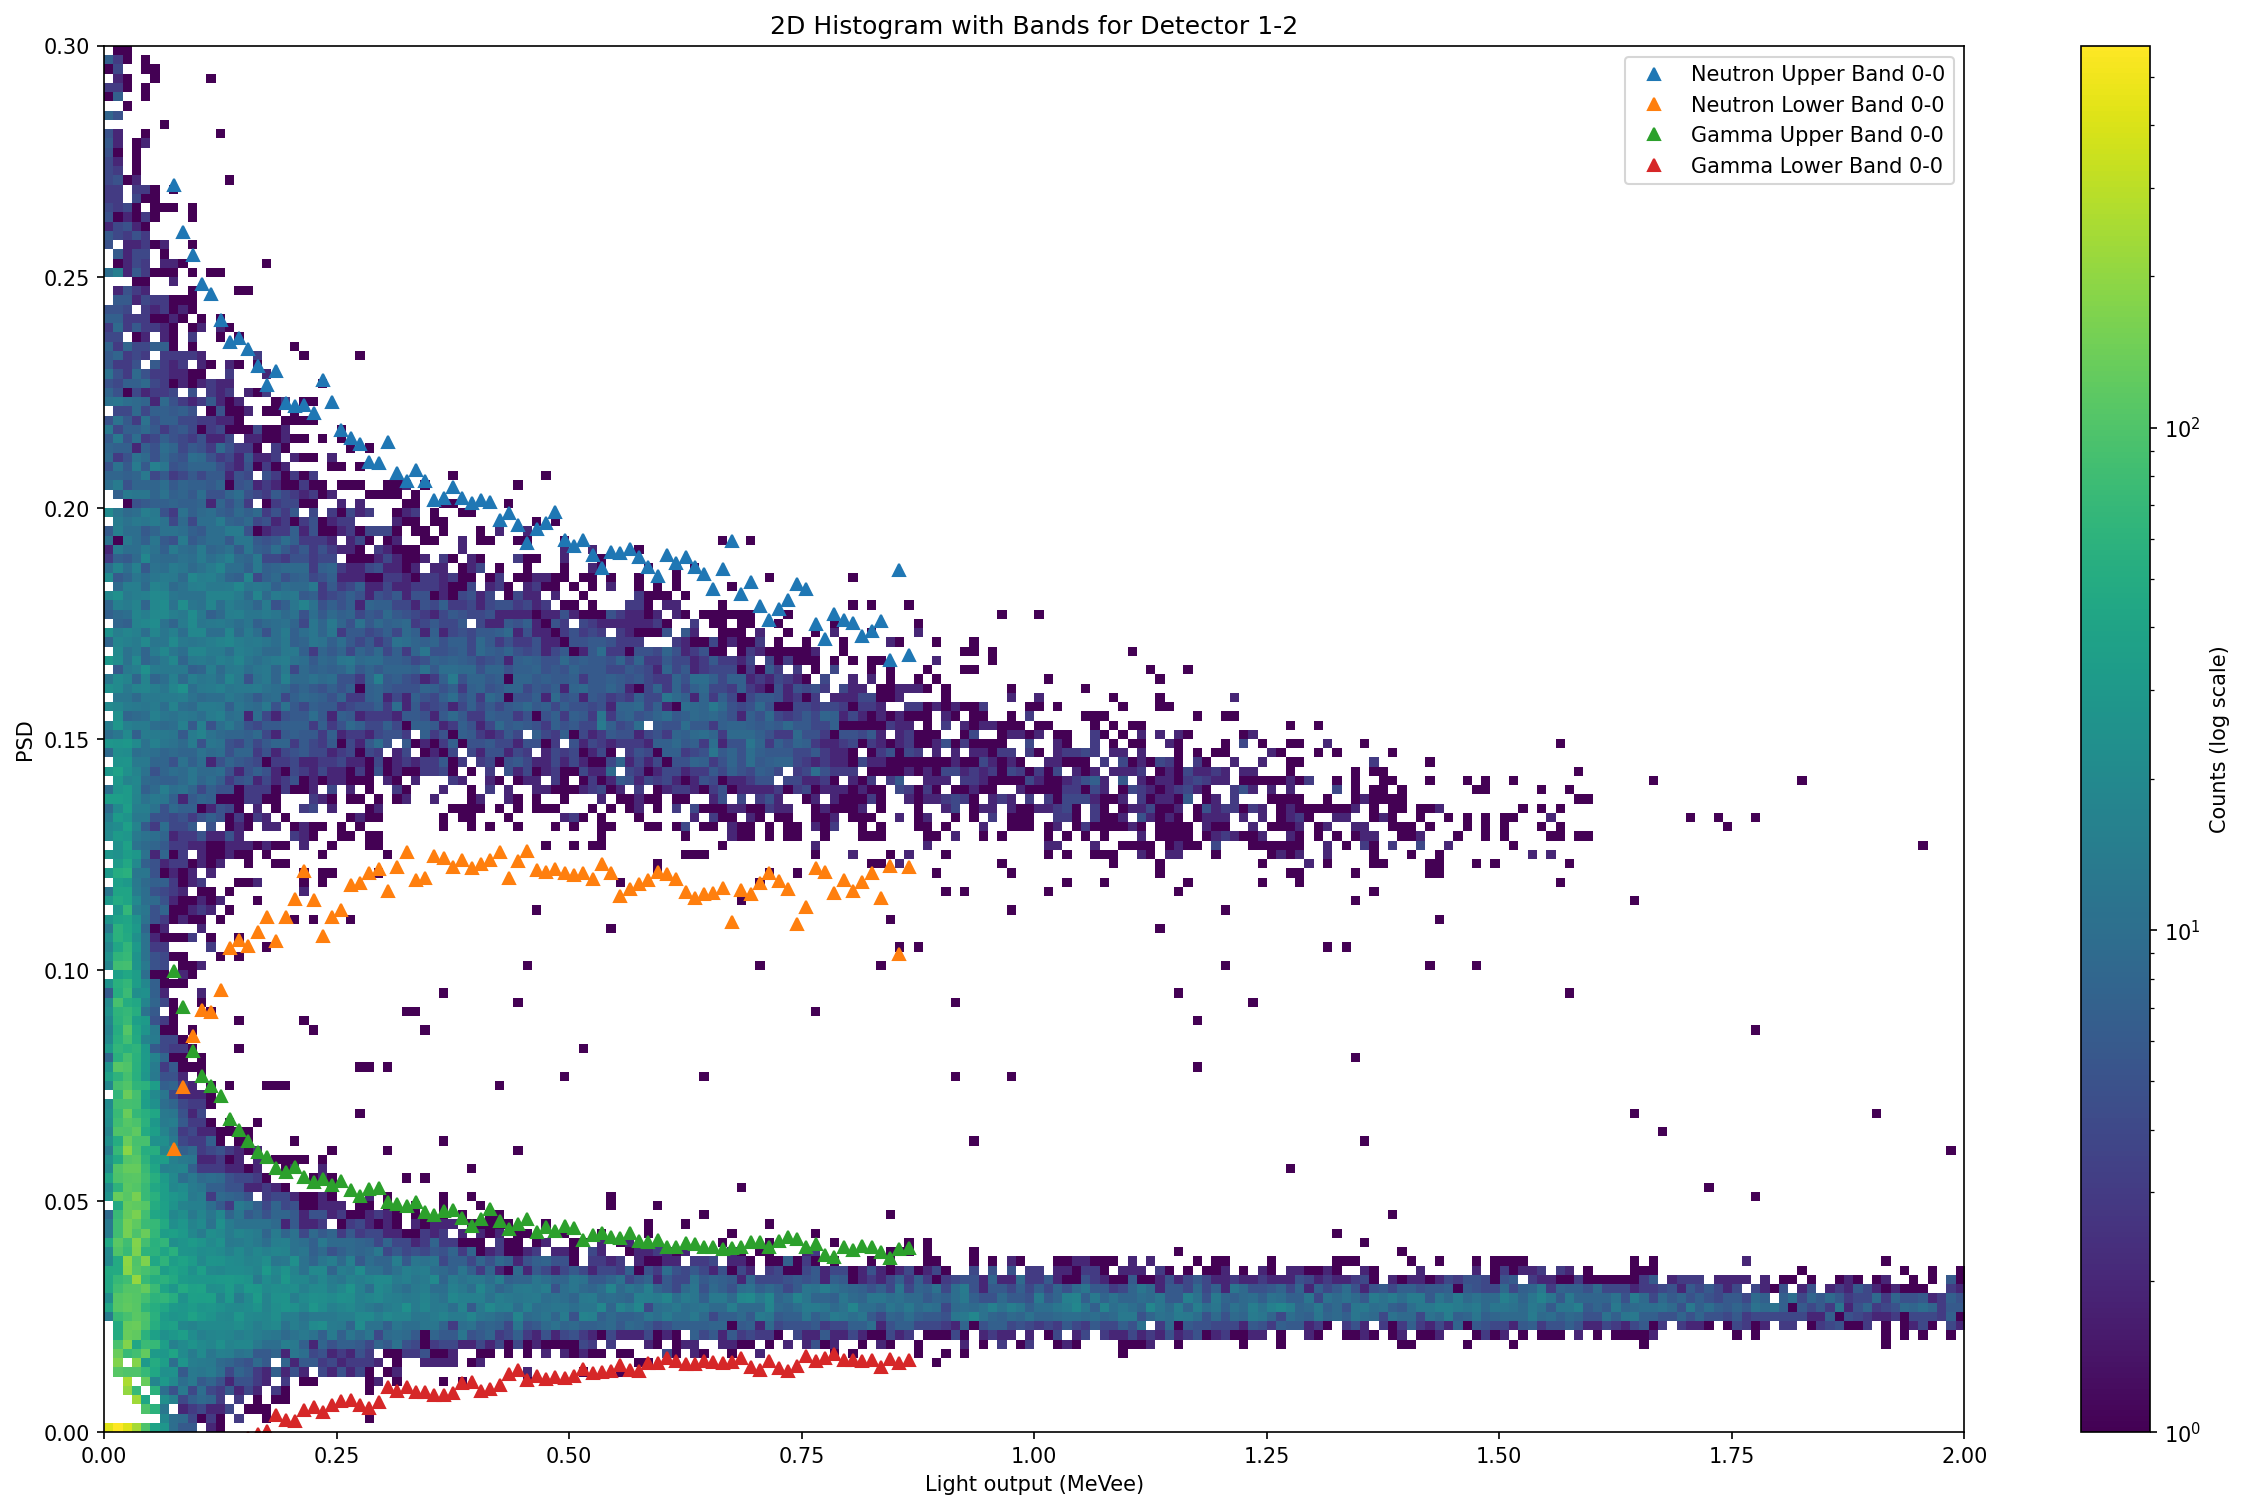

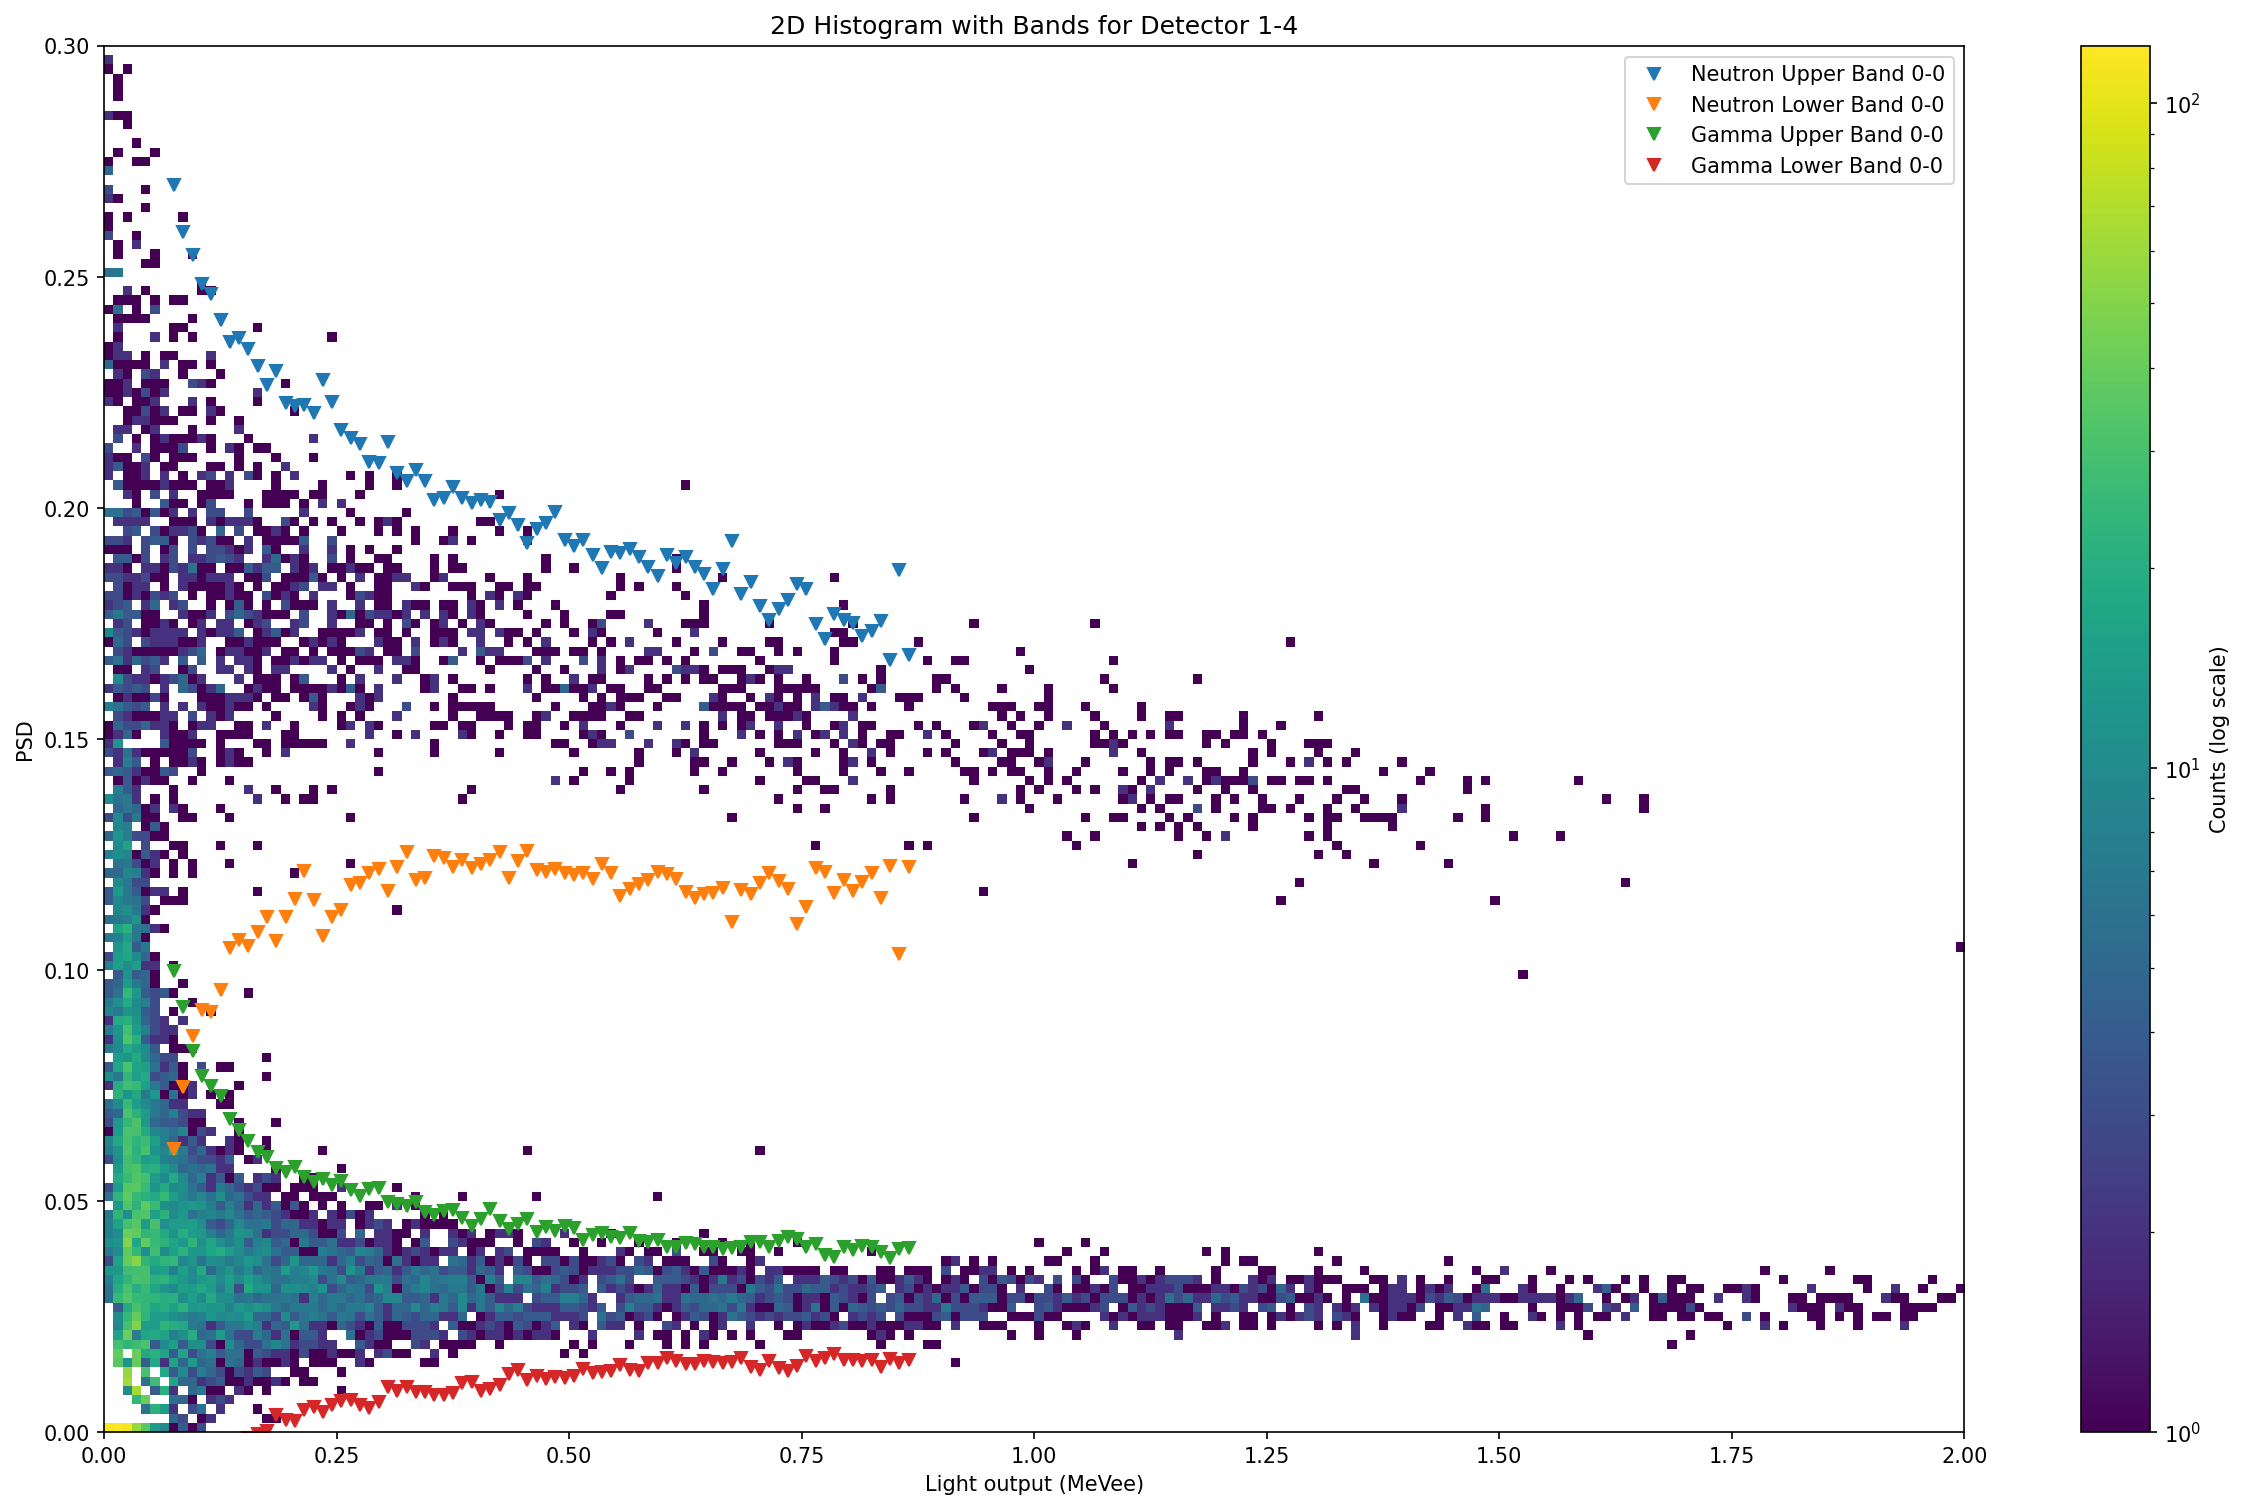

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import json
import ROOT
from matplotlib.colors import LogNorm

# Define the bins
bins = list(range(7, 88))
L = [(bins[i] + bins[i + 1]) / 2.0 for i in range(len(bins) - 1)]
L = np.array(L) * 0.01

# Read band data from the JSON file for detector 0-0
with open("bands_detector/bands_detector_0-0.json", "r") as infile:
    bands_data = json.load(infile)

neutron_upper_band = bands_data["neutron_upper_band"]
neutron_lower_band = bands_data["neutron_lower_band"]
gamma_upper_band = bands_data["gamma_upper_band"]
gamma_lower_band = bands_data["gamma_lower_band"]

# Open the ROOT file
inFile_extracted = ROOT.TFile("/Users/shahinashahina/Documents/PhD/Experiments/25Mg(a,n)/CAMPAIGN_2018/25Mg_CAMPAIGN_2018/neutron_data/scripts_python2/ExtractNeutronSpectra_data/run_0234.root")

# Plotting
neutronDetectors = ["0-0", "0-4", "1-0", "1-2", "1-4"]
markers = ['o', 's', 'D', '^', 'v']  # Different markers for each detector

for i, detector in enumerate(neutronDetectors):
    # Get the histogram for the current detector
    hPSDee = inFile_extracted.Get(f"hPSDee_{detector}")

    # Extract histogram data
    n_bins_x = hPSDee.GetNbinsX()
    n_bins_y = hPSDee.GetNbinsY()
    x_edges = [hPSDee.GetXaxis().GetBinLowEdge(i) for i in range(1, n_bins_x + 2)]
    y_edges = [hPSDee.GetYaxis().GetBinLowEdge(i) for i in range(1, n_bins_y + 2)]
    hist_2d = np.array([[hPSDee.GetBinContent(i, j) for j in range(1, n_bins_y + 1)] for i in range(1, n_bins_x + 1)])

    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    fig.set_dpi(150)
    fig.set_size_inches(20, 12)

    # Plot the 2D histogram using Matplotlib's imshow
    plt.imshow(hist_2d.T, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto', origin='lower', norm=LogNorm())
    plt.colorbar(label='Counts (log scale)')
    plt.xlabel('Light output (MeVee)')
    plt.ylabel("PSD")
    plt.xlim(0, 2)
    plt.ylim(0, 0.3)
    plt.title(f'2D Histogram with Bands for Detector {detector}')

    # Plot the bands from detector 0-0
    plt.plot(L, neutron_upper_band, markers[i], label="Neutron Upper Band 0-0")
    plt.plot(L, neutron_lower_band, markers[i], label="Neutron Lower Band 0-0")
    plt.plot(L, gamma_upper_band, markers[i], label="Gamma Upper Band 0-0")
    plt.plot(L, gamma_lower_band, markers[i], label="Gamma Lower Band 0-0")

    plt.legend()
    plt.show()



/var/folders/qw/p_mf6hf51f722q609jcqbdmw0000gn/T/ipykernel_6074/2353044895.py:10: RuntimeWarning: divide by zero encountered in divide
  return a/(np.sqrt(x)) + b*x +c


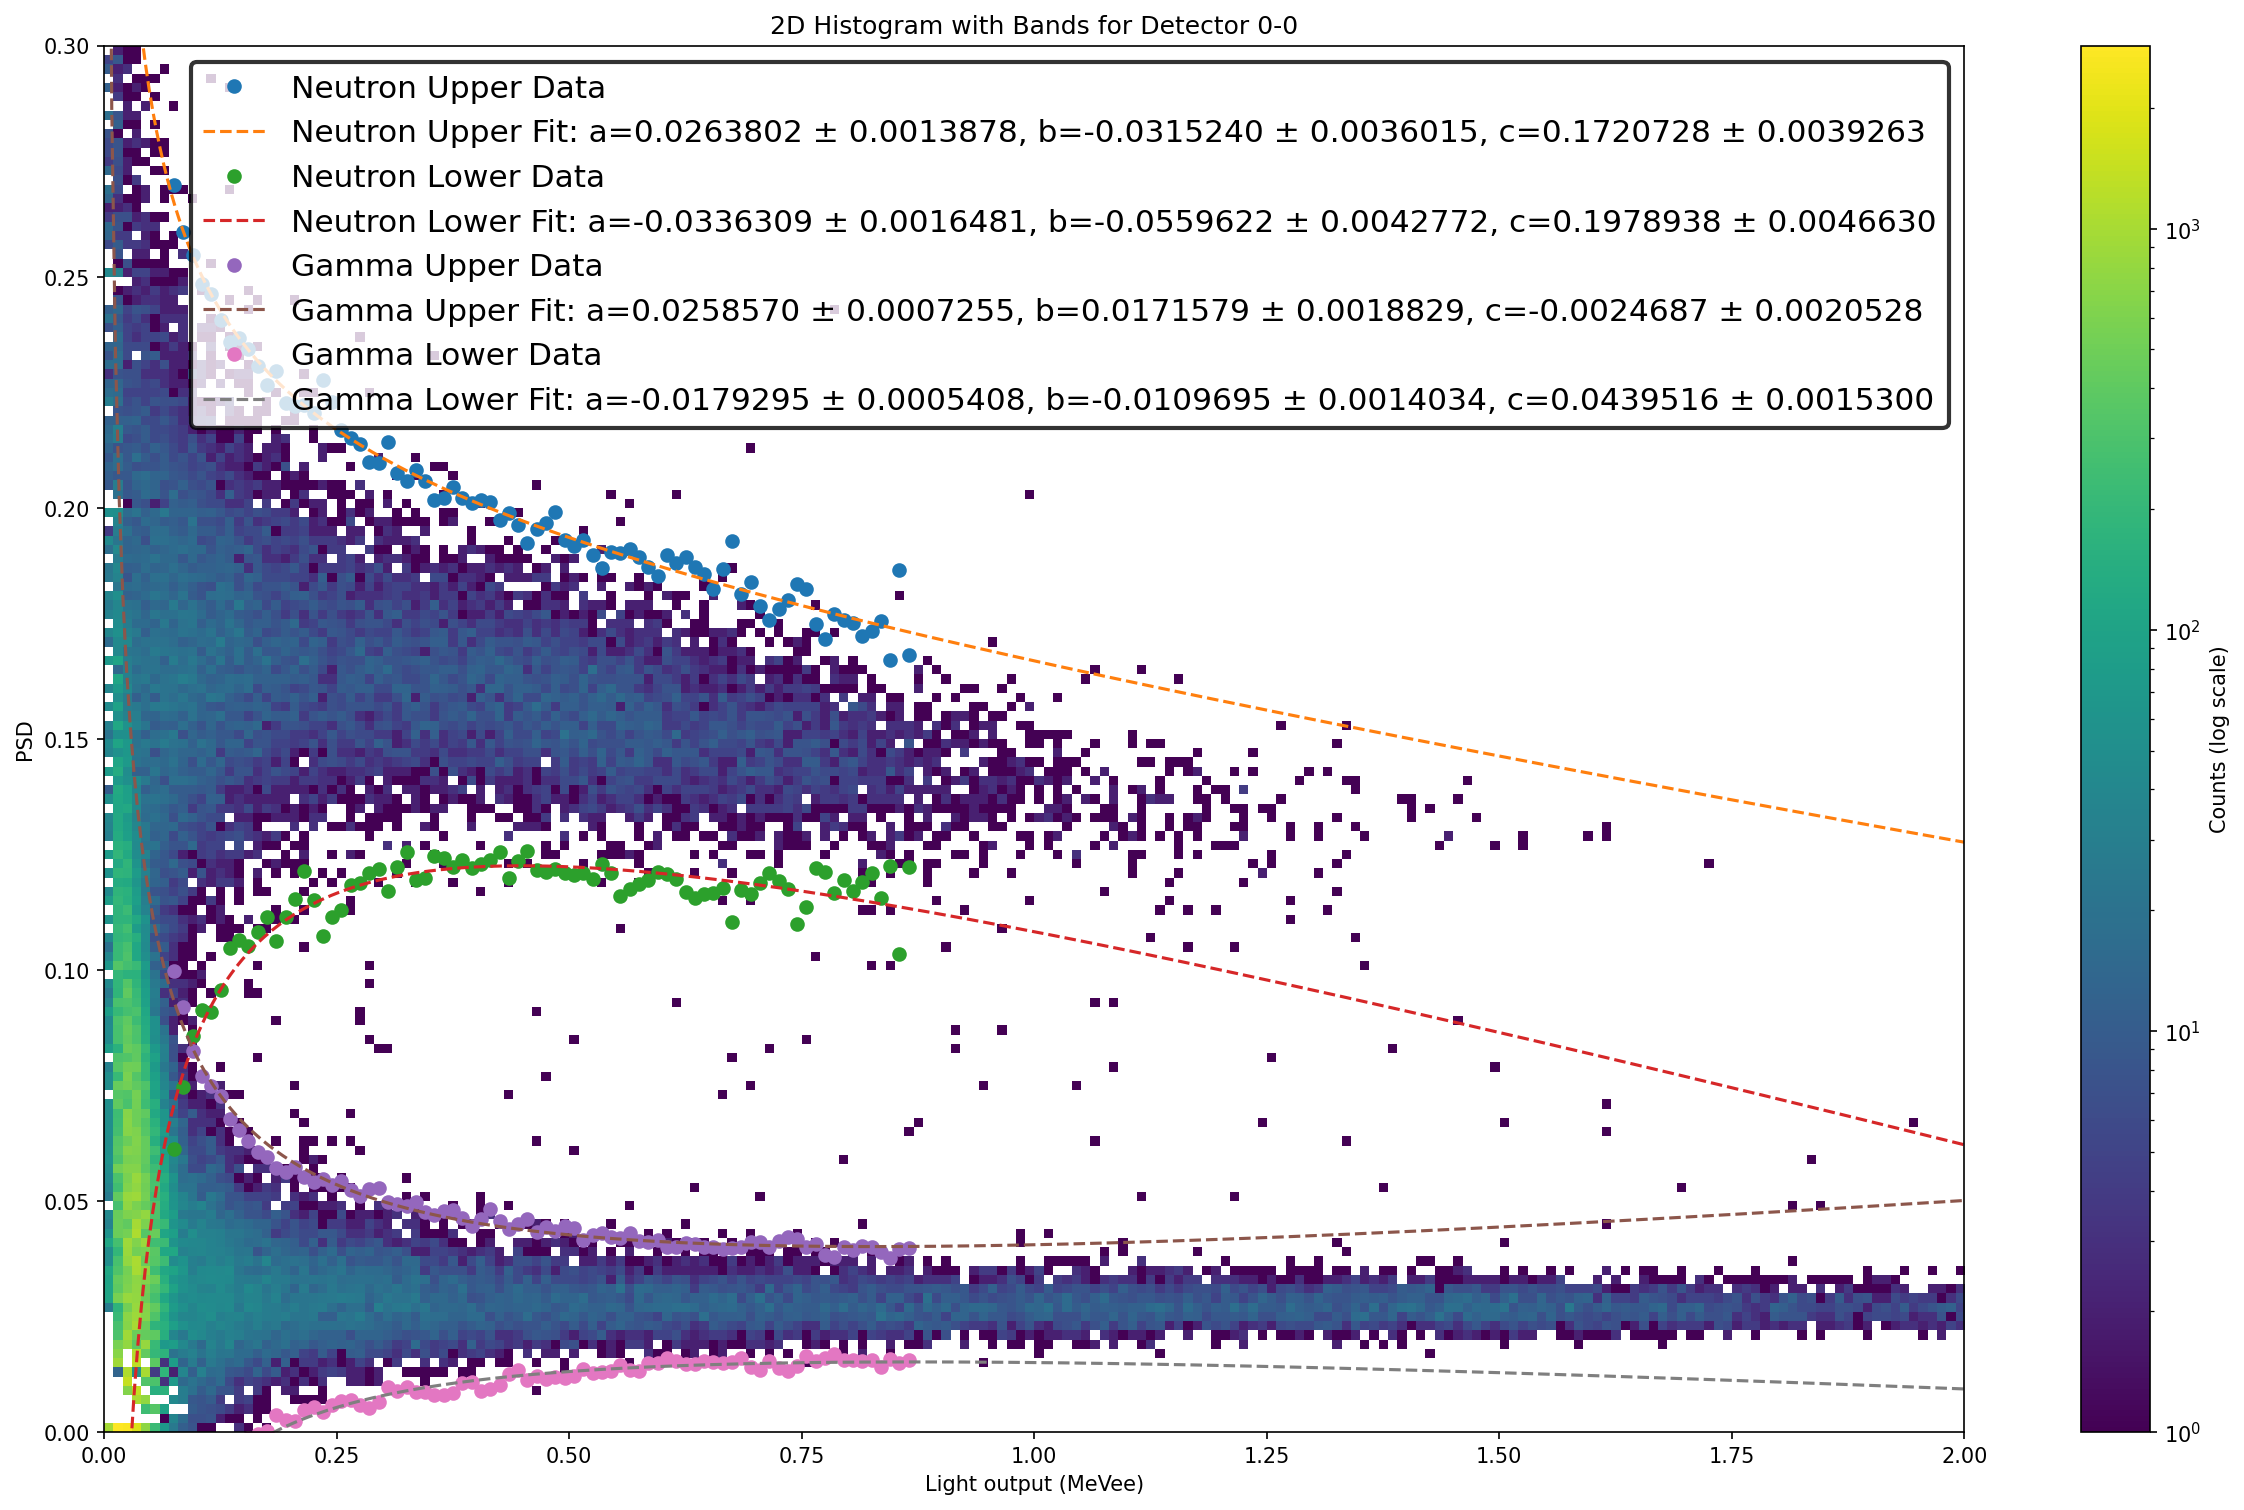

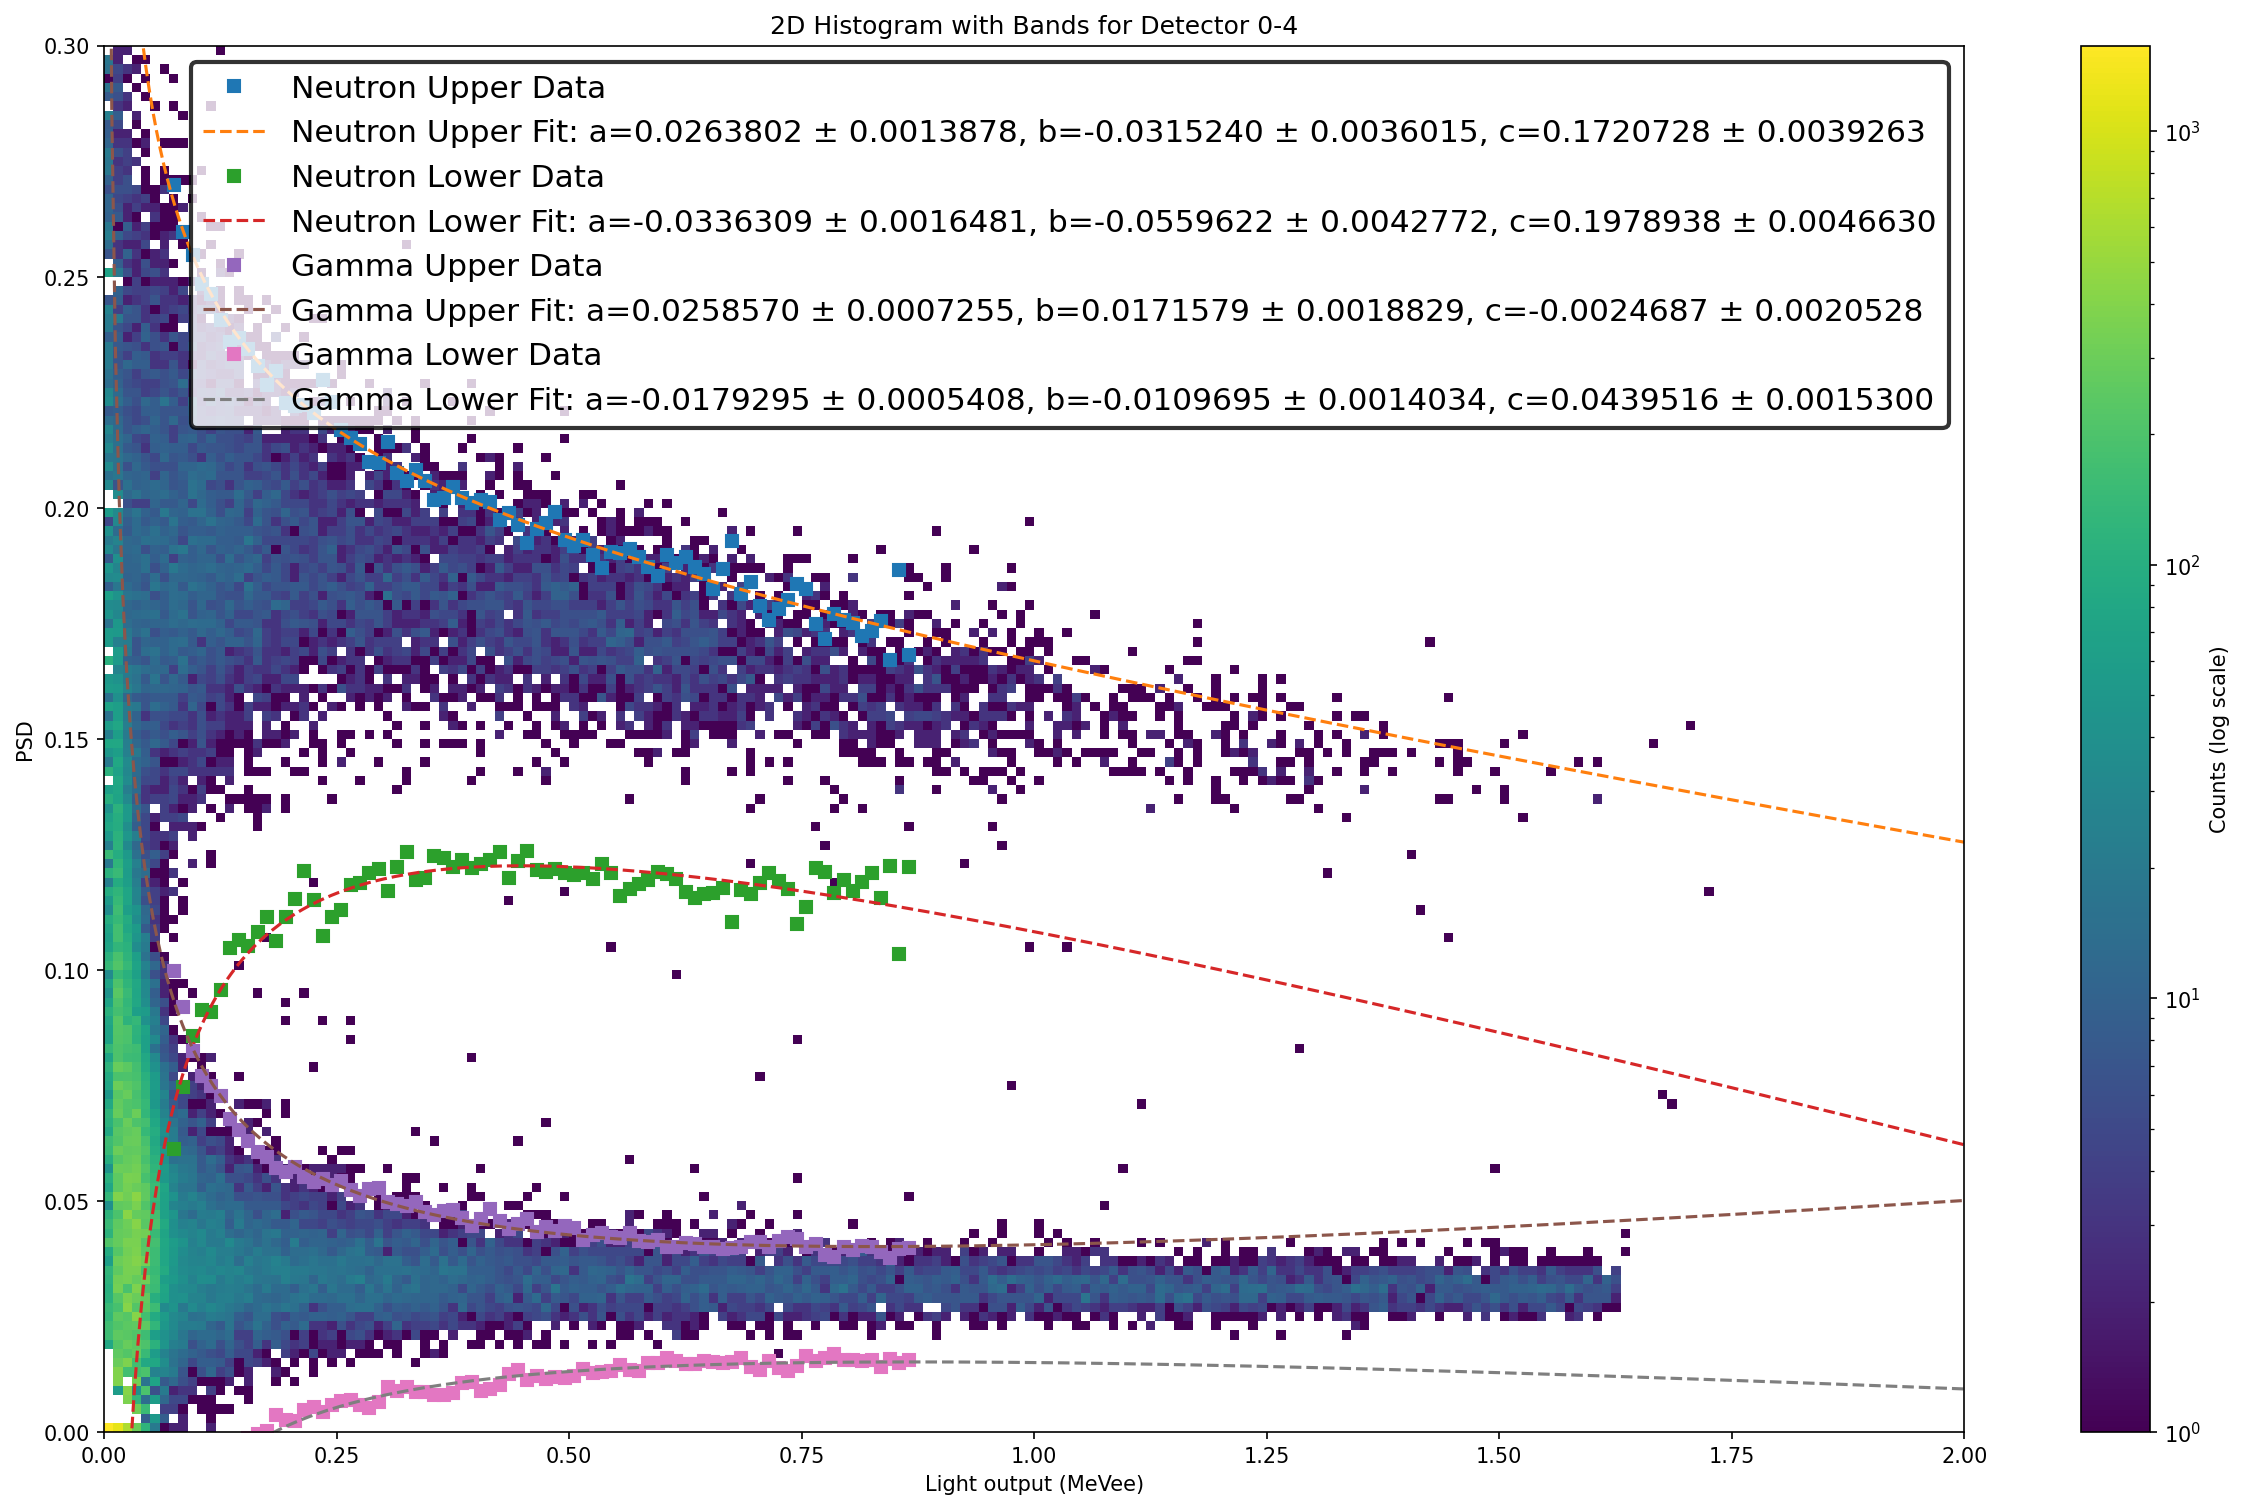

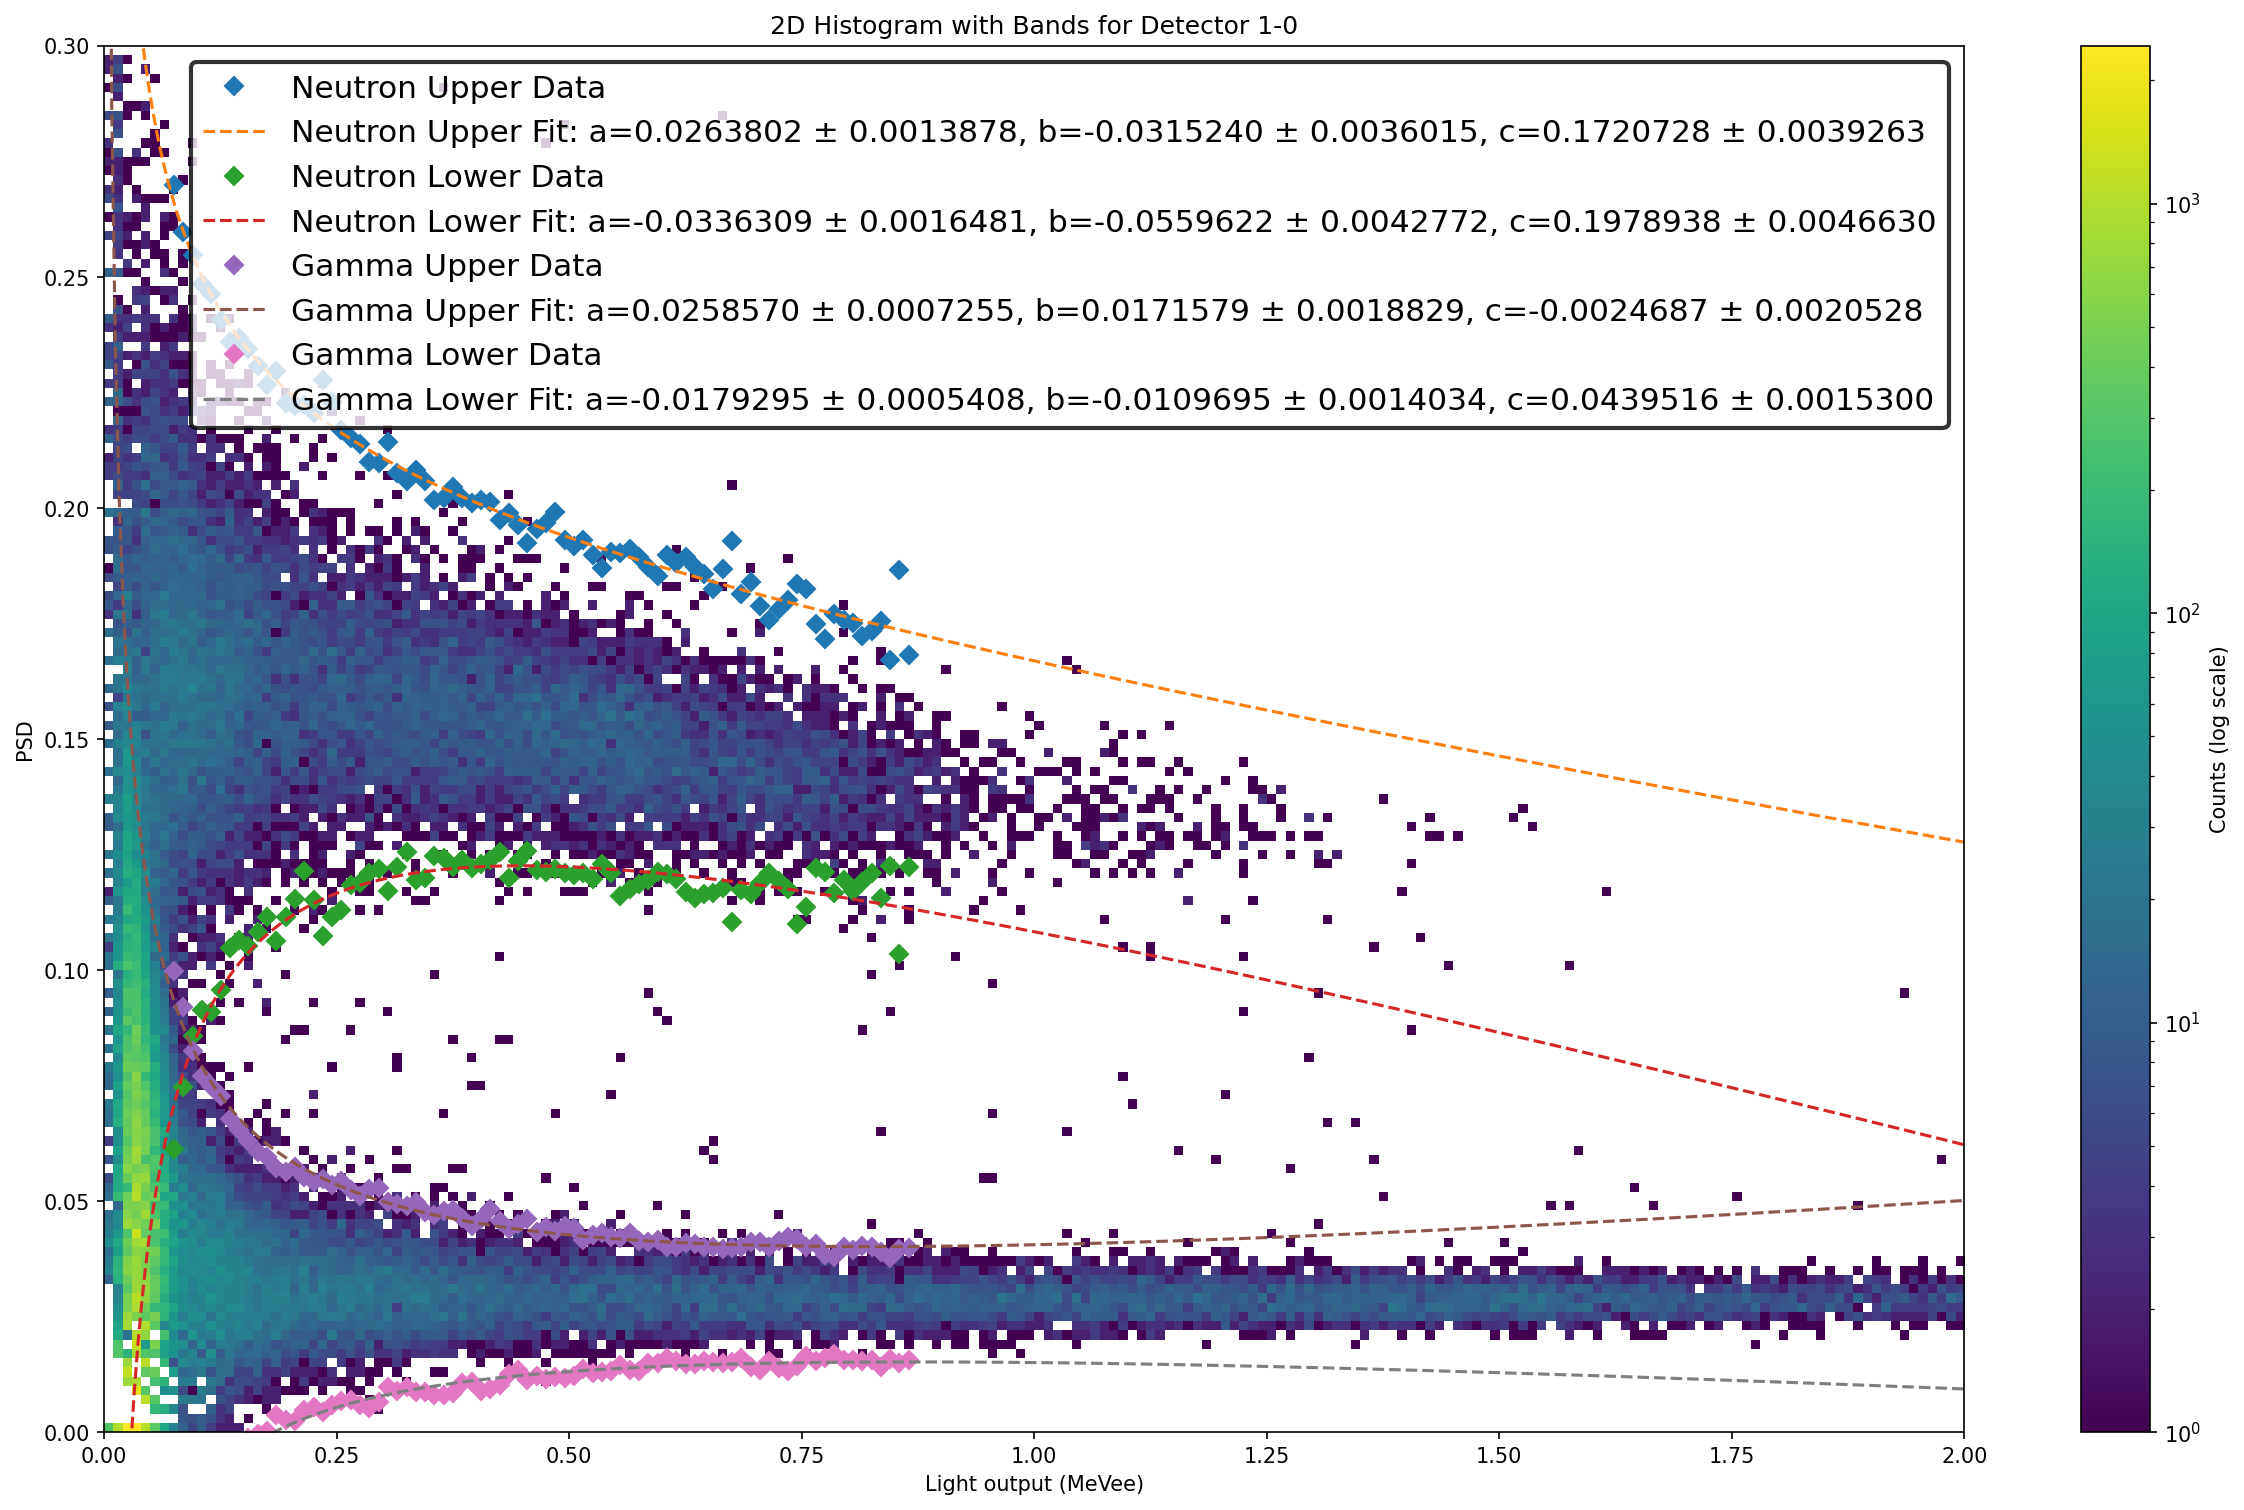

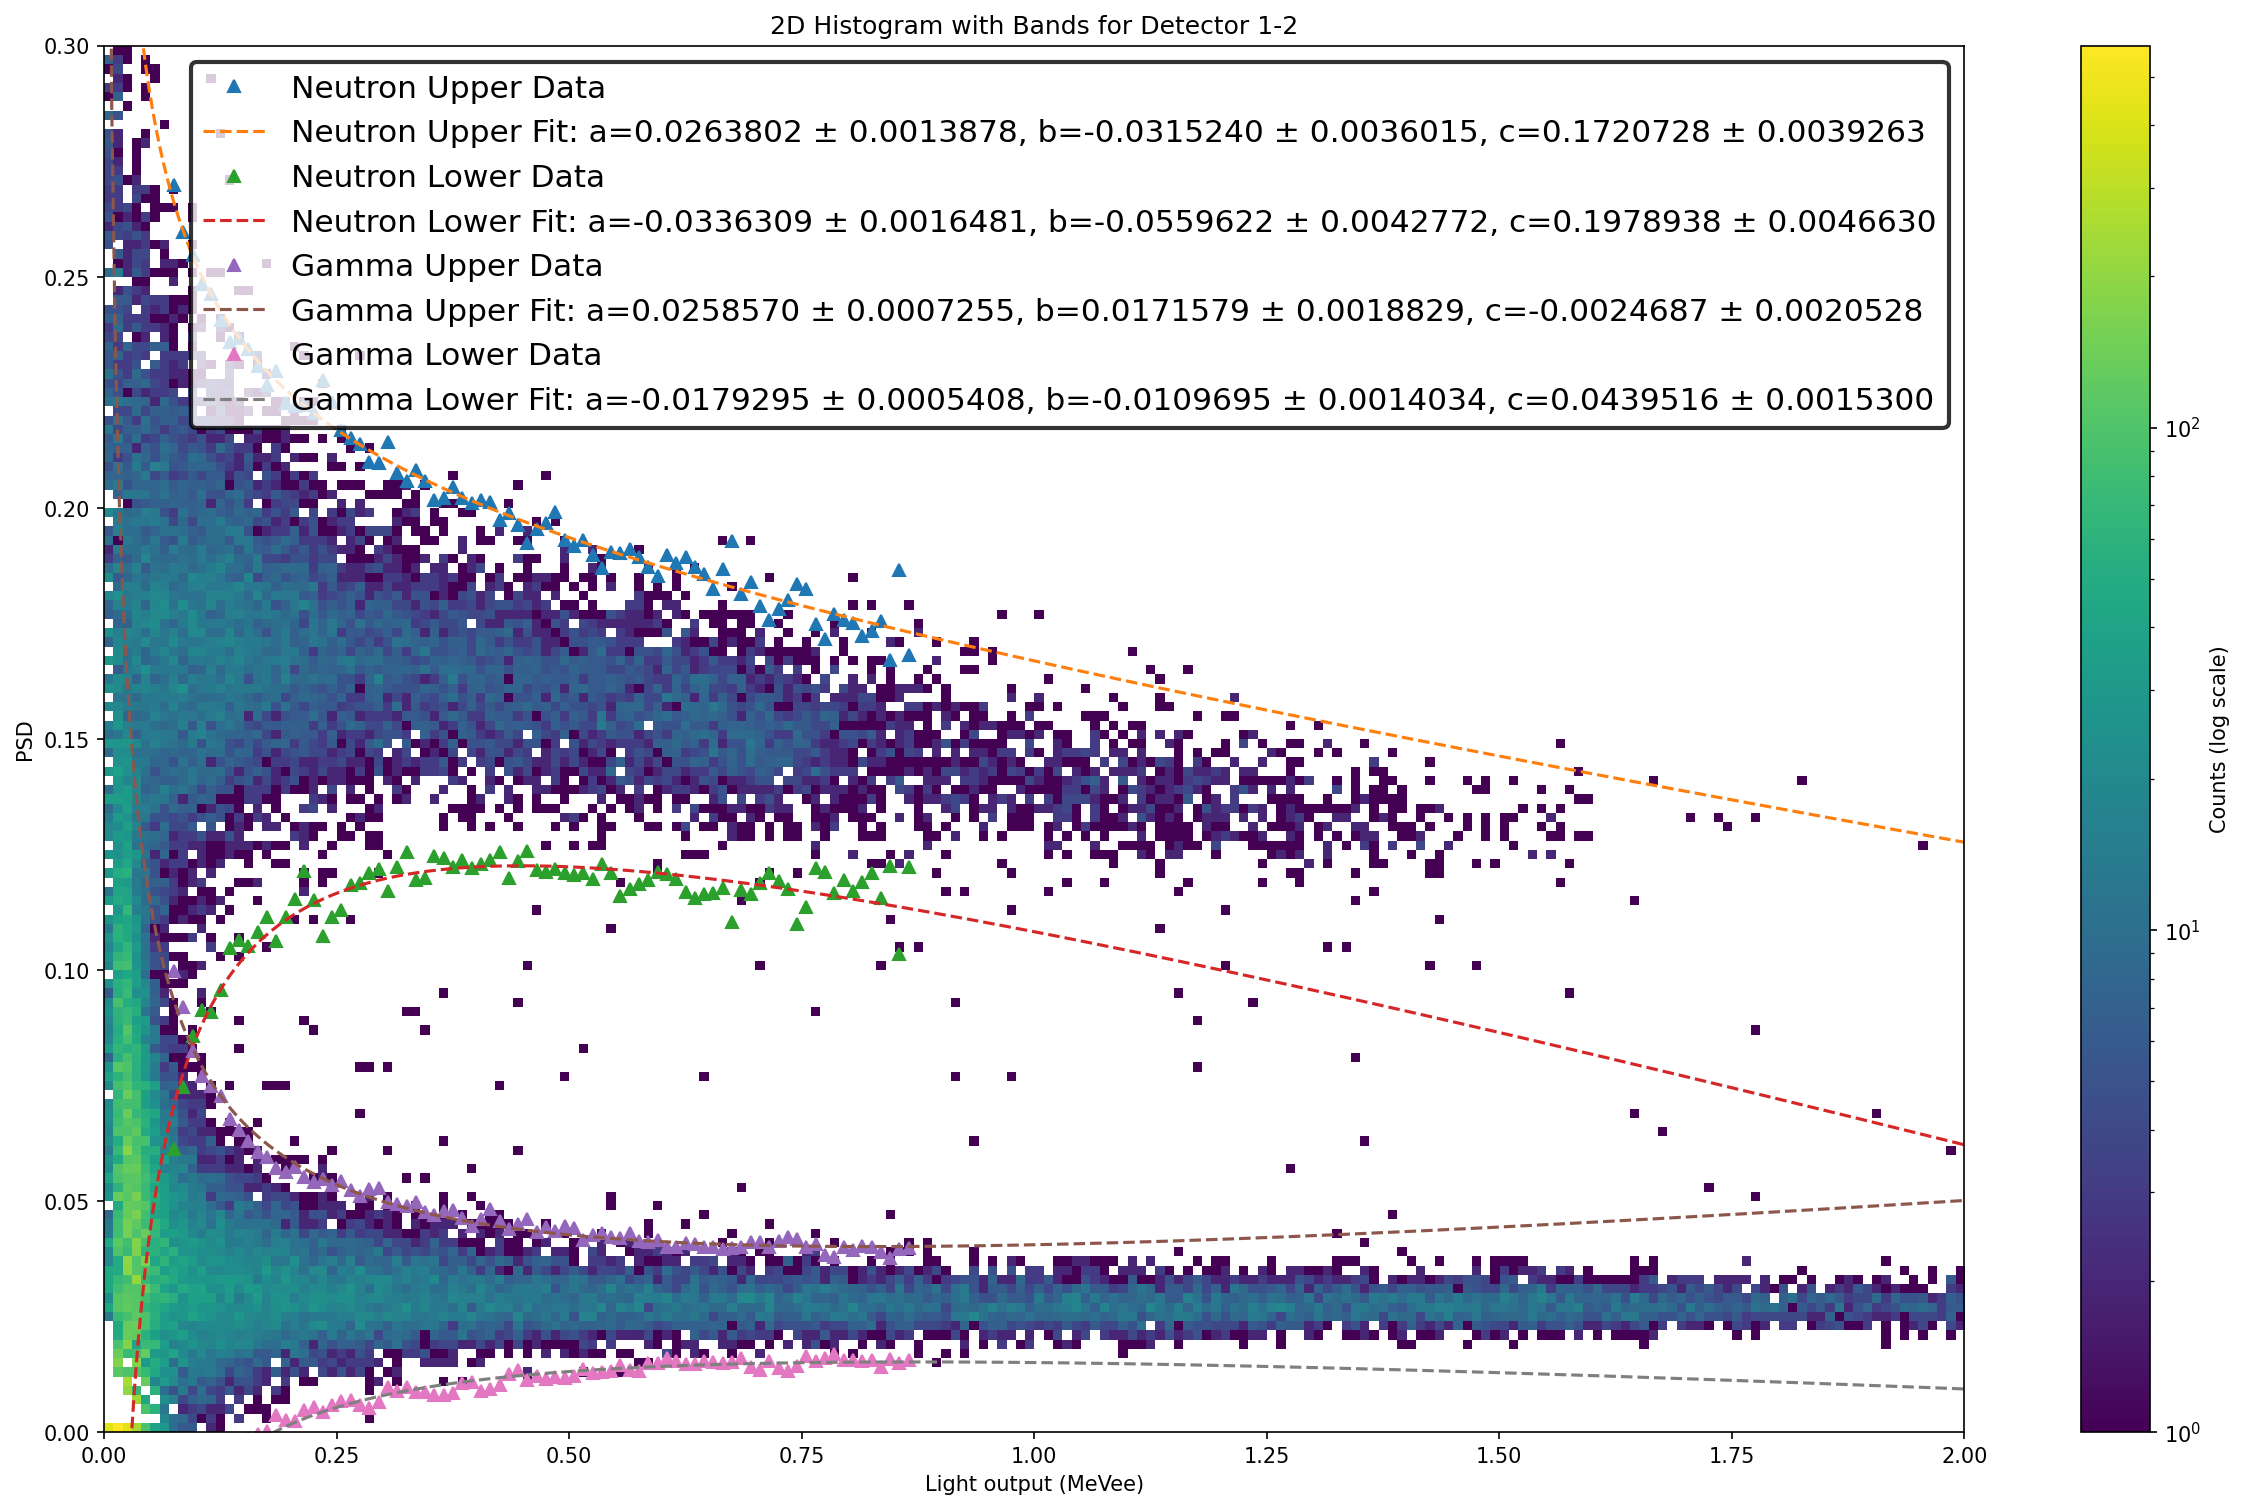

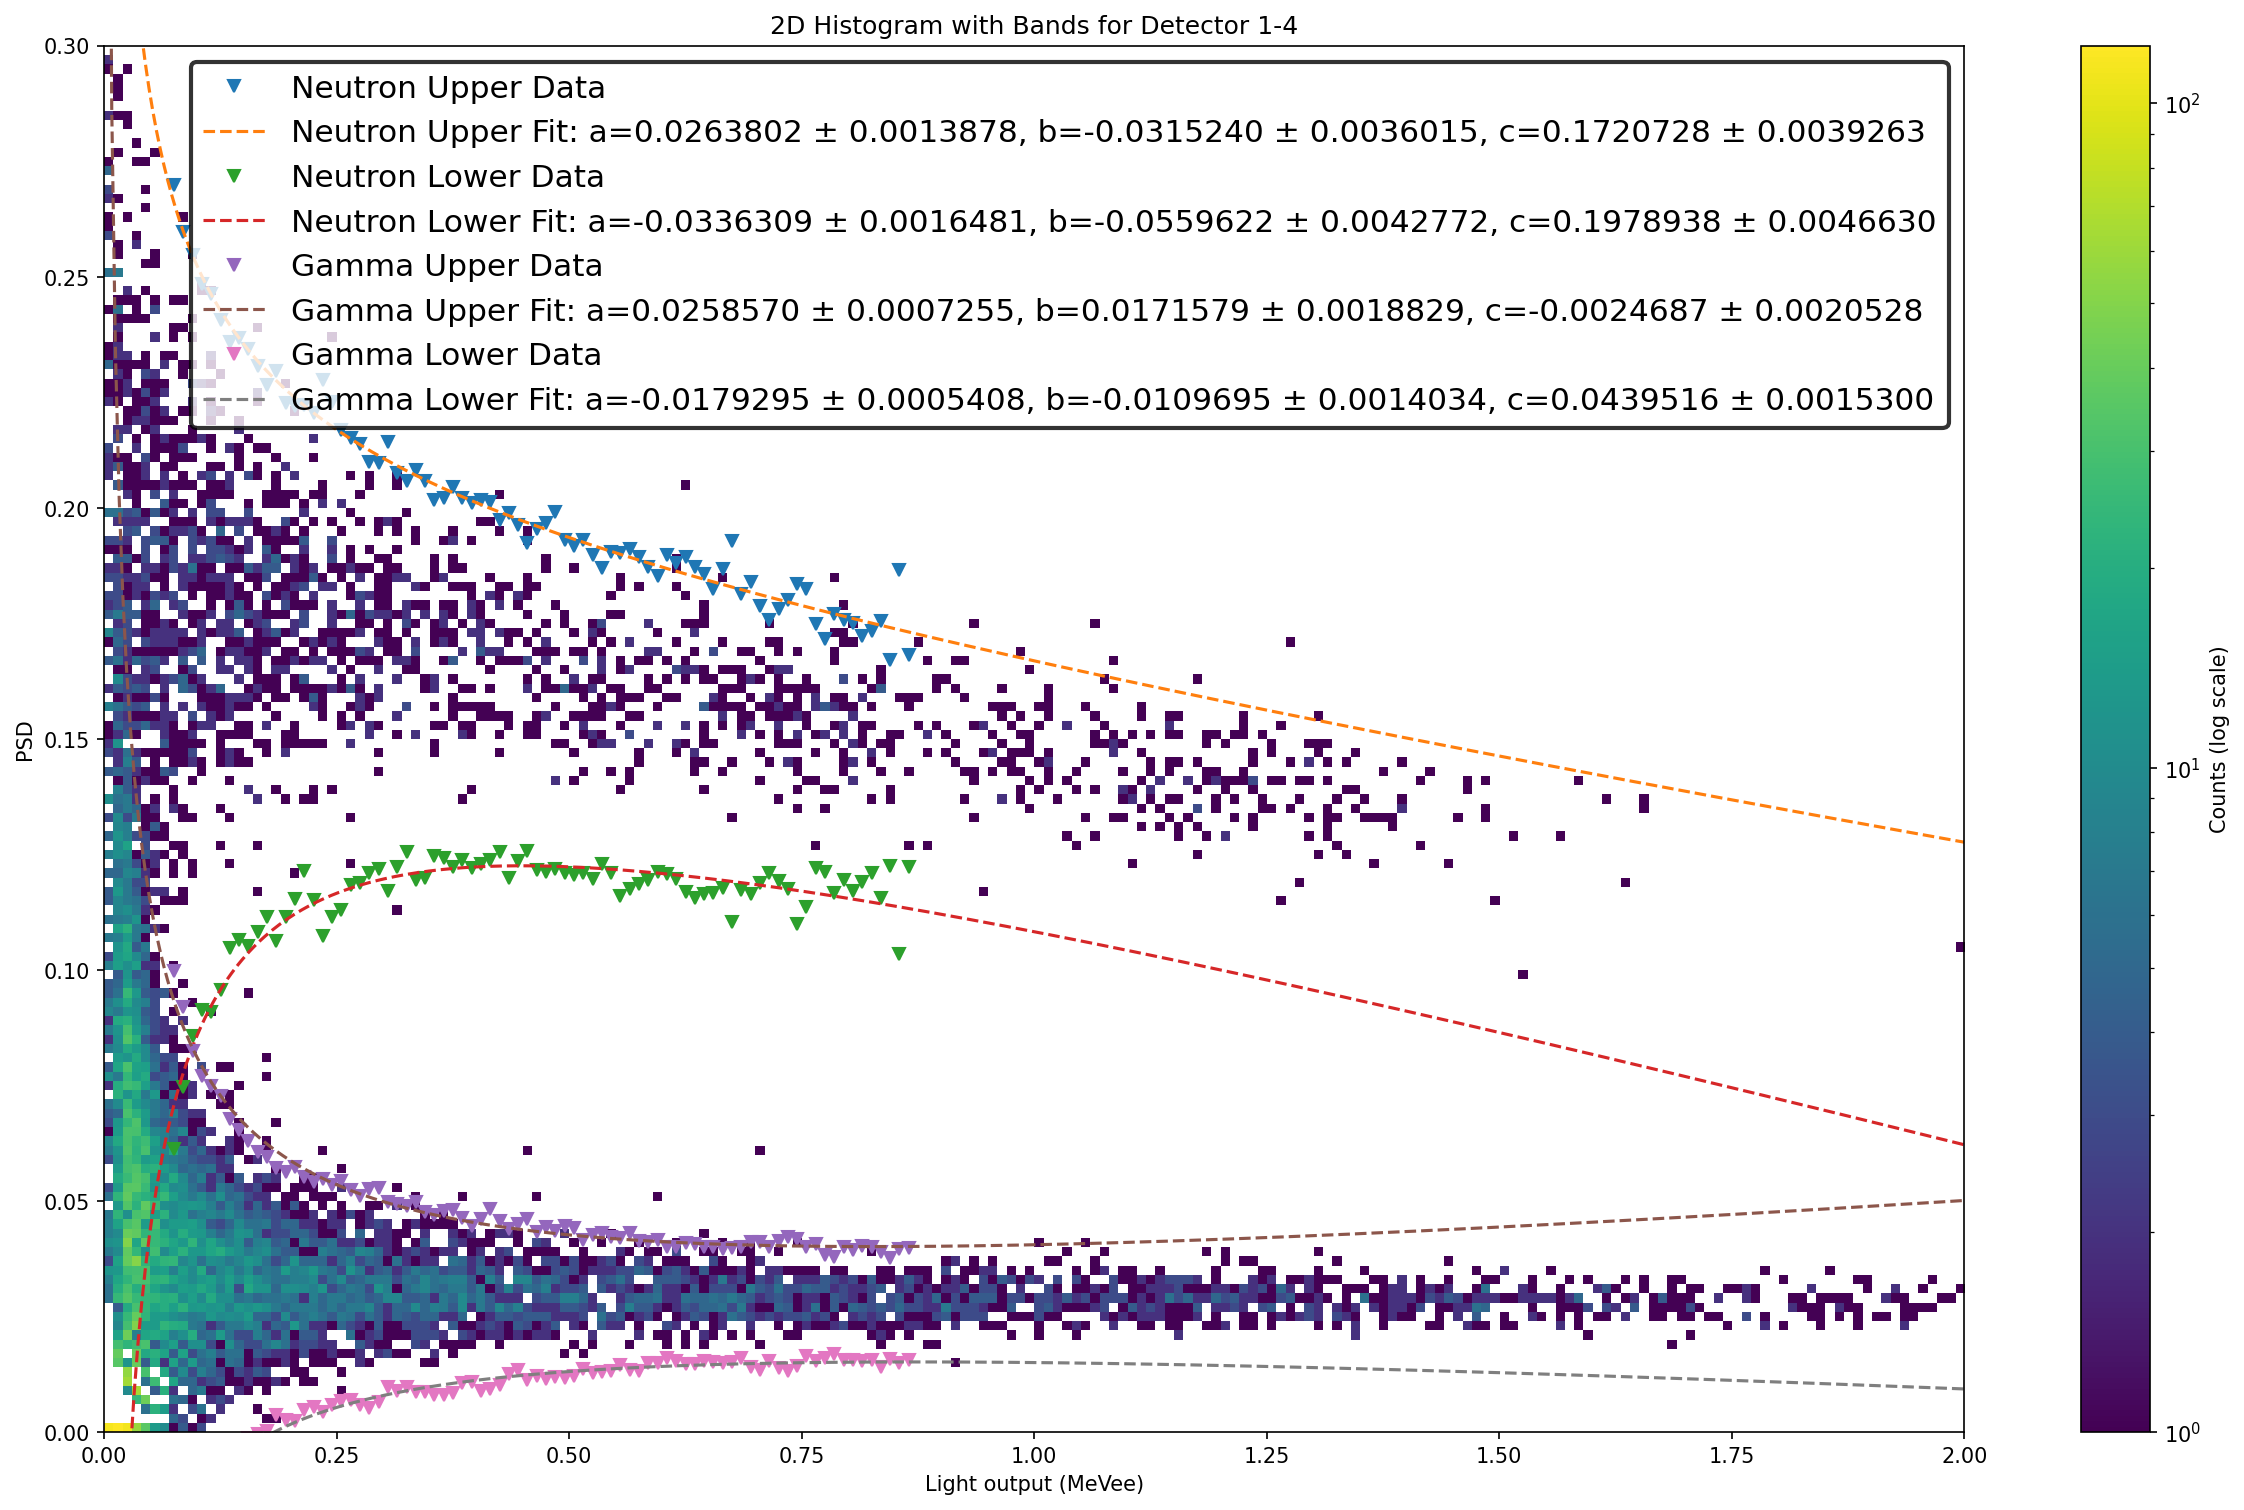

In [14]:


# Fitting the bands
# Fitting the upper neutron band
popt_neutron_up, pcov_neutron_up = curve_fit(psd_fitting, L, neutron_upper_band)
x_neutron_up = np.linspace(0, 2, 500)
y_neutron_up = psd_fitting(x_neutron_up, *popt_neutron_up)
perr_neutron_up = np.sqrt(np.diag(pcov_neutron_up))

# Fitting the lower neutron band
popt_neutron_low, pcov_neutron_low = curve_fit(psd_fitting, L, neutron_lower_band)
x_neutron_low = np.linspace(0, 2, 500)
y_neutron_low = psd_fitting(x_neutron_low, *popt_neutron_low)
perr_neutron_low = np.sqrt(np.diag(pcov_neutron_low))

# Fitting the upper gamma band
popt_gamma_up, pcov_gamma_up = curve_fit(psd_fitting, L, gamma_upper_band)
x_gamma_up = np.linspace(0, 2, 500)
y_gamma_up = psd_fitting(x_gamma_up, *popt_gamma_up)
perr_gamma_up = np.sqrt(np.diag(pcov_gamma_up))

# Fitting the lower gamma band
popt_gamma_low, pcov_gamma_low = curve_fit(psd_fitting, L, gamma_lower_band)
x_gamma_low = np.linspace(0, 2, 500)
y_gamma_low = psd_fitting(x_gamma_low, *popt_gamma_low)
perr_gamma_low = np.sqrt(np.diag(pcov_gamma_low))

# Open the ROOT file
inFile_extracted = ROOT.TFile("/Users/shahinashahina/Documents/PhD/Experiments/25Mg(a,n)/CAMPAIGN_2018/25Mg_CAMPAIGN_2018/neutron_data/scripts_python2/ExtractNeutronSpectra_data/run_0234.root")

# Plotting
neutronDetectors = ["0-0", "0-4", "1-0", "1-2", "1-4"]
markers = ['o', 's', 'D', '^', 'v']  # Different markers for each detector

for i, detector in enumerate(neutronDetectors):
    # Get the histogram for the current detector
    hPSDee = inFile_extracted.Get(f"hPSDee_{detector}")

    # Extract histogram data
    n_bins_x = hPSDee.GetNbinsX()
    n_bins_y = hPSDee.GetNbinsY()
    x_edges = [hPSDee.GetXaxis().GetBinLowEdge(i) for i in range(1, n_bins_x + 2)]
    y_edges = [hPSDee.GetYaxis().GetBinLowEdge(i) for i in range(1, n_bins_y + 2)]
    hist_2d = np.array([[hPSDee.GetBinContent(i, j) for j in range(1, n_bins_y + 1)] for i in range(1, n_bins_x + 1)])

    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    fig.set_dpi(150)
    fig.set_size_inches(20, 12)

    # Plot the 2D histogram using Matplotlib's imshow
    plt.imshow(hist_2d.T, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto', origin='lower', norm=LogNorm())
    plt.colorbar(label='Counts (log scale)')
    plt.xlabel('Light output (MeVee)')
    plt.ylabel("PSD")
    plt.xlim(0, 2)
    plt.ylim(0, 0.3)
    plt.title(f'2D Histogram with Bands for Detector {detector}')

    # Plot the bands from detector 0-0
    plt.plot(L, neutron_upper_band, markers[i], label="Neutron Upper Data")
    plt.plot(x_neutron_up, y_neutron_up, label=f"Neutron Upper Fit: a={popt_neutron_up[0]:.7f} ± {perr_neutron_up[0]:.7f}, b={popt_neutron_up[1]:.7f} ± {perr_neutron_up[1]:.7f}, c={popt_neutron_up[2]:.7f} ± {perr_neutron_up[2]:.7f}", linestyle="--")

    plt.plot(L, neutron_lower_band, markers[i], label="Neutron Lower Data")
    plt.plot(x_neutron_low, y_neutron_low, label=f"Neutron Lower Fit: a={popt_neutron_low[0]:.7f} ± {perr_neutron_low[0]:.7f}, b={popt_neutron_low[1]:.7f} ± {perr_neutron_low[1]:.7f}, c={popt_neutron_low[2]:.7f} ± {perr_neutron_low[2]:.7f}", linestyle="--")

    plt.plot(L, gamma_upper_band, markers[i], label="Gamma Upper Data")
    plt.plot(x_gamma_up, y_gamma_up, label=f"Gamma Upper Fit: a={popt_gamma_up[0]:.7f} ± {perr_gamma_up[0]:.7f}, b={popt_gamma_up[1]:.7f} ± {perr_gamma_up[1]:.7f}, c={popt_gamma_up[2]:.7f} ± {perr_gamma_up[2]:.7f}", linestyle="--")

    plt.plot(L, gamma_lower_band, markers[i], label="Gamma Lower Data")
    plt.plot(x_gamma_low, y_gamma_low, label=f"Gamma Lower Fit: a={popt_gamma_low[0]:.7f} ± {perr_gamma_low[0]:.7f}, b={popt_gamma_low[1]:.7f} ± {perr_gamma_low[1]:.7f}, c={popt_gamma_low[2]:.7f} ± {perr_gamma_low[2]:.7f}", linestyle="--")

    # Legend Properties
    legend_properties = {'size': 20}
    leg = plt.legend(fontsize=15, loc="upper right")
    leg.get_frame().set_edgecolor('k')
    leg.get_frame().set_linewidth(2.0)

    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


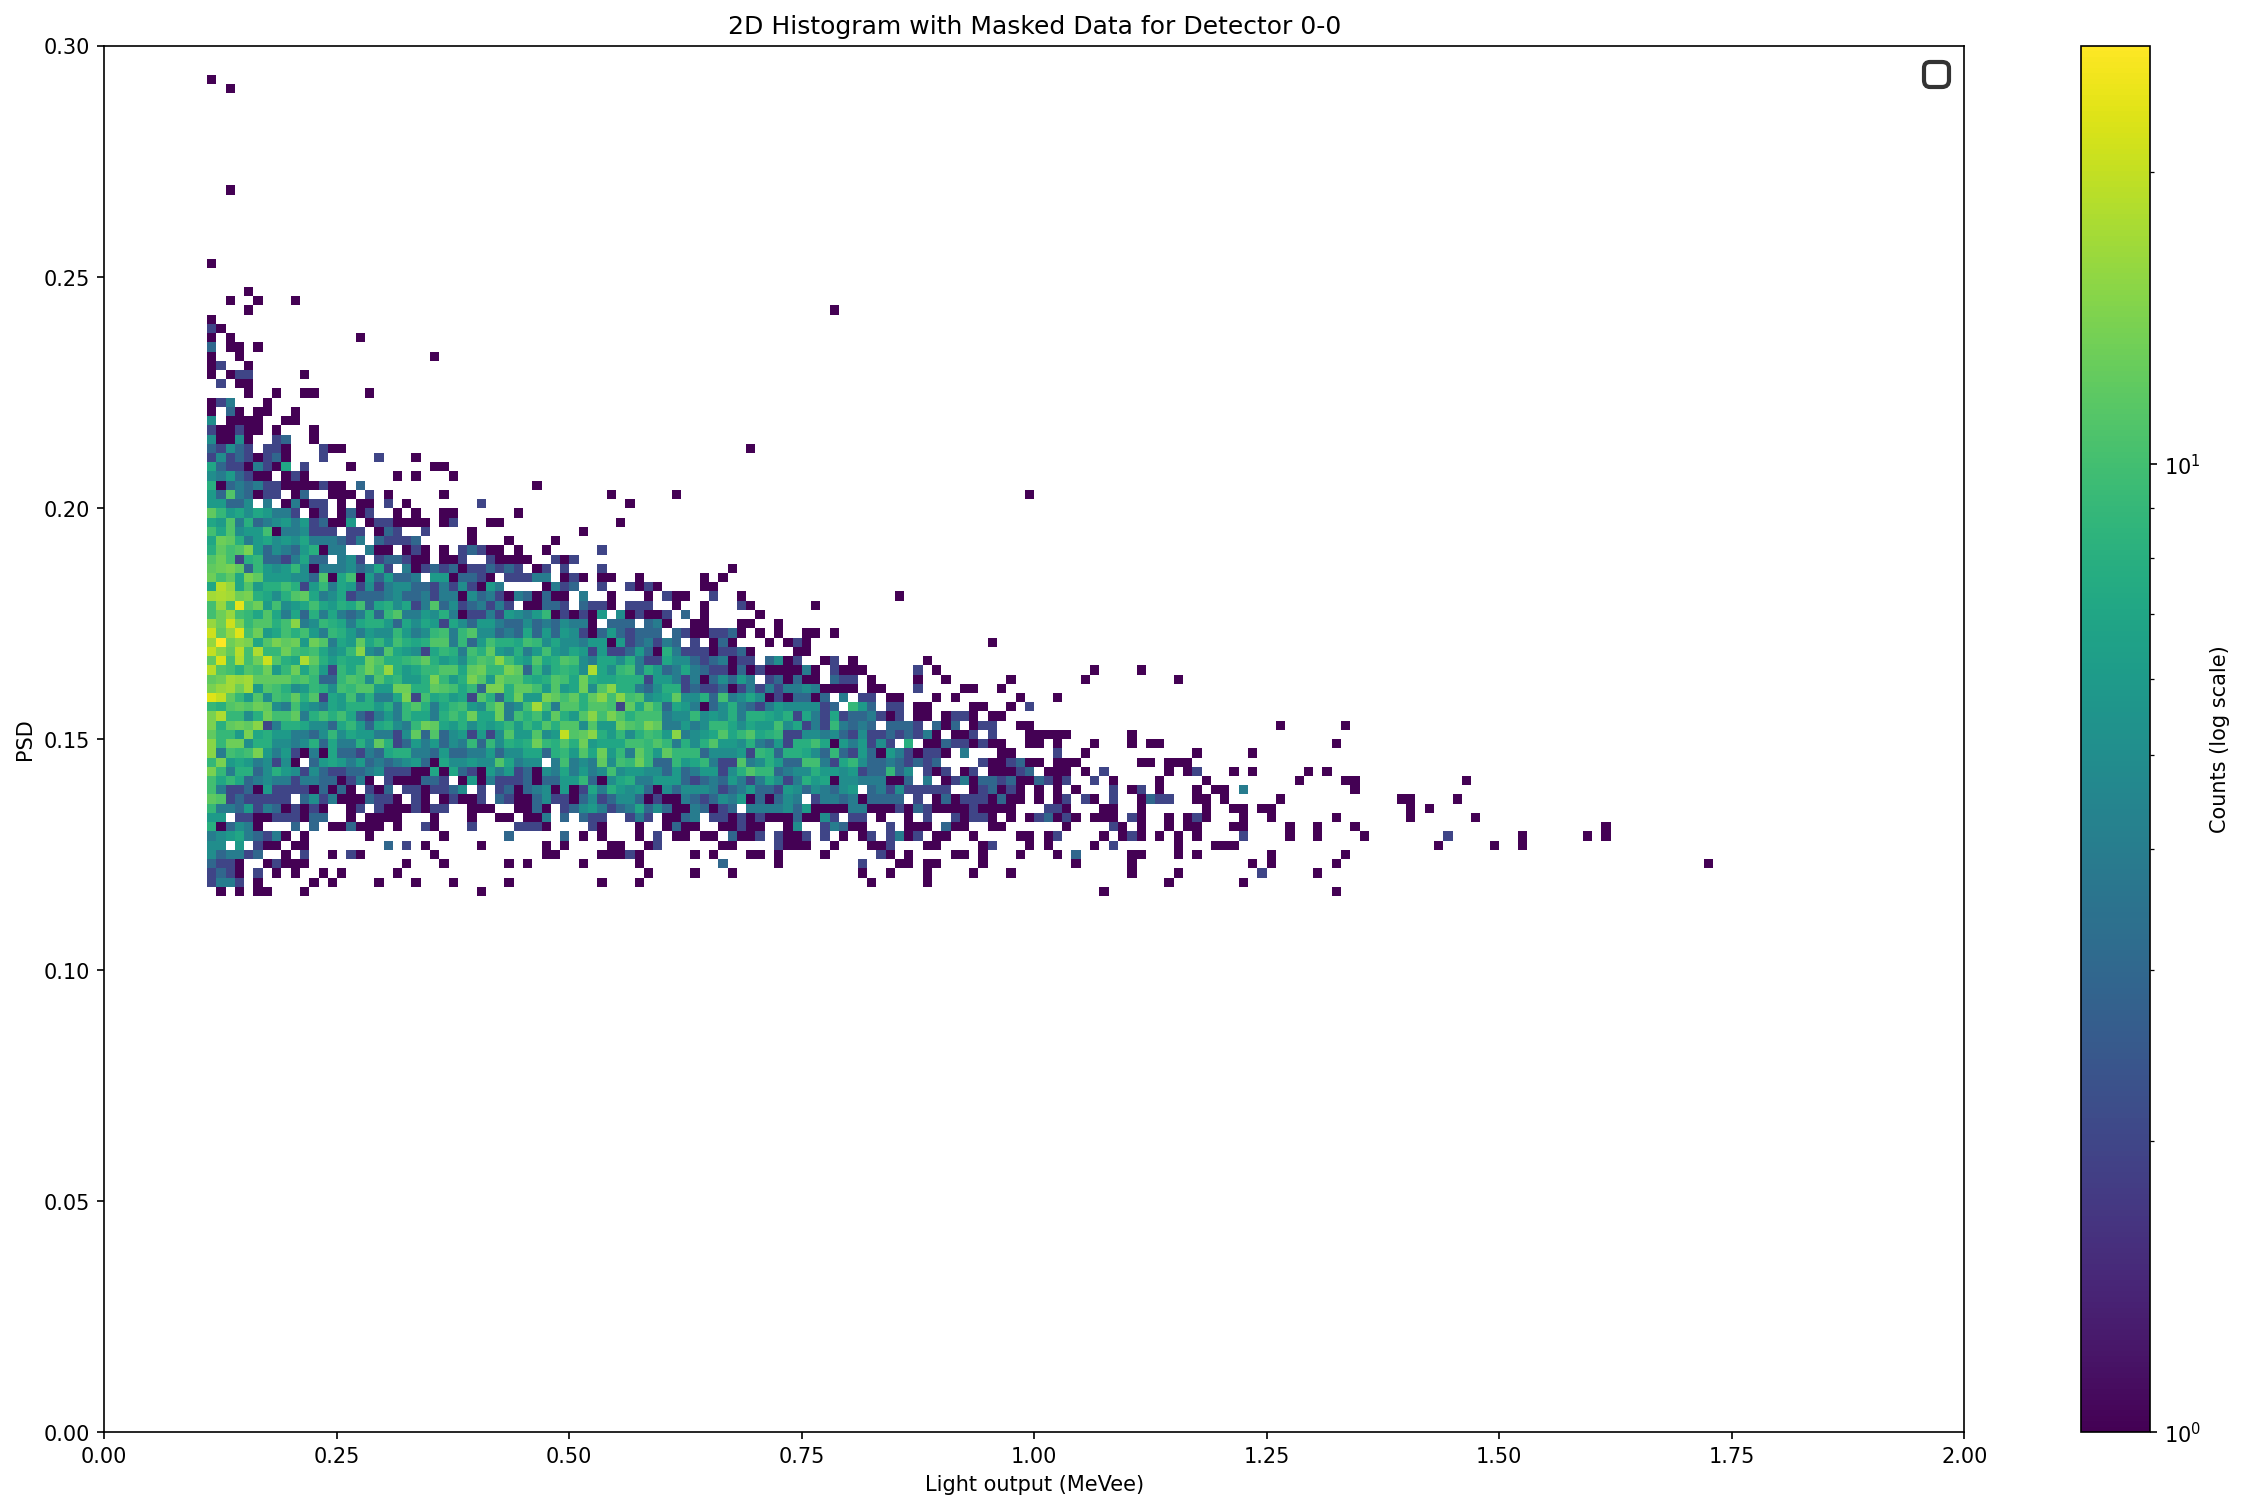

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


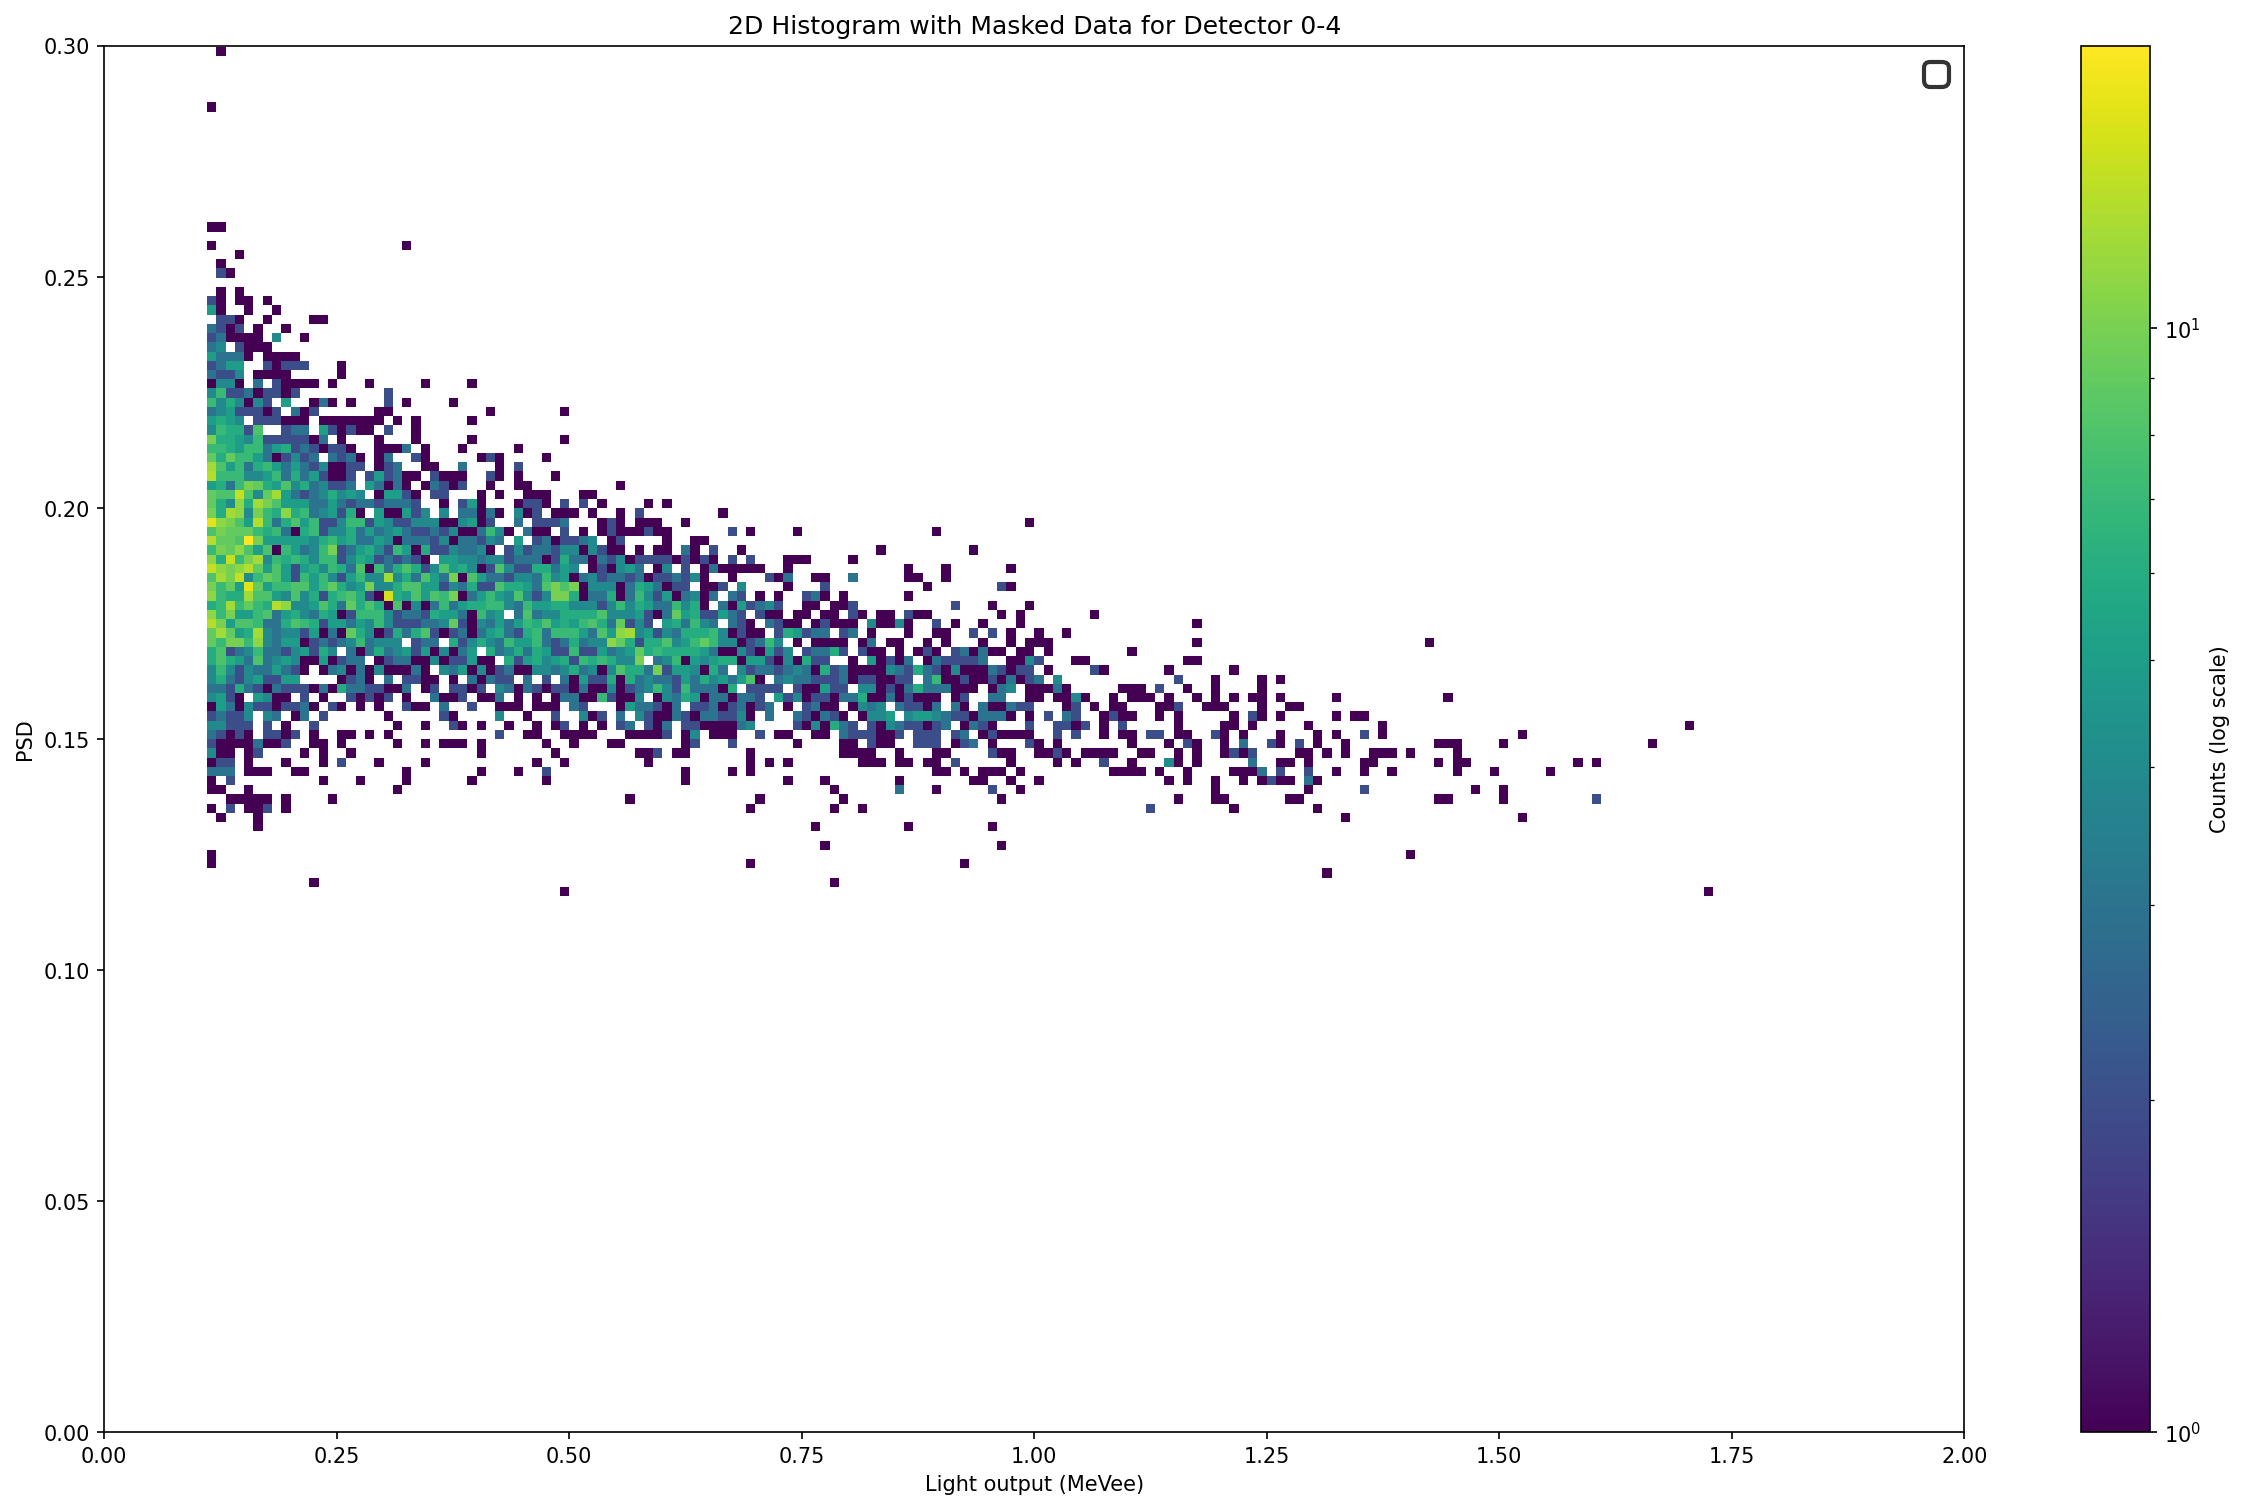

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


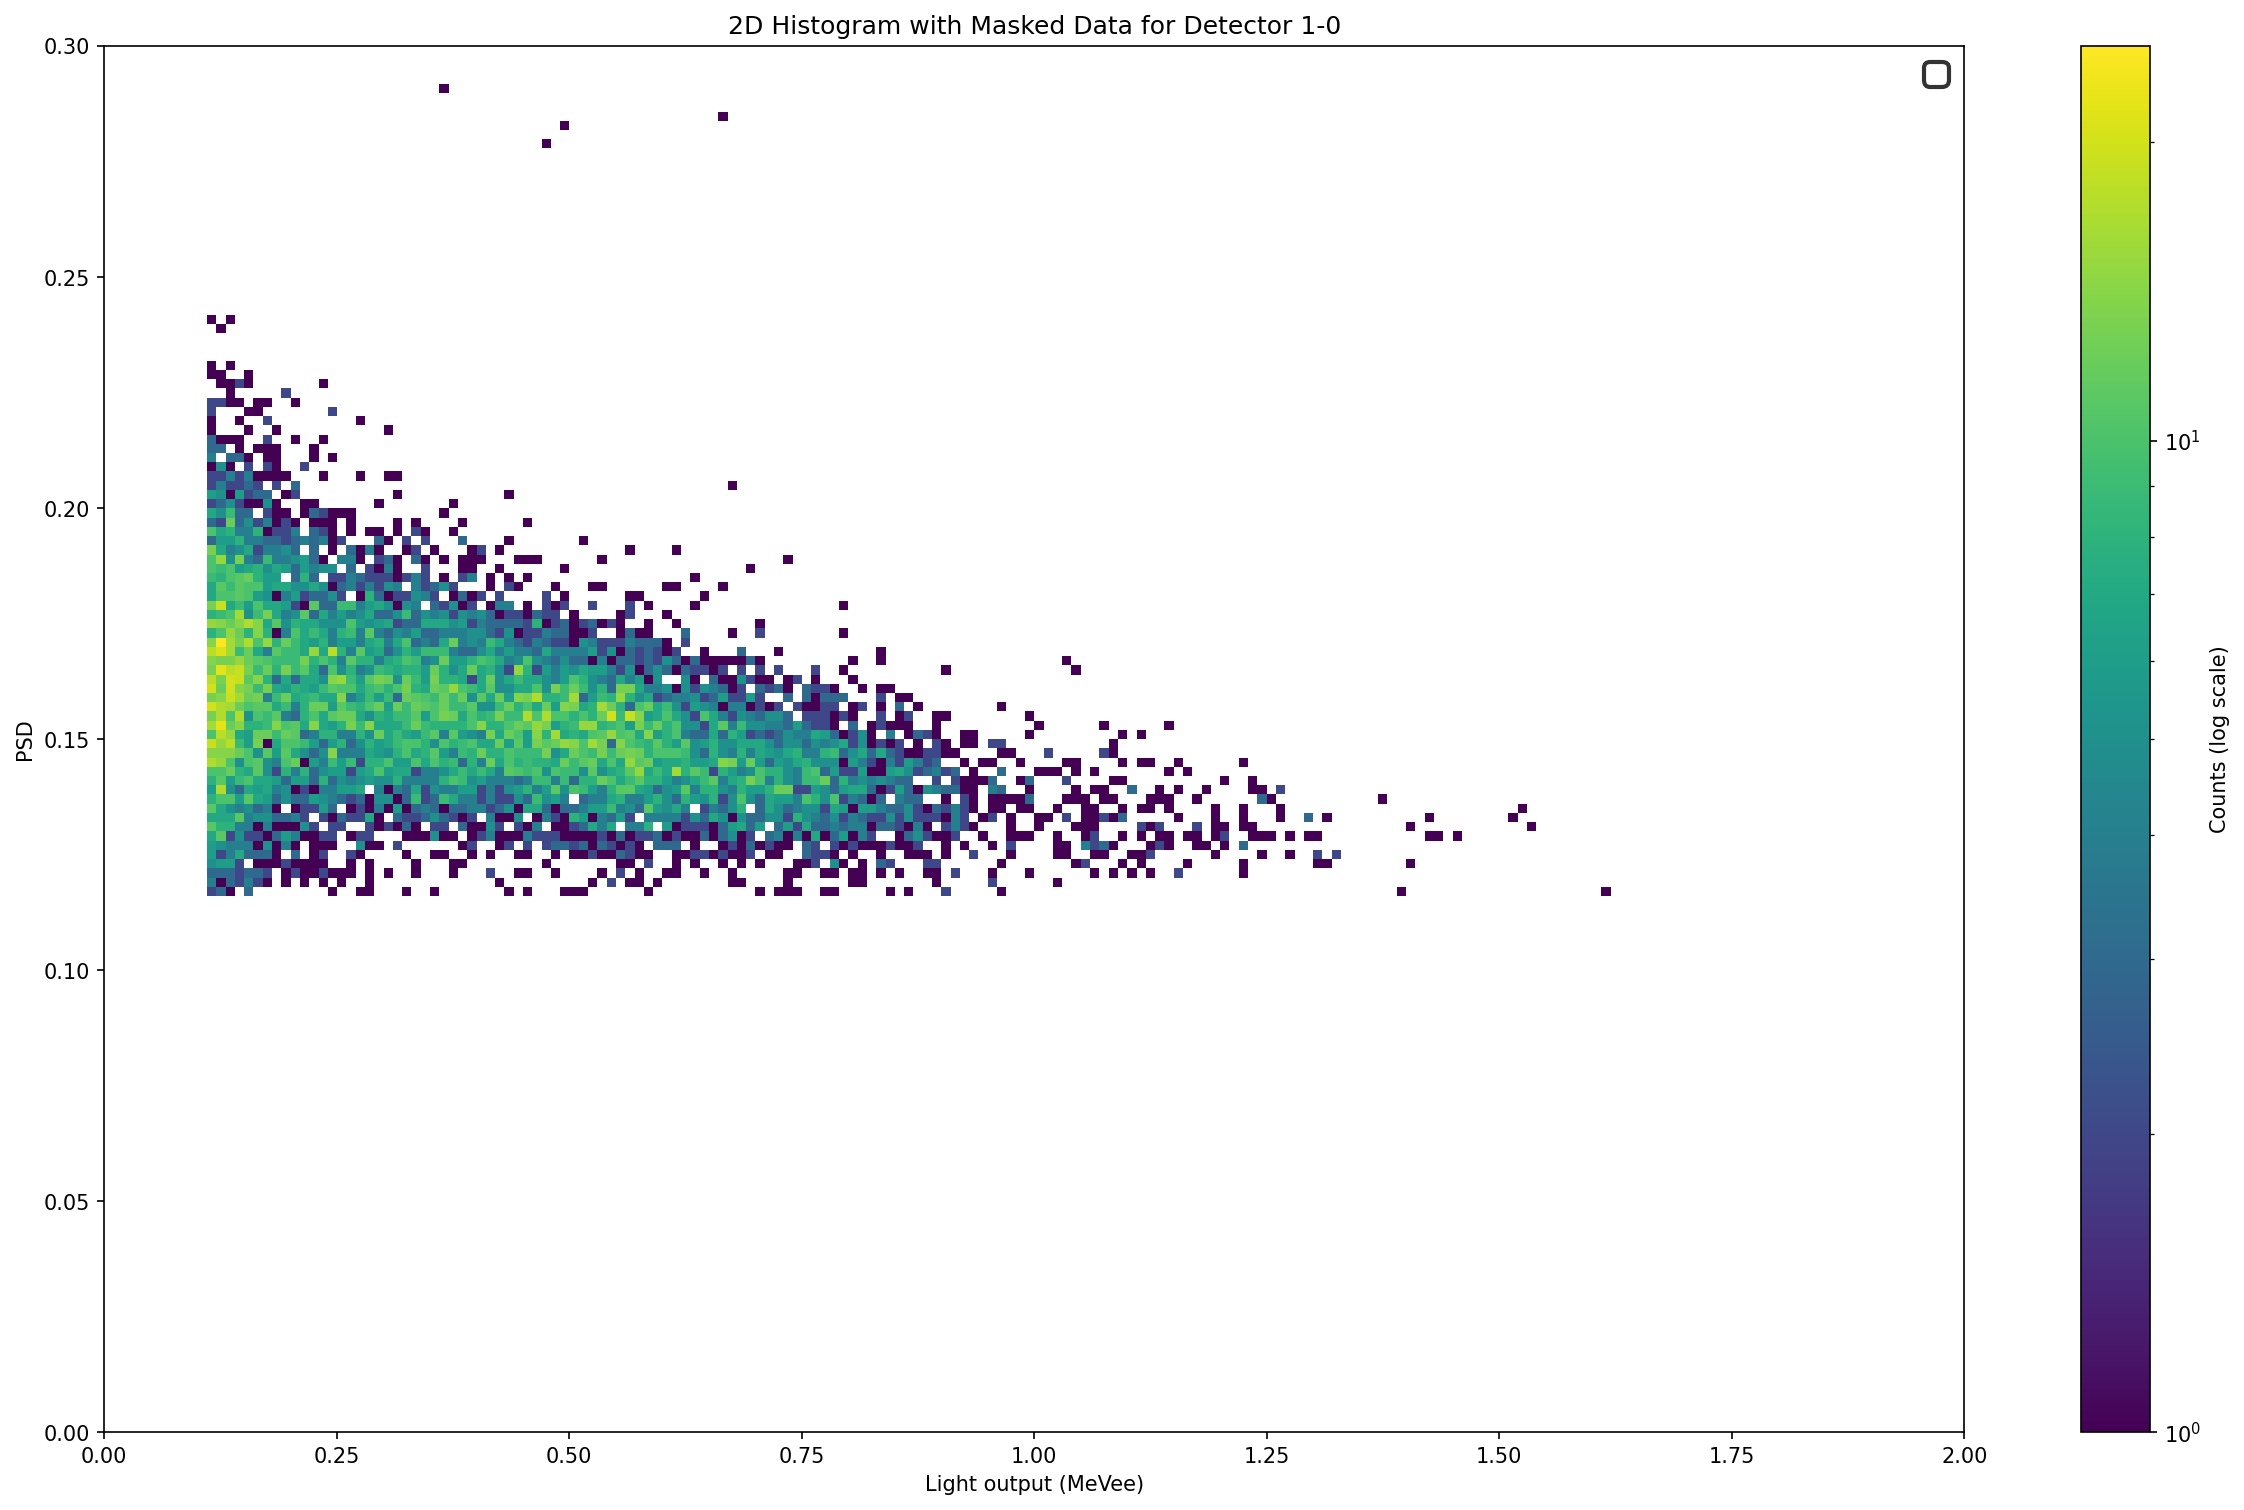

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


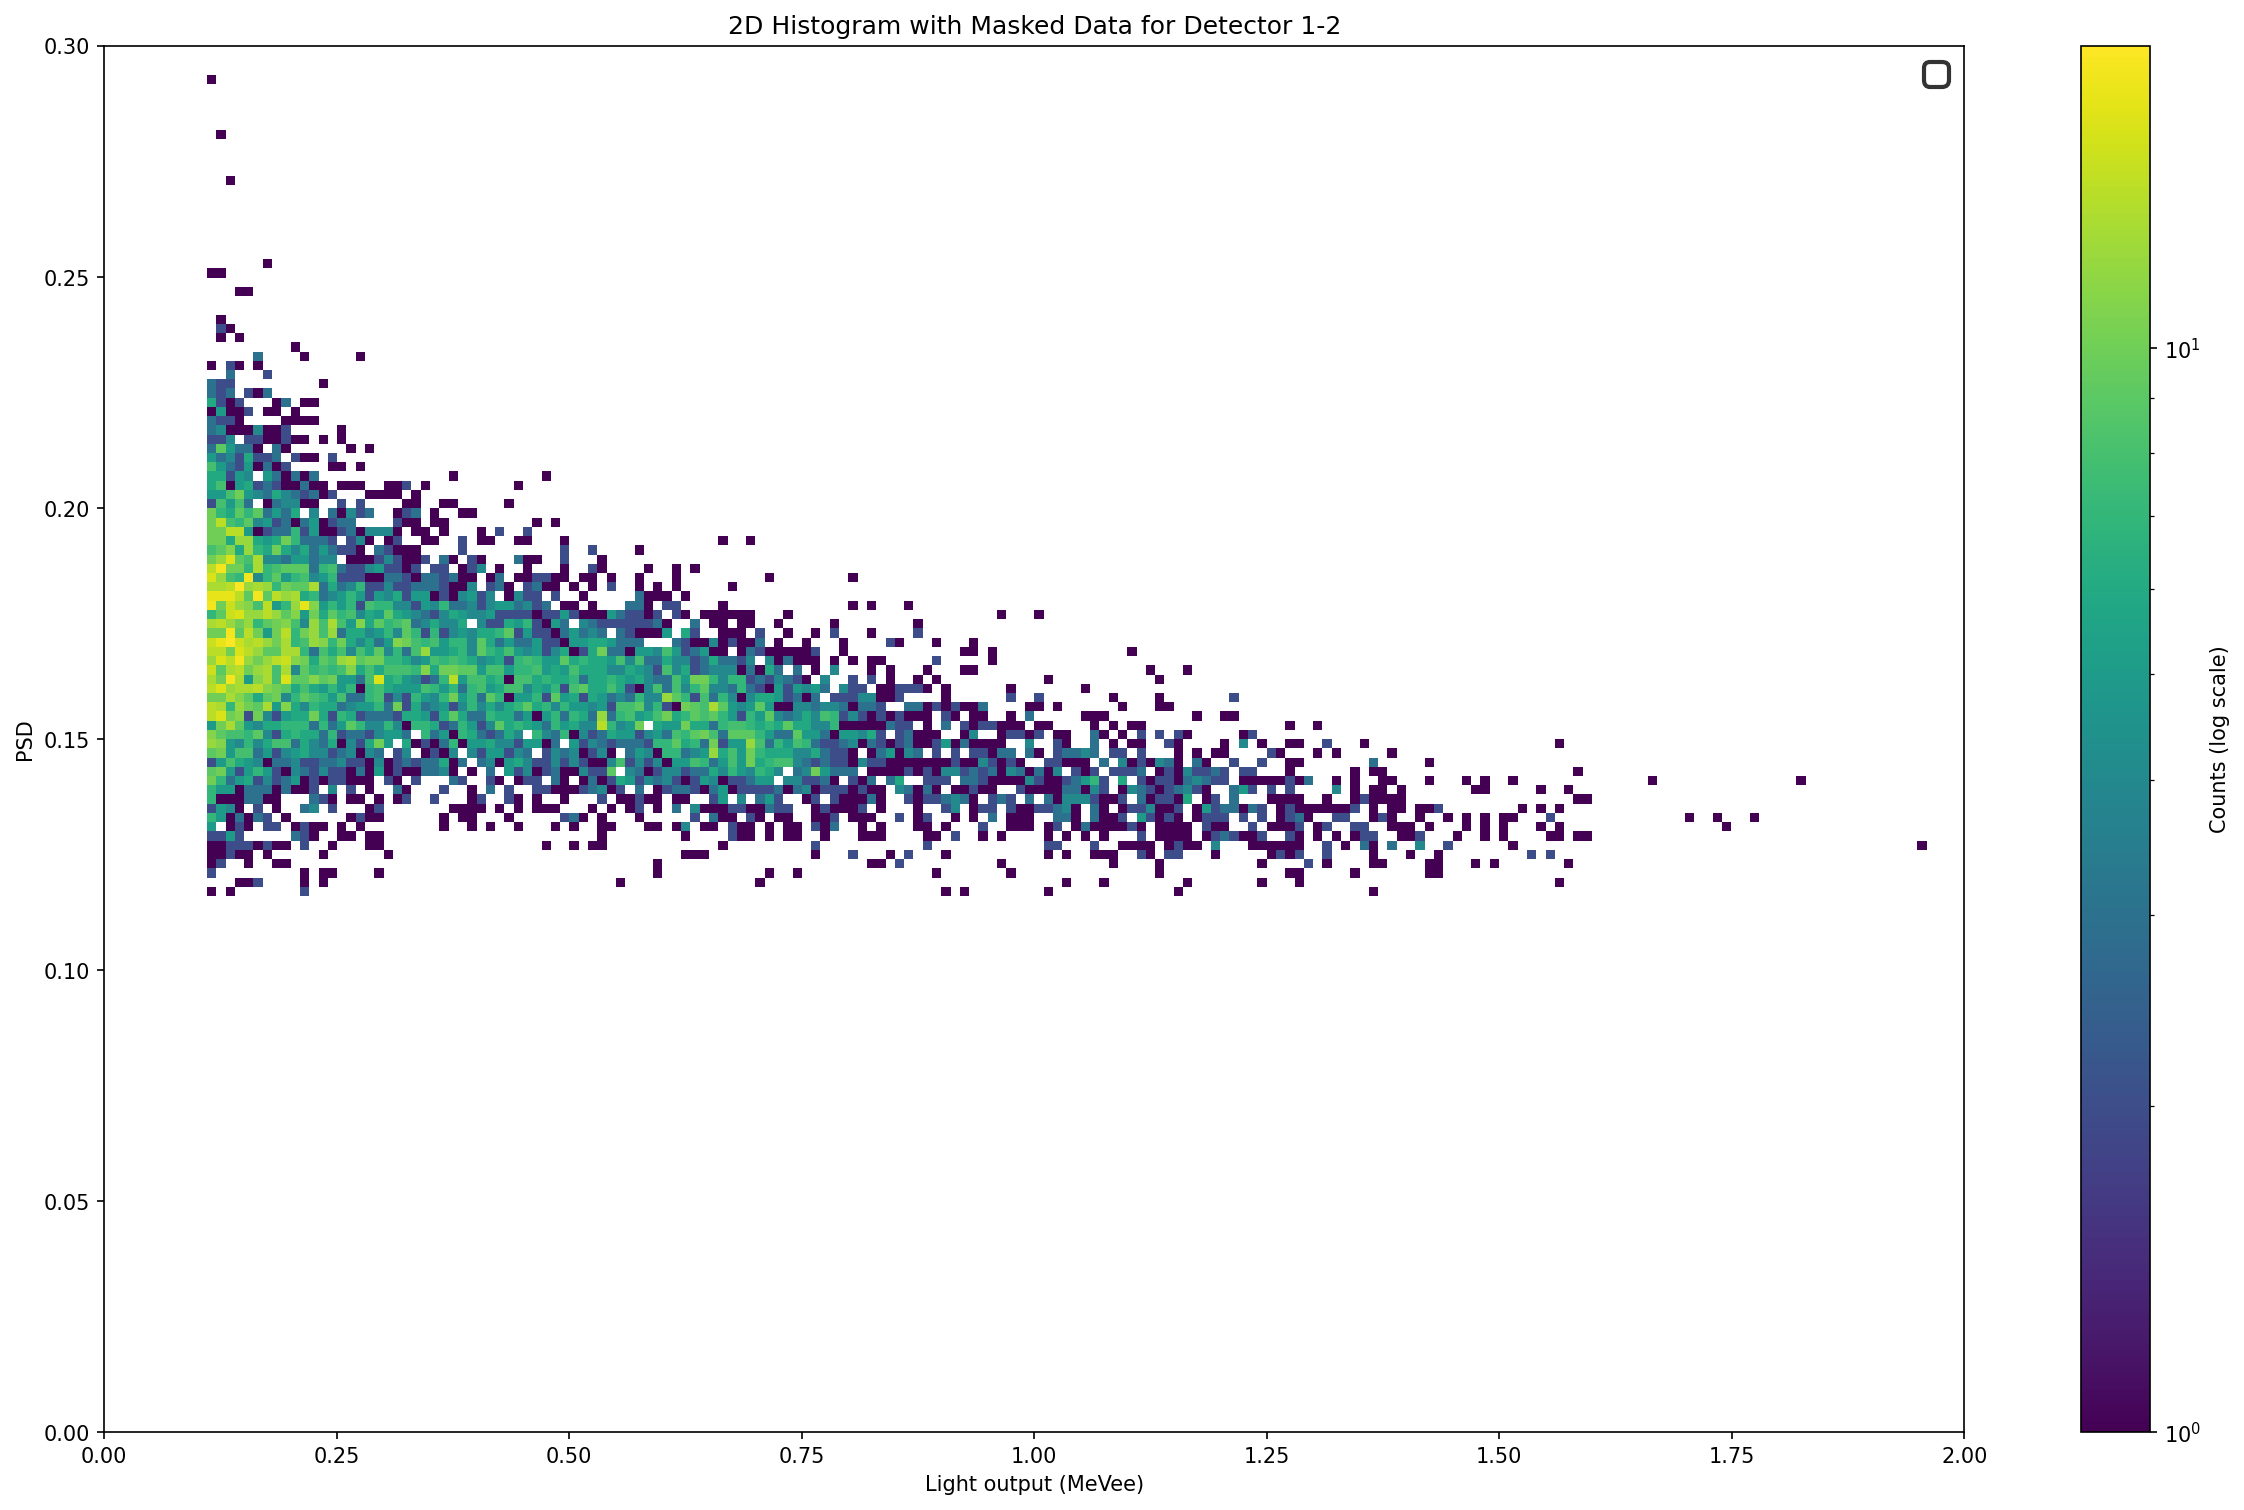

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


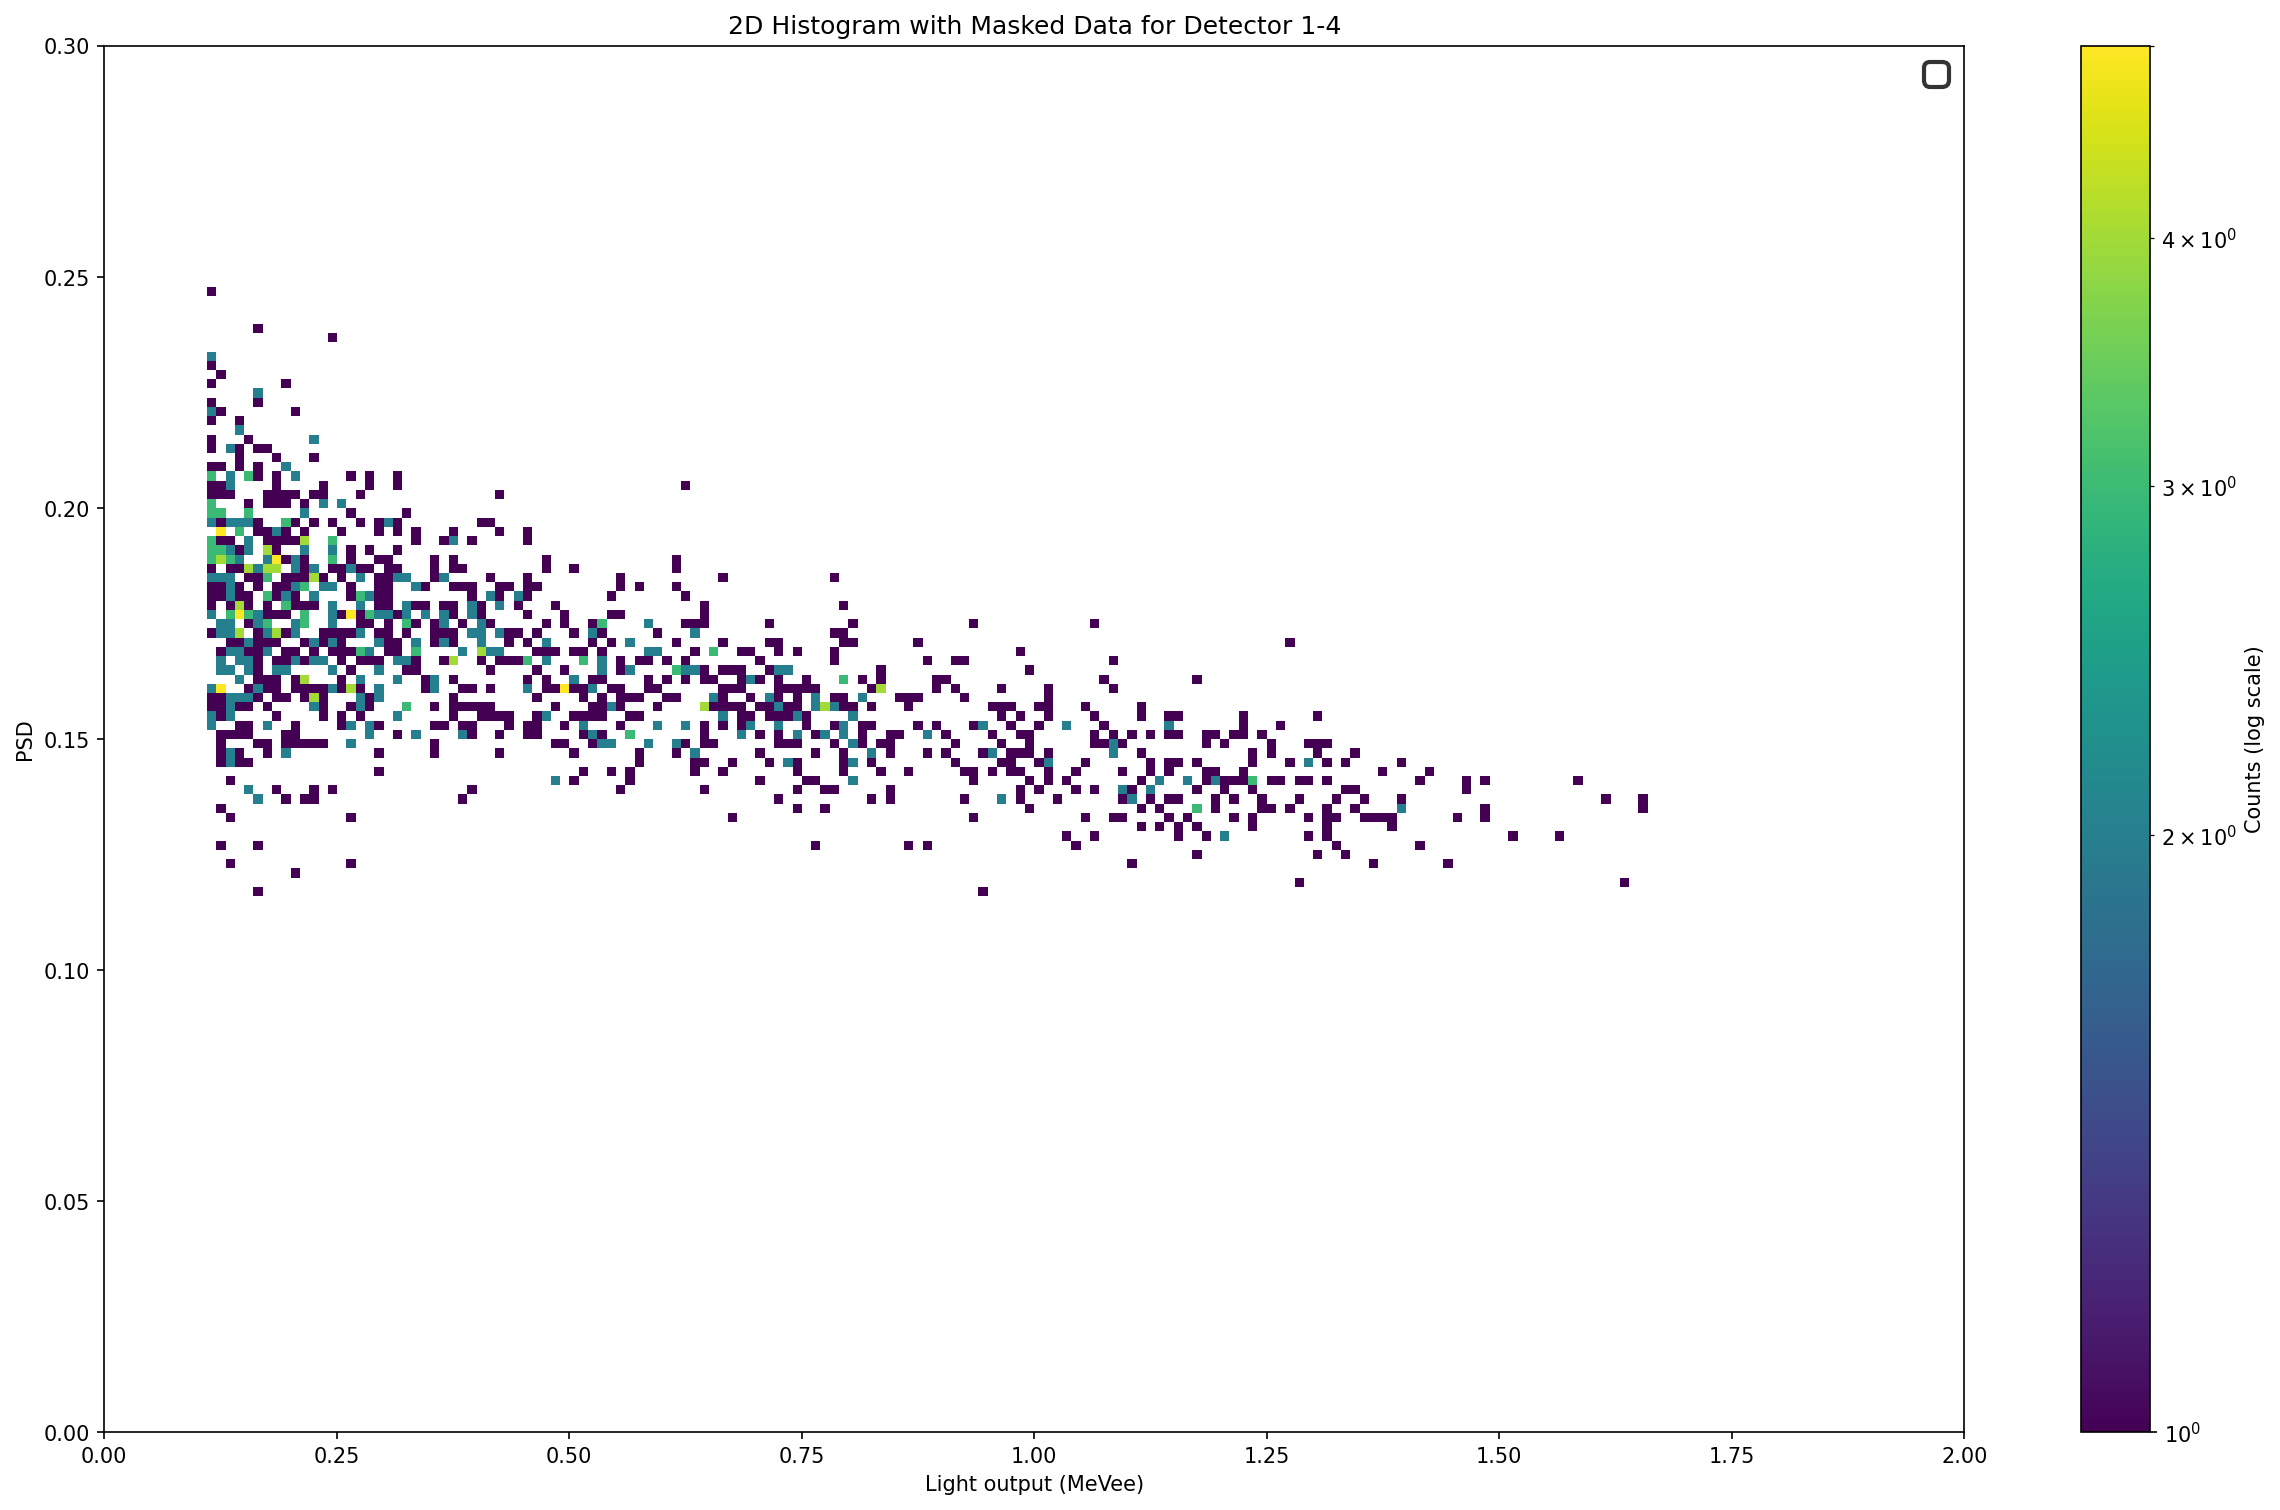

In [15]:
# Loop through each detector
for detector in neutronDetectors:
    # Get the histogram for the current detector
    hPSDee = inFile_extracted.Get(f"hPSDee_{detector}")

    # Extract histogram data
    n_bins_x = hPSDee.GetNbinsX()
    n_bins_y = hPSDee.GetNbinsY()
    x_edges = np.array([hPSDee.GetXaxis().GetBinLowEdge(i) for i in range(1, n_bins_x + 2)])
    y_edges = np.array([hPSDee.GetYaxis().GetBinLowEdge(i) for i in range(1, n_bins_y + 2)])
    hist_2d = np.array([[hPSDee.GetBinContent(i, j) for j in range(1, n_bins_y + 1)] for i in range(1, n_bins_x + 1)])

    # Calculate the lower band
    band_lower = np.maximum(y_gamma_up, y_neutron_low)
    
    # Apply the masks based on the MCNP threshold and band lower
    y_edges_1 = y_edges[:-1]
    x_edges_1 = x_edges[:-1]
    mask1 = y_edges_1 > band_lower
    y_edges_m1 = y_edges_1[mask1]
    hist_2d_m1 = hist_2d[:, mask1]
    mask2 = x_edges_1 > 0.1
    x_edges_m2 = x_edges_1[mask2]
    hist_2d_m2 = hist_2d_m1[mask2, :]

    # Plot the masked 2D histogram
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    fig.set_dpi(150)
    fig.set_size_inches(20, 12)
    plt.imshow(hist_2d_m2.T, extent=[x_edges_m2[0], x_edges_m2[-1], y_edges_m1[0], y_edges_m1[-1]], aspect='auto', origin='lower', norm=LogNorm())
    plt.colorbar(label='Counts (log scale)')
    plt.xlabel('Light output (MeVee)')
    plt.ylabel("PSD")
    plt.xlim(0, 2)
    plt.ylim(0, 0.3)
    plt.title(f'2D Histogram with Masked Data for Detector {detector}')

   
    
    # Legend Properties
    legend_properties = {'size': 20}
    leg = plt.legend(fontsize=15, loc="upper right")
    leg.get_frame().set_edgecolor('k')
    leg.get_frame().set_linewidth(2.0)
    
    plt.show()

In [16]:
# Create a ROOT file and save the histogram
output_file = ROOT.TFile("Extracted_neutron_spectrum_rootfiles/run_234.root","RECREATE")

for detector in neutronDetectors:
    # Get the histogram for the current detector
    hPSDee = inFile_extracted.Get("hPSDee_%s" % detector)

    # Extract histogram data
    n_bins_x = hPSDee.GetNbinsX()
    n_bins_y = hPSDee.GetNbinsY()
    x_edges = np.array([hPSDee.GetXaxis().GetBinLowEdge(i) for i in range(1, n_bins_x + 2)])
    y_edges = np.array([hPSDee.GetYaxis().GetBinLowEdge(i) for i in range(1, n_bins_y + 2)])
    hist_2d = np.array([[hPSDee.GetBinContent(i, j) for j in range(1, n_bins_y + 1)] for i in range(1, n_bins_x + 1)])

    # Calculate the lower band (assuming you have defined y_gamma_up and y_neutron_low)
    band_lower = np.maximum(y_gamma_up, y_neutron_low)
    
    # Apply masks based on the thresholds
    y_edges_m1 = y_edges[:-1][y_edges[:-1] > band_lower]
    x_edges_m2 = x_edges[:-1][x_edges[:-1] > 0.1]
    hist_2d_m2 = hist_2d[x_edges[:-1] > 0.1][:, y_edges[:-1] > band_lower]

    # Project onto the x-axis by summing counts along the y-axis within the neutron region
    hist_1d_counts = np.sum(hist_2d_m2, axis=1)

    # Create a new ROOT histogram (TH1F)
    hEee = ROOT.TH1F("hEee_%s" % detector, "Light output after neutron cut;Light output (MeVee);Counts", 1500, 0, 15)

    # Fill the ROOT histogram with the projected data
    for i, count in enumerate(hist_1d_counts):
        hEee.SetBinContent(i+1, count)

    # Write the histogram into the output ROOT file
    output_file.cd()  # Ensure we are in the correct directory within the ROOT file
    hEee.Write()

# Close the output ROOT file
output_file.Close()

In [17]:
root_file = ROOT.TFile("Extracted_neutron_spectrum_rootfiles/run_234.root")
root_file.ls()

TFile**		Extracted_neutron_spectrum_rootfiles/run_234.root	
 TFile*		Extracted_neutron_spectrum_rootfiles/run_234.root	
  KEY: TH1F	hEee_0-0;1	Light output after neutron cut
  KEY: TH1F	hEee_0-4;1	Light output after neutron cut
  KEY: TH1F	hEee_1-0;1	Light output after neutron cut
  KEY: TH1F	hEee_1-2;1	Light output after neutron cut
  KEY: TH1F	hEee_1-4;1	Light output after neutron cut


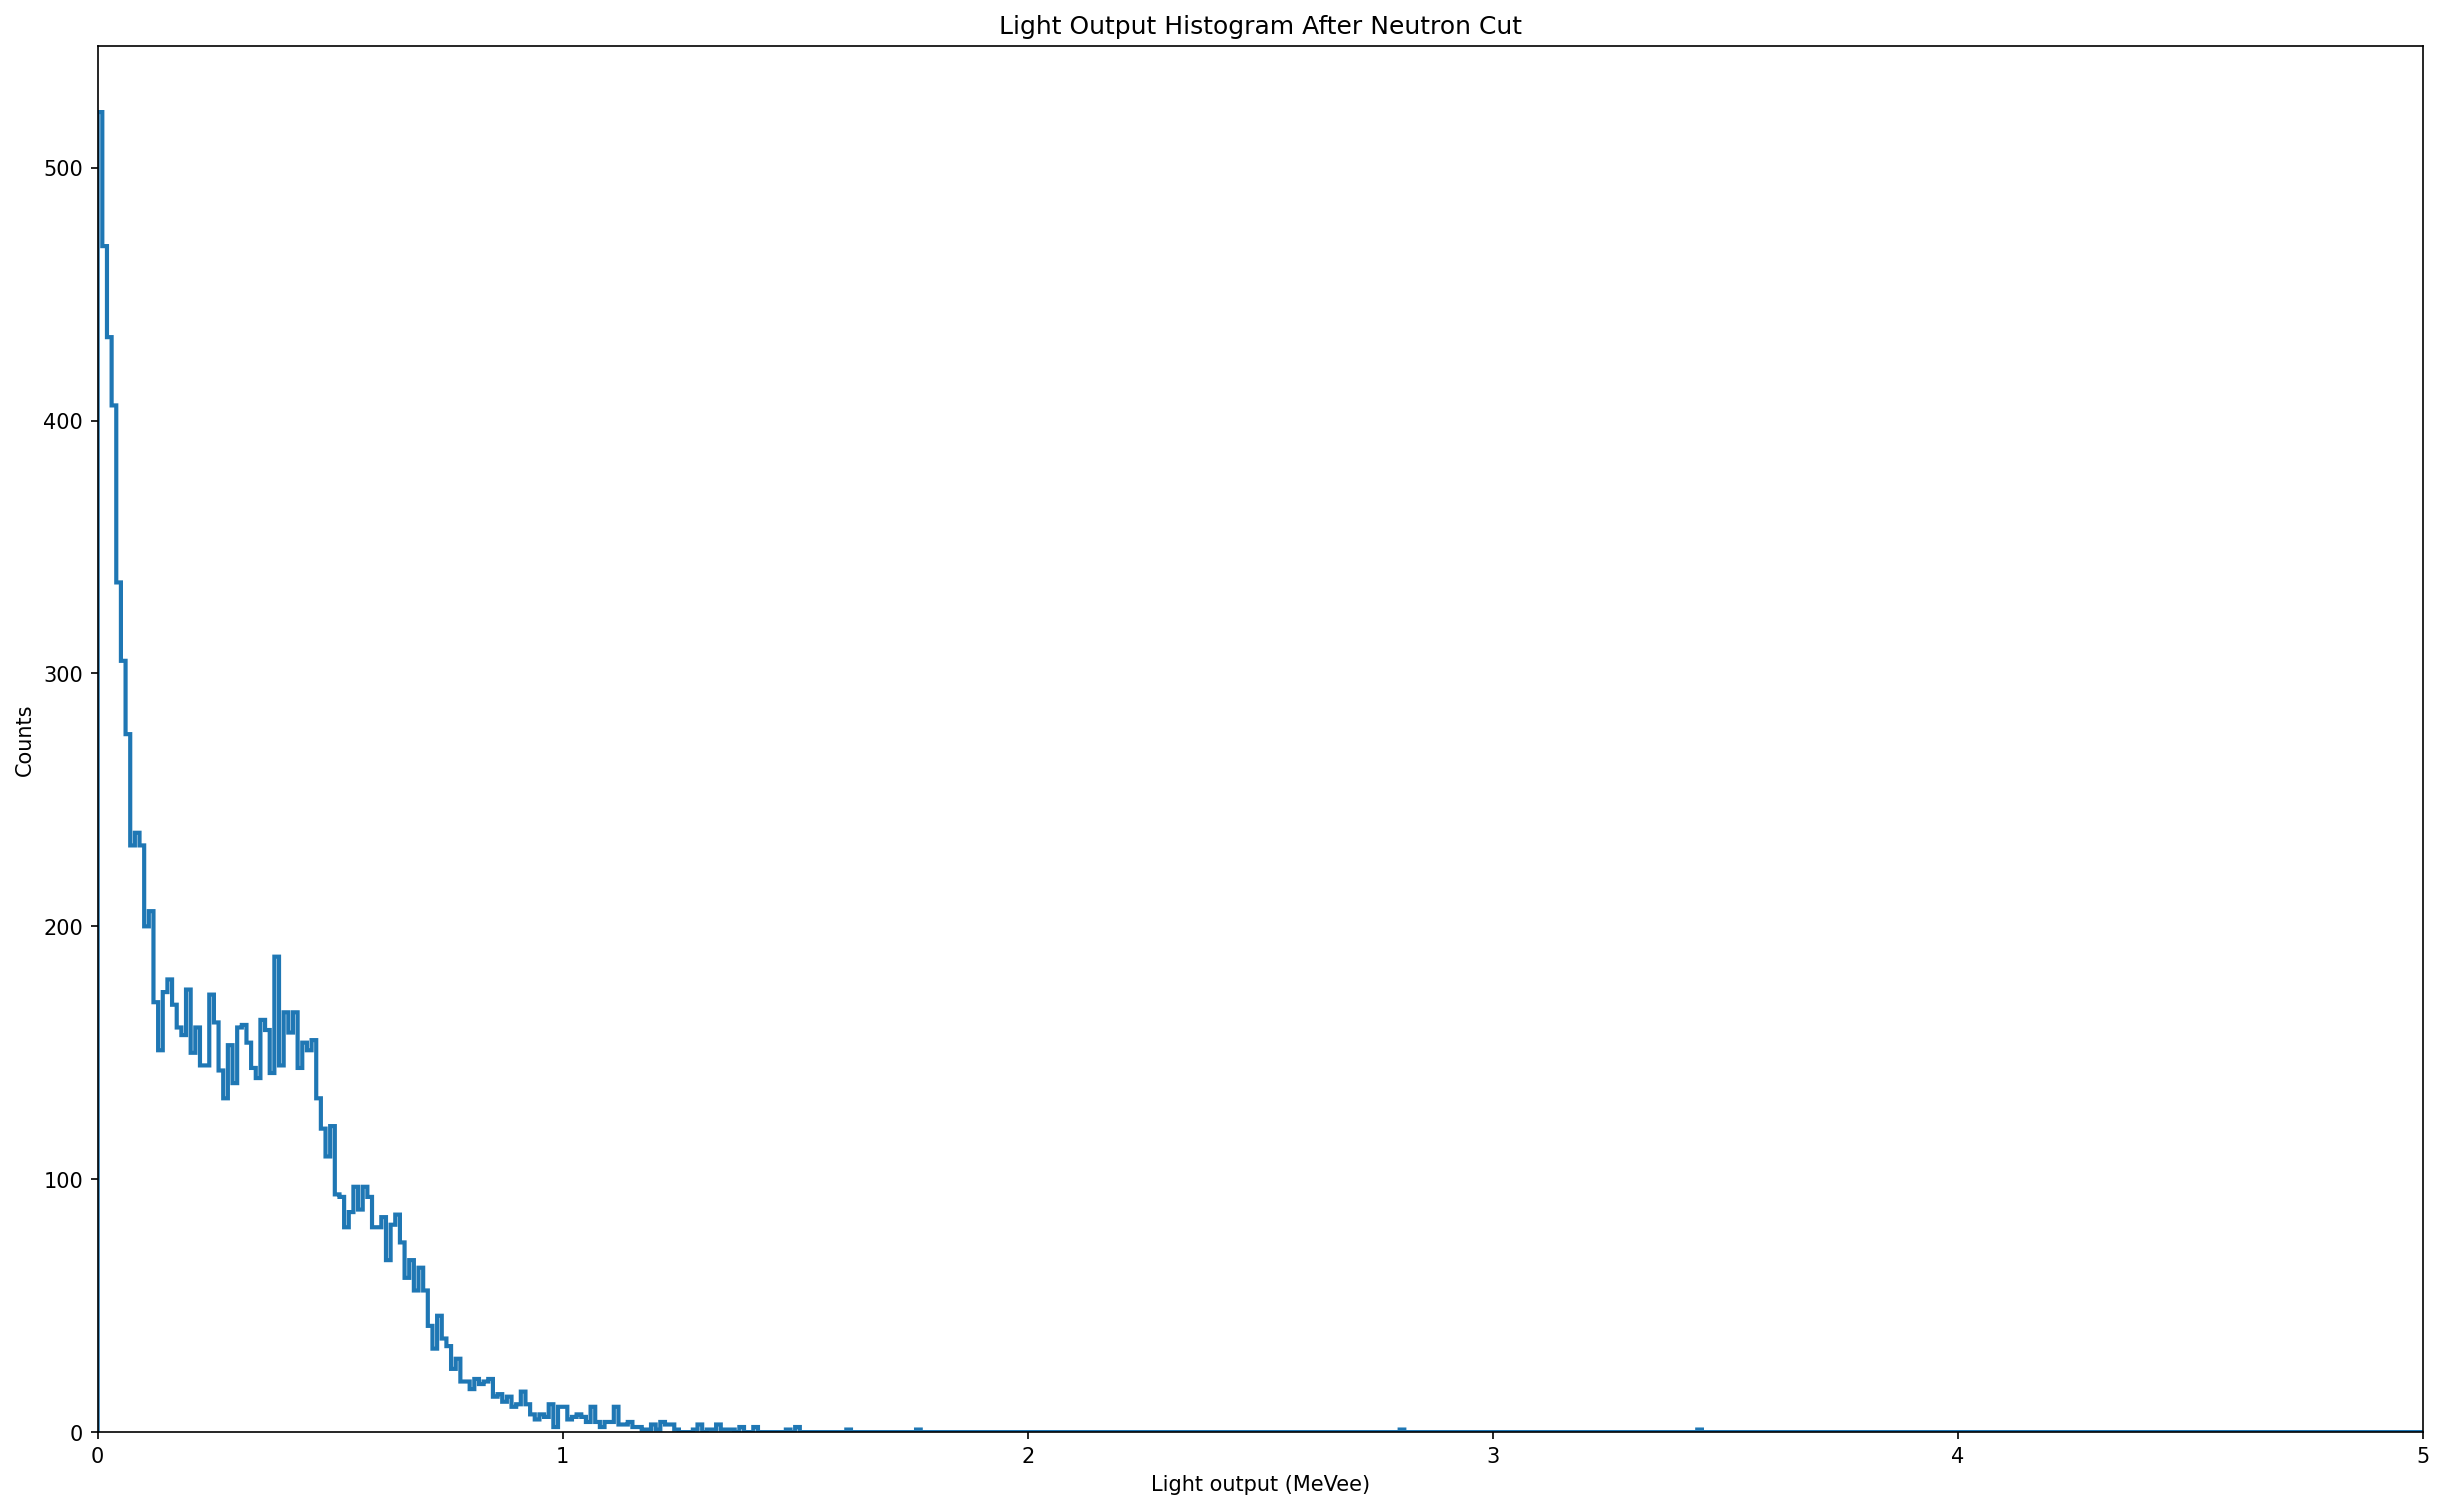

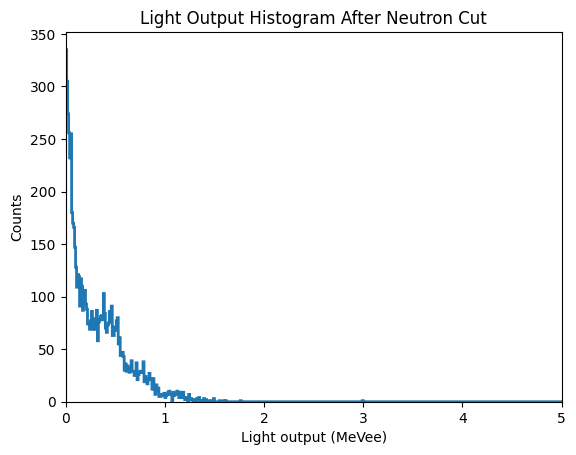

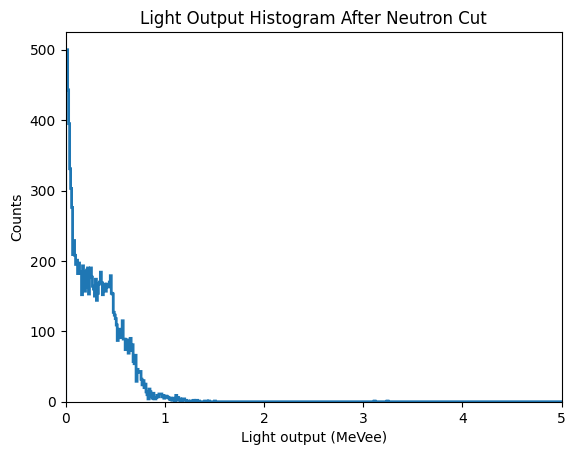

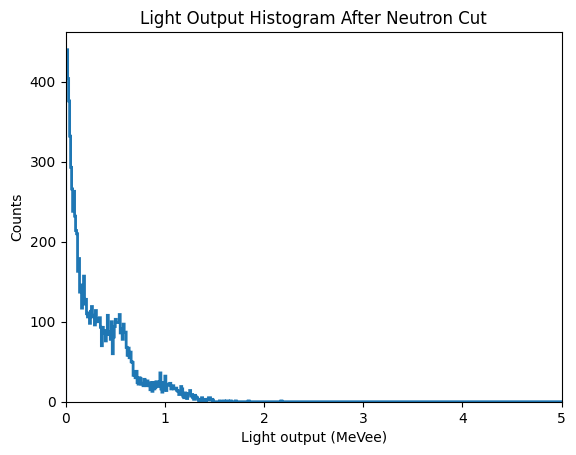

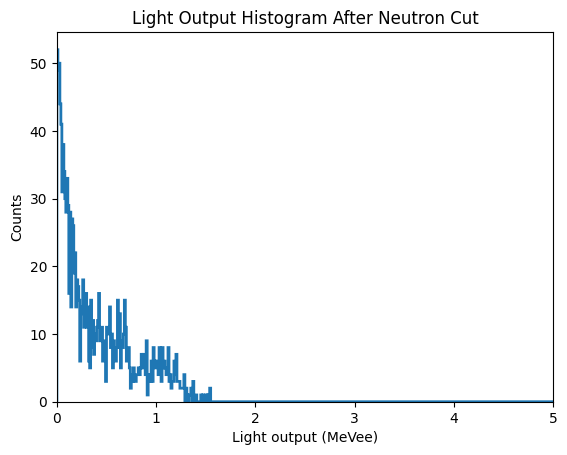

In [18]:
# Open the ROOT file and retrieve the histogram
fig,ax=plt.subplots(1,1,figsize=(20,20))
fig.set_dpi(150)
fig.set_size_inches(20,12)
root_file = ROOT.TFile("Extracted_neutron_spectrum_rootfiles/run_234.root")
for detector in neutronDetectors:
    hist_1d = root_file.Get("hEee_%s" %(detector))
    # Extract the bin contents and edges
    bin_contents = np.array([hist_1d.GetBinContent(i) for i in range(1, hist_1d.GetNbinsX() + 1)])
    bin_edges = np.array([hist_1d.GetBinLowEdge(i) for i in range(1, hist_1d.GetNbinsX() + 2)])

    # Plot the histogram

    plt.hist(bin_edges[:-1], bins=bin_edges, weights=bin_contents, histtype='step', linewidth=2)
    plt.xlabel('Light output (MeVee)')
    plt.ylabel('Counts')
    plt.title('Light Output Histogram After Neutron Cut')
    plt.xlim(0,5)
    #plt.grid(True)
    plt.show()

# Close the ROOT file
root_file.Close()

In [19]:
#Looping over all runs and extracting the neutron data and saving it to a file 
# Open the ROOT file
for runNumber in run:
    inFile_extracted = ROOT.TFile("/Users/shahinashahina/Documents/PhD/Experiments/25Mg(a,n)/CAMPAIGN_2018/25Mg_CAMPAIGN_2018/neutron_data/scripts_python2/ExtractNeutronSpectra_data/run_0%d.root" %(runNumber))
    # Create a ROOT file and save the histogram
    output_file = ROOT.TFile("Extracted_neutron_spectrum_rootfiles/run_%d.root" %(runNumber),"RECREATE" )
    for detector in neutronDetectors:
        # Get the histogram for the current detector
        hPSDee = inFile_extracted.Get("hPSDee_%s" % detector)

        # Extract histogram data
        n_bins_x = hPSDee.GetNbinsX()
        n_bins_y = hPSDee.GetNbinsY()
        x_edges = np.array([hPSDee.GetXaxis().GetBinLowEdge(i) for i in range(1, n_bins_x + 2)])
        y_edges = np.array([hPSDee.GetYaxis().GetBinLowEdge(i) for i in range(1, n_bins_y + 2)])
        hist_2d = np.array([[hPSDee.GetBinContent(i, j) for j in range(1, n_bins_y + 1)] for i in range(1, n_bins_x + 1)])

        # Calculate the lower band (assuming you have defined y_gamma_up and y_neutron_low)
        band_lower = np.maximum(y_gamma_up, y_neutron_low)
    
        # Apply masks based on the thresholds
        y_edges_m1 = y_edges[:-1][y_edges[:-1] > band_lower]
        x_edges_m2 = x_edges[:-1][x_edges[:-1] > 0.1]
        hist_2d_m2 = hist_2d[x_edges[:-1] > 0.1][:, y_edges[:-1] > band_lower]

        # Project onto the x-axis by summing counts along the y-axis within the neutron region
        hist_1d_counts = np.sum(hist_2d_m2, axis=1)

        # Create a new ROOT histogram (TH1F)
        hEee = ROOT.TH1F("hEee_%s" % detector, "Light output after neutron cut;Light output (MeVee);Counts", 1500, 0, 15)

        # Fill the ROOT histogram with the projected data
        for i, count in enumerate(hist_1d_counts):
            hEee.SetBinContent(i+1, count)

        # Write the histogram into the output ROOT file
        output_file.cd()  # Ensure we are in the correct directory within the ROOT file
        hEee.Write()

    # Close the output ROOT file
    output_file.Close()
    

KeyboardInterrupt: 

In [ ]:
responseMatrix = "04_matrix.txt"
responseMatrix = "04_matrix.txt"

energyCalibrationFile1 = "testEcal.dat"
energyCalibrationFile2= "testEcal_40fC.dat"

unfoldingThreshold = 10
unfoldingIterations = 500

neutronDetectors = ["0-0", "0-4", "1-0", "1-2", "1-4"]
unfoldNeutrons = True # Unfold


for i in range(len(run)):
    runNumber = int(run[i])
    beamEnergy = float((energy[i])/1000)
    
    if runNumber<405:
        energyCalibration  = "../neutron_data" + "/" + energyCalibrationFile1
    else:
        energyCalibration  = "../neutron_data" + "/" + energyCalibrationFile2
    detectors = " ".join(["-d {0}".format(d) for d in neutronDetectors])
    
    """ Run unfolding """
    if unfoldNeutrons:
        inputFileName      = "Extracted_neutron_spectrum_rootfiles" + "/run_0%d.root" %(runNumber)
        responseMatrixFile = "../neutron_data/responseMatrix" + "/" + responseMatrix
        outputFileName     = "Unfolding_MLEM_2_data" + "/run_{runNumber:04.0f}.root".format(runNumber = runNumber)
    

        command = "../neutron_data/analysisCode/build/Unfolding_MLEM_2 -i {i} -t {t} -r {r} -o {o} {d} --iterations {it}".format(i = inputFileName, t = unfoldingThreshold, r = responseMatrixFile, o = outputFileName, d = detectors, e = energyCalibration, it = unfoldingIterations)
        os.system(command)
        
    """ Create plots """

    #command = "CreateOverview.py {runNumber} {beamEnergy}".format(runNumber = runNumber, beamEnergy = beamEnergy)
    #os.system(command)


In [ ]:
#plotting the unfolded data
data = np.loadtxt("Unfolded_output_files/0-0/234.txt")

In [ ]:
run

In [ ]:
for runNumber in run:
    data = np.loadtxt("Unfolded_output_files/0-0/%d.txt" %runNumber)
    plt.figure()
    plt.step(data[:,0],data[:,1])
    plt.title("Det_0-0: Run: %d" %(runNumber))
    

In [ ]:
#beamEnergy = float((energy[i])/1000)

In [ ]:

for i in range(len(energy)):
    beamEnergy = float((energy[i])/1000)
    print(f"\nBeam Energy: {beamEnergy} MeV")
    for reaction in reactions:
        for angle in theta:
            neutron_energy = En(beamEnergy, angle, reaction.M1, reaction.M2, reaction.M3, reaction.M4, reaction.Q)
            print(f"Reaction: {reaction.name}, Angle: {angle} degrees, Neutron Energy: {neutron_energy:.2f} MeV")

In [ ]:
# List of neutron detectors
neutronDetectors = ["0-0", "0-4", "1-0", "1-2", "1-4"]

# Reaction colors dictionary with valid Matplotlib colors
reactions = {
    "25Mg(a,n0)": "red",
    "25Mg(a,n1)": "orange",
    "17O(a,n0)":  "green",
    "17O(a,n1)":  "darkorange",
    "18O(a,n0)":  "blue",
    "18O(a,n1)":  "dodgerblue",
    "13C(a,n0)":  "magenta",
    "10B(a,n0)":  "darkorange",
    "11B(a,n0)":  "gray"
}

# Sorted reactions
rs = sorted(reactions.keys())

# Loop over run numbers
for i in range(len(run)):
    runNumber = int(run[i])
    beamEnergy = float((energy[i]) / 1000)  # Assuming 'energy' corresponds to run index

    # Loop over neutron detectors
    for detector in neutronDetectors:
        data = np.loadtxt("Unfolded_output_files/%s/%d.txt" % (detector, runNumber))
        
        # Plot the step data
        plt.figure()
        plt.step(data[:,0], data[:,1], label="Detector %s" % detector)
        plt.title("Detector %s: Run: %d" % (detector, runNumber))
        plt.xlabel("Channel")
        plt.ylabel("Counts")
        
    
        plt.show()

In [ ]:
# Reaction class definition
class Reaction:
    def __init__(self, name, M1, M2, M3, M4, Q):
        self.name = name
        self.M1 = M1
        self.M2 = M2
        self.M3 = M3
        self.M4 = M4
        self.Q = Q

# Neutron Energy definitions 
reactions = [
    Reaction("25Mg(a,n0)", 4.002055, 25, 1, 28, 2.65361),
    Reaction("25Mg(a,n1)", 4.002055, 25, 1, 28, 2.65361-1.779),
    #Reaction("25Mg(a,n2)", 4.002055, 25, 1, 28, 2.65361-4.61786),
    Reaction("13C(a,n0)", 4.002055, 13, 1, 16, 2.21561),
    Reaction("17O(a,n0)", 4.002055, 17, 1, 20, 0.58677),
    Reaction("17O(a,n1)", 4.002055, 17, 1, 20, 0.58677-1.633),
    Reaction("18O(a,n0)", 4.002055, 18, 1, 21, -0.69744),
    Reaction("18O(a,n1)", 4.002055, 18, 1, 21, -0.69744-0.3507),
    Reaction("10B(a,n0)", 4.002055, 10, 1, 13, 1.0587),
    Reaction("11B(a,n0)", 4.002055, 11, 1, 14, 0.15789),
]

theta = [125.0, 90.0, 90.0, 55.0, 125.0, 55.0, 0.0]

def Et(Ebeam, Q):
    return Ebeam + Q

def A(Ebeam, M1, M2, M3, M4, Q):
    return (M1 * M4 * (Ebeam / Et(Ebeam, Q))) / ((M1 + M2) * (M3 + M4))

def B(Ebeam, M1, M2, M3, M4, Q):
    return M1 * M3 * Ebeam / Et(Ebeam, Q) / ((M1 + M2) * (M3 + M4))

def C(Ebeam, M1, M2, M3, M4, Q):
    return M2 * M3 / ((M1 + M2) * (M3 + M4)) * (1 + M1 * Q / M2 / Et(Ebeam, Q))

def D(Ebeam, M1, M2, M3, M4, Q):
    return M2 * M4 / ((M1 + M2) * (M3 + M4)) * (1 + M1 * Q / M2 / Et(Ebeam, Q))

def En(Ebeam, theta, M1, M2, M3, M4, Q):
    theta_rad = (theta * np.pi) / 180  # theta is in degrees 
    return (B(Ebeam, M1, M2, M3, M4, Q) + D(Ebeam, M1, M2, M3, M4, Q) + 
            2 * np.sqrt(A(Ebeam, M1, M2, M3, M4, Q) * C(Ebeam, M1, M2, M3, M4, Q)) * np.cos(theta_rad)) * Et(Ebeam, Q)

# Filter reactions to include only the specified ones
filtered_reactions = [reaction for reaction in reactions if reaction.name in ["25Mg(a,n0)", "25Mg(a,n1)", "13C(a,n0)"]]

# Dictionary mapping neutron detectors to their respective angles
neutron_detectors = {"0-0": 125, "0-4": 90, "1-0": 125, "1-2": 55, "1-4": 0}

# Reaction colors dictionary
reaction_colors = {
    "25Mg(a,n0)": "red",
    "25Mg(a,n1)": "orange",
    "13C(a,n0)":  "magenta",
}



# Plot neutron energies
for i in range(len(energy)):
    beamEnergy = float((energy[i]) / 1000)  # Convert keV to MeV
    runNumber = int(run[i])
    
    # Loop over neutron detectors
    for detector, angle in neutron_detectors.items():
        data = np.loadtxt(f"Unfolded_output_files/{detector}/{runNumber}.txt")
        plt.figure()
        plt.step(data[:, 0], data[:, 1], label=f"Detector {detector}")
        plt.title(f"Detector {detector}: Run: {runNumber}, Beam Energy: {beamEnergy} MeV")
        plt.xlabel("Channel")
        plt.ylabel("Counts")
        
        for reaction in filtered_reactions:
            neutron_energy = En(beamEnergy, angle, reaction.M1, reaction.M2, reaction.M3, reaction.M4, reaction.Q)
            plt.axvline(neutron_energy-0.4, color=reaction_colors[reaction.name], label=f"{reaction.name} at {neutron_energy:.2f} MeV")

        plt.legend()
        plt.show()

In [ ]:
# Reaction class definition
class Reaction:
    def __init__(self, name, M1, M2, M3, M4, Q):
        self.name = name
        self.M1 = M1
        self.M2 = M2
        self.M3 = M3
        self.M4 = M4
        self.Q = Q

# Neutron Energy definitions 
reactions = [
    Reaction("25Mg(a,n0)", 4.002055, 25, 1, 28, 2.65361),
    Reaction("25Mg(a,n1)", 4.002055, 25, 1, 28, 2.65361-1.779),
    #Reaction("25Mg(a,n2)", 4.002055, 25, 1, 28, 2.65361-4.61786),
    Reaction("13C(a,n0)", 4.002055, 13, 1, 16, 2.21561),
    Reaction("17O(a,n0)", 4.002055, 17, 1, 20, 0.58677),
    Reaction("17O(a,n1)", 4.002055, 17, 1, 20, 0.58677-1.633),
    Reaction("18O(a,n0)", 4.002055, 18, 1, 21, -0.69744),
    Reaction("18O(a,n1)", 4.002055, 18, 1, 21, -0.69744-0.3507),
    Reaction("10B(a,n0)", 4.002055, 10, 1, 13, 1.0587),
    Reaction("11B(a,n0)", 4.002055, 11, 1, 14, 0.15789),
]

theta = [125.0, 90.0, 90.0, 55.0, 125.0, 55.0, 0.0]

def Et(Ebeam, Q):
    return Ebeam + Q

def A(Ebeam, M1, M2, M3, M4, Q):
    return (M1 * M4 * (Ebeam / Et(Ebeam, Q))) / ((M1 + M2) * (M3 + M4))

def B(Ebeam, M1, M2, M3, M4, Q):
    return M1 * M3 * Ebeam / Et(Ebeam, Q) / ((M1 + M2) * (M3 + M4))

def C(Ebeam, M1, M2, M3, M4, Q):
    return M2 * M3 / ((M1 + M2) * (M3 + M4)) * (1 + M1 * Q / M2 / Et(Ebeam, Q))

def D(Ebeam, M1, M2, M3, M4, Q):
    return M2 * M4 / ((M1 + M2) * (M3 + M4)) * (1 + M1 * Q / M2 / Et(Ebeam, Q))

def En(Ebeam, theta, M1, M2, M3, M4, Q):
    theta_rad = (theta * np.pi) / 180  # theta is in degrees 
    return (B(Ebeam, M1, M2, M3, M4, Q) + D(Ebeam, M1, M2, M3, M4, Q) + 
            2 * np.sqrt(A(Ebeam, M1, M2, M3, M4, Q) * C(Ebeam, M1, M2, M3, M4, Q)) * np.cos(theta_rad)) * Et(Ebeam, Q)

# Filter reactions to include only the specified ones
#filtered_reactions = [reaction for reaction in reactions if reaction.name in ["25Mg(a,n0)", "25Mg(a,n1)", "13C(a,n0)"]]

# Filter reactions to include only the 25Mg(a,n1)
filtered_reactions = [reaction for reaction in reactions if reaction.name == "25Mg(a,n1)"]


# Dictionary mapping neutron detectors to their respective angles
neutron_detectors = {"0-0": 125, "0-4": 90, "1-0": 125, "1-2": 55, "1-4": 0}

# Reaction colors dictionary
reaction_colors = {
    "25Mg(a,n0)": "red",
    "25Mg(a,n1)": "orange",
    "13C(a,n0)":  "magenta",
}


# Directory to save the integrated counts
output_directory = "integrated_counts"
os.makedirs(output_directory, exist_ok=True)


    # Plot neutron energies
for i in range(len(energy)):
    beamEnergy = float((energy[i]) / 1000)  # Convert keV to MeV
    runNumber = int(run[i])

    # Loop over neutron detectors
    for detector, angle in neutron_detectors.items():
         # Mock data to demonstrate functionality (replace with actual data loading)
        data = np.loadtxt(f"Unfolded_output_files/{detector}/{runNumber}.txt")  # Example data loading
        channel = data[:, 0]
        counts = data[:, 1]

        plt.figure()
        plt.step(channel, counts, label=f"Detector {detector}")
        plt.title(f"Detector {detector}: Run: {runNumber}, Beam Energy: {beamEnergy} MeV")
        plt.xlabel("Channel")
        plt.ylabel("Counts")

        for reaction in filtered_reactions:
            neutron_energy = En(beamEnergy, angle, reaction.M1, reaction.M2, reaction.M3, reaction.M4, reaction.Q)
            peak_center = neutron_energy - 0.4

            # Integration limits
            integration_width = 0.25  # Example width
            lower_limit = peak_center - integration_width
            upper_limit = peak_center + integration_width

            # Find indices within the integration range
            indices = np.where((channel >= lower_limit) & (channel <= upper_limit))
            integration_area = np.trapz(counts[indices], channel[indices])

            plt.axvline(peak_center, color=reaction_colors[reaction.name], label=f"{reaction.name} at {neutron_energy:.2f} MeV")

            # Shade the integrated area
            plt.fill_between(channel[indices], counts[indices], color=reaction_colors[reaction.name], alpha=0.3)

            # Save the integration area and beam energy to file
            output_file = os.path.join(output_directory, f"{detector}_integrated_counts.txt")
            with open(output_file, "a") as file:
                file.write(f"{runNumber},{beamEnergy},{integration_area}\n")


        plt.legend()
        plt.show()

In [ ]:
# Loading the counts from the above files
data_counts_unfolded = pd.read_csv("integrated_counts/0-0_integrated_counts.txt",header=None)

In [ ]:
# Loading the counts from the above files for det 0-4 
data_counts_unfolded_0_4 = pd.read_csv("integrated_counts/0-4_integrated_counts.txt",header=None)

In [ ]:
# Loading the counts from the above files for det 1-0
data_counts_unfolded_1_0 = pd.read_csv("integrated_counts/1-0_integrated_counts.txt",header=None)

In [ ]:
# Loading the counts from the above files for det 1-2
data_counts_unfolded_1_2 = pd.read_csv("integrated_counts/1-2_integrated_counts.txt",header=None)

In [ ]:
# Loading the counts from the above files for det 1-4
data_counts_unfolded_1_4 = pd.read_csv("integrated_counts/1-4_integrated_counts.txt",header=None)

In [ ]:
# ----This is for detector 0-0
runNumber_unfolded = data_counts_unfolded[0]
energy_unfolded = data_counts_unfolded[1]
counts_unfolded = data_counts_unfolded[2]

In [ ]:
#----This is for detector 0-4 
runNumber_unfolded_0_4 = data_counts_unfolded_0_4[0]
energy_unfolded_0_4 = data_counts_unfolded_0_4[1]
counts_unfolded_0_4 = data_counts_unfolded_0_4[2]

In [ ]:
#----This is for detector 1-0
runNumber_unfolded_1_0 = data_counts_unfolded_1_0[0]
energy_unfolded_1_0 = data_counts_unfolded_1_0[1]
counts_unfolded_1_0 = data_counts_unfolded_1_0[2]

In [ ]:
#----This is for detector 1-2
runNumber_unfolded_1_2 = data_counts_unfolded_1_2[0]
energy_unfolded_1_2 = data_counts_unfolded_1_2[1]
counts_unfolded_1_2 = data_counts_unfolded_1_2[2]

In [ ]:
#----This is for detector 1-4
runNumber_unfolded_1_4 = data_counts_unfolded_1_4[0]
energy_unfolded_1_4 = data_counts_unfolded_1_4[1]
counts_unfolded_1_4 = data_counts_unfolded_1_4[2]

In [ ]:
# Loading the charge file 
data_charge = np.loadtxt("charge.txt")
run_data_charge = data_charge[:,0]
charge = data_charge[:,1]

In [ ]:
len(run_data_charge)

In [ ]:
runNumber_unfolded_0_4

In [ ]:
data = {}

with open('charge.txt', 'r') as file:
    for line in file:
        parts = line.strip().split()
        
        if len(parts) < 2:
            # Skip lines that don't have at least two parts
            continue
        
        try:
            run_number = int(parts[0].strip())
            charge = float(parts[1].strip())
            data[run_number] = charge
        except (ValueError, IndexError) as e:
            print(f"Error parsing line '{line.strip()}': {e}")

# Step 2: Define the array of runNumbers to match
runNumbers_to_match = run

# Step 3: Match runNumbers and retrieve charges
matched_charges = []
for runNumber in runNumbers_to_match:
    if runNumber in data:
        matched_charges.append(data[runNumber])
    else:
        # Handle case where runNumber is not found in data
        matched_charges.append(None)  # or handle differently based on your needs

# Step 4: Print or use the matched charges
print("Matched charges:", matched_charges)

In [ ]:
len(matched_charges)

In [ ]:

Yield_det_0 = counts_unfolded/(matched_charges)

In [ ]:

Yield_det_0_4 = counts_unfolded_0_4/(matched_charges)

In [ ]:

Yield_det_1_0 = counts_unfolded_1_0/(matched_charges)

In [ ]:
Yield_det_1_2 = counts_unfolded_1_2/(matched_charges)

In [ ]:
Yield_det_1_4 = counts_unfolded_1_4/(matched_charges)

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
fig.set_dpi(150)
fig.set_size_inches(10,8)

# Sort Ebeam and get the sorted indices
sorted_indices = np.argsort(energy_unfolded)
Ebeam_sorted = energy_unfolded[sorted_indices]
Yield_det_0_sorted = Yield_det_0[sorted_indices]
Yield_det_0_4_sorted = Yield_det_0_4[sorted_indices]
Yield_det_1_0_sorted = Yield_det_1_0[sorted_indices]
Yield_det_1_2_sorted = Yield_det_1_2[sorted_indices]
Yield_det_1_4_sorted = Yield_det_1_4[sorted_indices]

# Plot the sorted data
plt.plot(Ebeam_sorted, Yield_det_0_sorted,"o-",label="Det 0-0, Angle:125 deg.")
plt.plot(Ebeam_sorted, Yield_det_0_4_sorted,"o-",label="Det 0-4, Angle:90 deg.")
plt.plot(Ebeam_sorted, Yield_det_1_0_sorted,"o-",label="Det 1-0, Angle:125 deg.")
plt.plot(Ebeam_sorted, Yield_det_1_2_sorted,"o-",label="Det 1-2, Angle: 55 deg.")
#plt.plot(Ebeam_sorted, Yield_det_1_4_sorted,"o-",label="Det 1-4, Angle: 0 deg.")


plt.yscale("log")
plt.xlabel("Energy [keV]")
plt.ylabel("Yield")
plt.title("Neutron Yield vs Ebeam")
plt.legend()
plt.show()



In [ ]:
#Converting the yield to the absolute cross-section
# The 25Mg target thickness is nearly the same as the 25Mg target thickness during the
# secondary gamma-ray measurements
target_thick = 8.4322*pow(10,17)


In [ ]:
# Getting the efficiency for all the neutron detectors 
data_efficiency = pd.read_csv("Efficiency_MCNP/Efficiency_values.txt",skiprows=32,header=None)

In [ ]:
data ="""

1.0     7.09E-03 7.32E-03 7.38E-03 5.79E-03 6.63E-04
1.5     1.04E-02 1.07E-02 1.10E-02 8.42E-03 9.78E-04
2.0     1.03E-02 1.08E-02 1.09E-02 8.43E-03 9.65E-04
2.5     9.92E-03 1.05E-02 1.07E-02 8.11E-03 9.40E-04
3.0     9.59E-03 1.00E-02 1.02E-02 7.96E-03 9.21E-04
3.5     9.17E-03 9.53E-03 9.63E-03 7.72E-03 8.35E-04
4.0     8.80E-03 8.98E-03 9.20E-03 7.28E-03 8.26E-04
4.5     8.45E-03 8.63E-03 8.79E-03 7.15E-03 8.00E-04
5.0     8.01E-03 8.22E-03 8.37E-03 6.74E-03 7.10E-04
5.5     7.59E-03 7.78E-03 7.90E-03 6.56E-03 7.04E-04
6.0     7.43E-03 7.60E-03 7.74E-03 6.39E-03 6.79E-04
6.5     7.25E-03 7.41E-03 7.62E-03 6.13E-03 6.29E-04
7.0     6.98E-03 7.10E-03 7.36E-03 5.99E-03 6.24E-04
7.5     6.79E-03 7.01E-03 7.10E-03 5.85E-03 6.44E-04
8.0     6.50E-03 6.76E-03 6.82E-03 5.59E-03 6.11E-04



"""

In [ ]:
from io import StringIO

data_io = StringIO(data)
df = pd.read_csv(data_io, delim_whitespace=True, header=None)


In [ ]:
neutron_energy_eff = df[0] 
eff_55 = df[1]

In [ ]:
from scipy.interpolate import interp1d

# Interpolate between data points
interp_func = interp1d(neutron_energy_eff, eff_55, kind='linear')  # Linear interpolation
neutron_energy_interp = np.linspace(min(neutron_energy_eff), max(neutron_energy_eff), 100)  # New energy values for interpolation
eff_interp = interp_func(neutron_energy_interp)

In [ ]:
# En(Ebeam, theta, M1, M2, M3, M4, Q):

neutron_energies = En(Ebeam_sorted,55, 4.002055, 25, 1, 28, 2.65361-1.779)
eff_at_experimental_neutron_energies = interp_func(neutron_energies)


In [ ]:
#Angles =  55     125    235    270    0



In [ ]:
# Get the efficiency 
#C/pulse here is 10^(-6) and not 10^(-8)

cross_section_55 = (Yield_det_1_2_sorted*(1.6*pow(10,-19))/(pow(10,-6)))/(eff_at_experimental_neutron_energies*target_thick)

In [ ]:
plt.plot(Ebeam_sorted,cross_section_55*10**(24)*4*np.pi,"o-")
plt.yscale("log")

In [ ]:
# Getting the effective alpha-particle energy 
srim_energy = ion_energy
srim_dE = dEdx_elec

In [ ]:
#Energy interpolation 
plt.plot(srim_energy,srim_dE,"o")

In [ ]:
f2 = interp1d(srim_energy,srim_dE,kind="cubic")

In [ ]:
energy_new = np.linspace(np.min(srim_energy),np.max(srim_energy),1000)
y = f2(energy_new)
plt.plot(srim_energy,srim_dE,"o")
plt.plot(energy_new,y,linestyle="-")

In [ ]:
# This is for the 2018 measurement

dE = f2(Ebeam_sorted)
dE = dE*33  # Multiplying with target thickness
dE = dE/(1000) 


In [ ]:
# Calculating the effective beam energy 
E_eff_2018 = Ebeam_sorted - 0.5*dE 


In [ ]:
# Data from 25Mg_an_compare.agr file
Anderson_long_counter = np.loadtxt("/Users/shahinashahina/Documents/PhD/Experiments/25Mg(a,n)/CAMPAIGN_2018/25Mg_CAMPAIGN_2018/25Mg/gamma_ray_data/gamma_data_Nov/python2_script/papers_data/25Mg_an_compare_data/Anderson_long_counter.txt")
Energy_Anderson_long_counter = Anderson_long_counter[:,0]
cross_Anderson_long_counter= Anderson_long_counter[:,1]

Anderson_secondary_gamma = np.loadtxt("/Users/shahinashahina/Documents/PhD/Experiments/25Mg(a,n)/CAMPAIGN_2018/25Mg_CAMPAIGN_2018/25Mg/gamma_ray_data/gamma_data_Nov/python2_script/papers_data/25Mg_an_compare_data/Anderson_secondary_gamma.txt")
Energy_Anderson_secondary_gamma = Anderson_secondary_gamma[:,0]
cross_Anderson_secondary_gamma = Anderson_secondary_gamma[:,1]


In [ ]:
#Loading the Huaser-Feshbach data 
sapphire_n_tot_data = np.loadtxt("/Users/shahinashahina/Documents/PhD/Experiments/25Mg(a,n)/CAMPAIGN_2018/25Mg_CAMPAIGN_2018/25Mg/Hauser_Feshbach/Sapphire_25Mg+a(1).dat")
sapphire_n0_data = np.loadtxt("/Users/shahinashahina/Documents/PhD/Experiments/25Mg(a,n)/CAMPAIGN_2018/25Mg_CAMPAIGN_2018/25Mg/Hauser_Feshbach/Sapphire_25Mg+a_0(1).dat")
sapphire_n1_data = np.loadtxt("/Users/shahinashahina/Documents/PhD/Experiments/25Mg(a,n)/CAMPAIGN_2018/25Mg_CAMPAIGN_2018/25Mg/Hauser_Feshbach/Sapphire_25Mg+a_1(1).dat")
sapphire_n2_data = np.loadtxt("/Users/shahinashahina/Documents/PhD/Experiments/25Mg(a,n)/CAMPAIGN_2018/25Mg_CAMPAIGN_2018/25Mg/Hauser_Feshbach/Sapphire_25Mg+a_2(1).dat")


sapphire_n_tot_energy_lab = (sapphire_n_tot_data[:,0]*29)/25
sapphire_n0_energy_lab = (sapphire_n0_data[:,0]*29)/25
sapphire_n1_energy_lab = (sapphire_n1_data[:,0]*29)/25
sapphire_n2_energy_lab = (sapphire_n2_data[:,0]*29)/25

sapphire_n_tot_cross = sapphire_n_tot_data[:,2]
sapphire_n0_cross = sapphire_n0_data[:,2]
sapphire_n1_cross = sapphire_n1_data[:,2]
sapphire_n2_cross = sapphire_n2_data[:,2]

In [ ]:
#Neutron data from neutron detector data from campaign 2 
#Loading the cross-section from the neutron data
data_cross_neutron = np.loadtxt("/Users/shahinashahina/Documents/PhD/Experiments/25Mg(a,n)/CAMPAIGN_2021/25Mg_codes_Shahina/python3_code/cross_section_25Mg_n1.txt")
energy_neutron = data_cross_neutron[:,0]
cross_section_neutron = data_cross_neutron[:,1]
cross_section_neutron_err = data_cross_neutron[:,2]

sorted_indices_neutron = np.argsort(energy_neutron)
energy_neutron_sorted = energy_neutron[sorted_indices_neutron]
cross_section_neutron_sorted = cross_section_neutron[sorted_indices_neutron]

In [ ]:
# Effective energy for 2021 measurement 
dE_2021 = f2(energy_neutron_sorted)
dE_2021 = dE_2021*78  # Multiplying with target thickness
dE_2021 = dE_2021/(1000) 

In [ ]:
# Calculating the effective beam energy 
E_eff_2021 = energy_neutron_sorted - 0.5*dE_2021 

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(30,30))
fig.set_dpi(150)
fig.set_size_inches(30,28)
ax.plot(E_eff_2021,cross_section_neutron_sorted,"o-",label="Present work (2021), n1")
ax.plot(E_eff_2018,cross_section_55*10**(24)*4*np.pi,"o-",label="Present measurement (2018)")
ax.plot(sapphire_n1_energy_lab,(sapphire_n1_cross),linewidth=3,linestyle="--",label="SAPPHIRE: Hauser Feshbach (n1)")
ax.plot(Energy_Anderson_secondary_gamma,cross_Anderson_secondary_gamma,'o-',color="red",label='Anderson et al. (Secondary $\gamma$-rays,n1)')

plt.yscale("log")
#plt.xlim(1.7,5)
#plt.ylim(10**-7,10**-2)
plt.legend()

In [ ]:
pwd

In [ ]:
# Writing arrays to a file
output_file1 = "cross_section_n1_2018_campaign.txt"

with open(output_file1, 'w') as file1:
    for i in range(len(E_eff_2018)):
        file1.write("%f \t %.10e \n" %(E_eff_2018[i],cross_section_55[i]))
file1.close()

In [ ]:
cross_section_55

In [ ]:
# Writing arrays to a file
output_file2 = "cross_section_n1_2021_campaign.txt"

with open(output_file2, 'w') as file2:
    for i in range(len(E_eff_2021)):
        file2.write("%f \t %.10e \n" %(E_eff_2021[i],cross_section_neutron_sorted[i]))
file2.close()

In [ ]:
#Calculating the effective energy to cmapre the 2018 measurement with the 2021 measurement 


In [ ]:
#Comparing the yield from the 2021 campaign to the 2018 campaign 
data_neutron_2021 = np.loadtxt('/Users/shahinashahina/Documents/PhD/Experiments/25Mg(a,n)/CAMPAIGN_2021/25Mg_codes_Shahina/python3_code/counts_unfolding.txt')
charge_2021 = data_neutron_2021[:,0]
counts_25Mg_n1_2021 = data_neutron_2021[:,3]
energy_2021 = (data_neutron_2021[:,2])/1000
yield_neutron_2021 = counts_25Mg_n1_2021/(charge_2021)

In [ ]:
# Sort Ebeam and get the sorted indices
sorted_indices = np.argsort(energy_2021)
Ebeam_sorted_2021 = energy_2021[sorted_indices]
yield_neutron_2021_sorted = yield_neutron_2021[sorted_indices]

In [ ]:
print(run)

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
fig.set_dpi(150)
fig.set_size_inches(10,8)



# Plot the sorted data

plt.plot(Ebeam_sorted, Yield_det_0_sorted*1000,"o-",label="Data_2018")
#plt.plot(Ebeam_sorted_2021, yield_neutron_2021_sorted ,"o-",label="Data_2021")

plt.yscale("log")
plt.xlabel("Energy [keV]")
plt.ylabel("Yield")
plt.title("Yield vs Ebeam")
plt.legend()
#plt.xlim(1.85,2.2)
plt.show()

In [ ]:
# Getting the absolute cross-section from the yield above
# First need to know the target thickness
